## Saving Pi-Control Indices in .pkl
### Indices are derived from anomalies from the detrended data and then normalized<br>
### Indices include: EPC1, EPC2, PSA1, PSA2, SAM, WAIS d18O PCs 1-3, ASL Rel CP Value, ASL Abs CP Value, ASL CP lon, ASL CP lat
### Now includes Southern Oscillation and Nino3.4 (15Jan2019)
### Indice time periods include: DJF, MAM, JJA, SON, 3- 6- 12- Month Roll, Annual Mean, and 2-7-yr bandpass filter
### 19Nov2018 Update includes improved way to calculate ASL Components


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.path as mpath
import datetime
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind
from scipy import signal
from IPython.display import display
import xarray as xr
import dask as da
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from dask.array.rechunk import rechunk
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import statsmodels.api as sm

#for era
from eofs.xarray import Eof
from eofs.examples import example_data_path
np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

In [2]:
############# to be set #############

##Save .pkl file path
PICKLE_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_Indices_as_CSV_19Nov2018'
model     = 'iCESM'

exp = 'CTRL'

XCHUNK = 144 #Full size chunk seems to make things run quickest
YCHUNK = 96 #Full Y size chunk makes things run quickest
ZCHUNK = 30 #Full Z size chunk 
TCHUNK = 576  #Run-time seems consistent with changes to TCHUNK, but 12 looks like best and logical

##Load CTRL netcdf as Xarray
CTRL_DATA_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'
CTRL_DATA = xr.open_dataset(CTRL_DATA_PATH+'/CTRL_DATA.nc')

##Save figure file path
# FIG_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/New_Folder'

CTRL_DATA

<xarray.Dataset>
Dimensions:    (lat: 96, lon: 144, time: 576)
Coordinates:
  * time       (time) datetime64[ns] 1702-01-31 1702-02-28 1702-03-31 ...
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 -78.63 ...
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
Data variables:
    land_frac  (time, lat, lon) float32 ...
    sst        (time, lat, lon) float32 ...
    msl        (time, lat, lon) float32 ...
    u10        (time, lat, lon) float32 ...
    v10        (time, lat, lon) float32 ...
    t2m        (time, lat, lon) float32 ...
    tp         (time, lat, lon) float32 ...
    ci         (time, lat, lon) float32 ...
    d18O       (time, lat, lon) float32 ...

In [3]:
#getting variables in right units 
slp_tmon_ctrl = CTRL_DATA.data_vars['msl']/100 #hPa
v10_tmon_ctrl = CTRL_DATA.data_vars['v10'] #in m/s at 10m
u10_tmon_ctrl = CTRL_DATA.data_vars['u10'] #in m/s at 10m
t2m_tmon_ctrl = CTRL_DATA.data_vars['t2m']-273.15 #in C
tp_tmon_ctrl  = CTRL_DATA.data_vars['tp']*60*60*24*1000  #in mm/day
ci_tmon_ctrl  = CTRL_DATA.data_vars['ci'] #in [0-1] fraction of sea ice
sst_tmon_ctrl  = CTRL_DATA.data_vars['sst']-273.15 #Equivalent to SST over ocean in C
d18O_tmon_ctrl = CTRL_DATA.data_vars['d18O'] #per mill
land_tmon_ctrl = CTRL_DATA.data_vars['land_frac']

In [4]:
sst_tmon_ctrl

<xarray.DataArray 'sst' (time: 576, lat: 96, lon: 144)>
array([[[       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan],
        ...,
        [-35.557724, -35.565704, ..., -35.644165, -35.593903],
        [-36.451324, -36.46634 , ..., -36.433807, -36.439606]],

       [[       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan],
        ...,
        [-37.1046  , -37.04274 , ..., -37.30893 , -37.20279 ],
        [-37.57068 , -37.55655 , ..., -37.5979  , -37.584427]],

       ...,

       [[       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan],
        ...,
        [-33.072983, -32.970596, ..., -33.270782, -33.176712],
        [-33.43065 , -33.41658 , ..., -33.441086, -33.441116]],

       [[       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan],
    

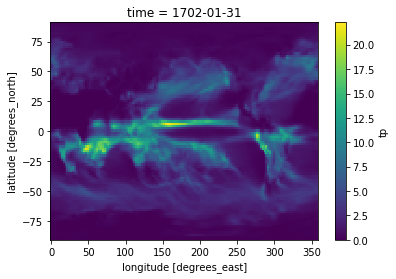

In [5]:
tp_tmon_ctrl[0].plot()

In [6]:
# #FYI, Easy month to year regridding. Date is for first of year, not mid-month.
# sst_tyr_era = sst_tmon_era.resample(time="1AS", label='left').mean('time')
# sst_tyr_era

## Create Indices for EPC1, EPC2, SAM, PSA1, PSA2, WAIS PC1, WAIS PC2, WAIS PC3, ASL Rel CP Vals, ASL Abs CP Vals, ASL CP Lons, and ASL CP Lats

### These indices will then be correlated to the field of climate anomalies in the South Pacific and surrounding land and ocean regions

## Calculate the Southern Oscillation Index
#### Using info. from https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensocycle/soi.shtml and http://www.cpc.ncep.noaa.gov/data/indices/ and http://www.cpc.ncep.noaa.gov/data/indices/Readme.index.shtml#SOICALC

#### How is the SOI Calculated?

Note the anomalies are departures from the 1981-2010 base period.

#### 1.
Standard Deviation Tahiti = SQRT( SUMMATION(1) / N )

SUMMATION(1) - is the sum of all ((TA) ** 2),
TA - Tahiti anomaly = (actual(SLP) - mean(SLP)),
N - number of months

So, Standardized Tahiti = (Actual Tahiti (SLP) - Mean Tahiti (SLP))/Standard Deviation Tahiti

#### 2.
Standard Deviation Darwin = SQRT( SUMMATION(1) / N )

SUMMATION(1) - is the sum of all ((DA) ** 2),
DA - Darwin anomaly = (actual(SLP) - mean(SLP)),
N - number of months

So, Standardized Darwin = (Actual Darwin (SLP) - Mean Darwin (SLP))/Standard Deviation Darwin

#### 3.
To calculate the monthly standard deviation:

Monthly Standard Deviation (MSD) = SQRT( SUMMATION(3) / N)

SUMMATION(3) - is the sum of ((Standardized Tahiti - Standardized Darwin) ** 2),
N - total number of summed months

The SOI equation looks as follows: SOI = (Standardized Tahiti - Standardized Darwin) / MSD 

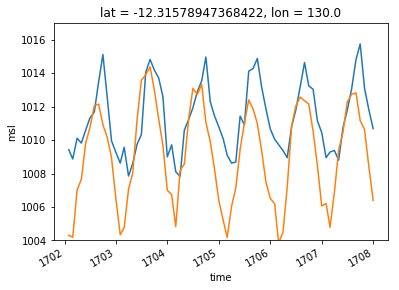

In [7]:
#params to be set

#time for pi control
time_lo     = '1702-01-31'
time_hi    = '1749-12-31' 

#Darwin and Tahiti location
#Tahiti SLP Record(17.65S, 149.43W=210.57E)
slp_tahiti_tmon_ctrl = slp_tmon_ctrl.sel(time=slice(time_lo, time_hi)).sel(lat=-17.65, lon=210.57, method='nearest')
slp_tahiti_tmon_ctrl[0:72].plot()

#Darwin SLP Record (12.46S, 130.85E)
slp_darwin_tmon_ctrl = slp_tmon_ctrl.sel(time=slice(time_lo, time_hi)).sel(lat=-12.46, lon=130.85, method='nearest')
slp_darwin_tmon_ctrl[0:72].plot()

plt.ylim([1004,1017])
plt.show()

<xarray.DataArray 'msl' ()>
array(0.958454)
Coordinates:
    lat      float64 -18.0
    lon      float64 210.0


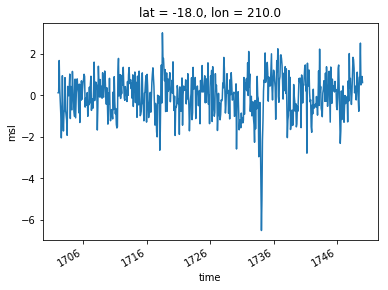

In [9]:
#Step 1
slp_tahiti_0002_0049_monthly_climatology_ctrl = slp_tahiti_tmon_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# slp_tahiti_0002_0049_monthly_climatology_ctrl.plot()
slp_tahiti_anomaly_tmon_ctrl = (slp_tahiti_tmon_ctrl.groupby('time.month') - slp_tahiti_0002_0049_monthly_climatology_ctrl)
# slp_tahiti_anomaly_tmon_ctrl.plot()
slp_tahiti_anomaly_squared_tmon_ctrl = slp_tahiti_anomaly_tmon_ctrl**(2)
slp_tahiti_anomaly_squared_sum_tmon_ctrl = slp_tahiti_anomaly_squared_tmon_ctrl.sum(axis=0)
std_tahiti = (slp_tahiti_anomaly_squared_sum_tmon_ctrl/len(slp_tahiti_tmon_ctrl.time))**(0.5)
print(std_tahiti)

standardized_tahiti = slp_tahiti_anomaly_tmon_ctrl/std_tahiti
standardized_tahiti.plot()

<xarray.DataArray 'msl' ()>
array(1.026404)
Coordinates:
    lat      float64 -12.32
    lon      float64 130.0


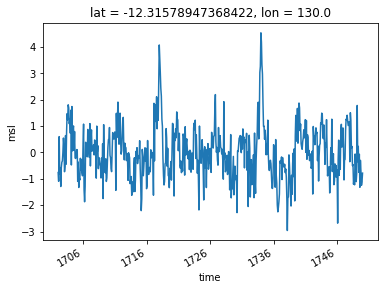

In [10]:
#Step 2
slp_darwin_0002_0049_monthly_climatology_ctrl = slp_darwin_tmon_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# slp_darwin_0002_0049_monthly_climatology_ctrl.plot()
slp_darwin_anomaly_tmon_ctrl = (slp_darwin_tmon_ctrl.groupby('time.month') - slp_darwin_0002_0049_monthly_climatology_ctrl)
# slp_darwin_anomaly_tmon_ctrl.plot()
slp_darwin_anomaly_squared_tmon_ctrl = slp_darwin_anomaly_tmon_ctrl**(2)
slp_darwin_anomaly_squared_sum_tmon_ctrl = slp_darwin_anomaly_squared_tmon_ctrl.sum(axis=0)
std_darwin = (slp_darwin_anomaly_squared_sum_tmon_ctrl/len(slp_darwin_tmon_ctrl.time))**(0.5)
print(std_darwin)

standardized_darwin = slp_darwin_anomaly_tmon_ctrl/std_darwin
standardized_darwin.plot()

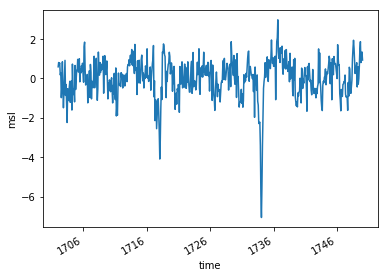

In [11]:
#Step 3
standardized_diff_squared = (standardized_tahiti - standardized_darwin)**2
monthly_std_msd = (standardized_diff_squared.sum(axis=0)/len(standardized_diff_squared.time))**(0.5)
soi_tmon_ctrl = (standardized_tahiti - standardized_darwin)/monthly_std_msd
soi_tmon_ctrl.plot()

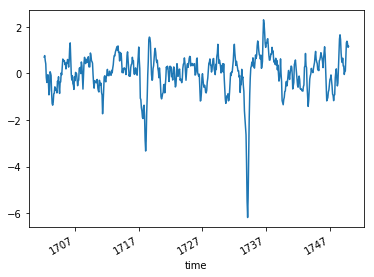

In [13]:
#With rolling mean, looks similar to https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensocycle/soi.shtml
soi_3roll_ctrl = soi_tmon_ctrl[:].rolling(time=3, min_periods=3, center=True).mean()
soi_3roll_ctrl.plot()
# plt.xlim(['0002-01-01','0017-12-31'])
plt.show()

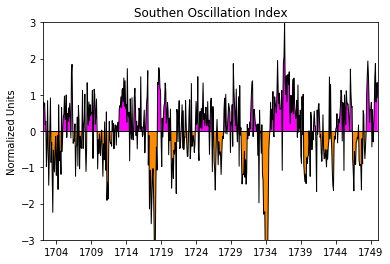

In [14]:
#SOI without 3 mon roll
fig, ax1 = plt.subplots()


sns.set_style('white')
sns.set_style('ticks',
              {'xtick.major.size':8, 'ytick.major.size':8,
               'xtick.direction': 'in', 'ytick.direction': 'in',
               'axes.linewidth':2 })
params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 3),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}



x = soi_tmon_ctrl.time.values
y1 = soi_tmon_ctrl.values  ###Check to see if I need to Multiply by -1 to get sign correct###

ax1.set_title('Southen Oscillation Index')
ax1.set_ylim(-3,3)
ax1.yaxis.set_ticks(np.arange(-3, 4, 1))
ax1.set_ylabel('Normalized Units')
ax1.set_xlim(soi_tmon_ctrl.time.values[0],soi_tmon_ctrl.time.values[len(soi_tmon_ctrl.time)-1])
ax1.plot(x, y1, color='k',linewidth=1.0)
ax1.fill_between(x, 0, y1, where=y1 > 0, facecolor='magenta')
ax1.fill_between(x, 0, y1, where=y1 < 0, facecolor='darkorange')
ax1.axhline(y=0, linewidth=1.0, color='k')

plt.show()

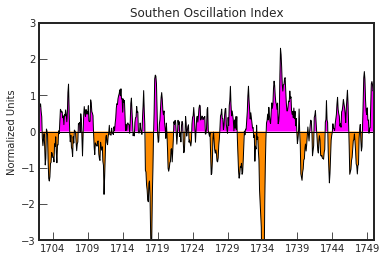

In [15]:
#SOI with 3 mon roll
fig, ax1 = plt.subplots()


sns.set_style('white')
sns.set_style('ticks',
              {'xtick.major.size':8, 'ytick.major.size':8,
               'xtick.direction': 'in', 'ytick.direction': 'in',
               'axes.linewidth':2 })
params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 3),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}



x = soi_3roll_ctrl.time.values
y1 = soi_3roll_ctrl.values  ###Check to see if I need to Multiply by -1 to get sign correct###

ax1.set_title('Southen Oscillation Index')
ax1.set_ylim(-3,3)
ax1.yaxis.set_ticks(np.arange(-3, 4, 1))
ax1.set_ylabel('Normalized Units')
ax1.set_xlim(soi_3roll_ctrl.time.values[0],soi_3roll_ctrl.time.values[len(soi_3roll_ctrl.time)-1])
ax1.plot(x, y1, color='k',linewidth=1.0)
ax1.fill_between(x, 0, y1, where=y1 > 0, facecolor='magenta')
ax1.fill_between(x, 0, y1, where=y1 < 0, facecolor='darkorange')
ax1.axhline(y=0, linewidth=1.0, color='k')

plt.show()

#With rolling mean, looks similar to https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensocycle/soi.shtml

#### Do I want to use this 3 month roll data set to create the seasonal averages and annual averages? and rolls?
I would say no.... each seasonal mean is a 3 month mean... <br> <br>
#### Save tmon, seasonals, ann, and rolls, and 2-7 band pass

In [16]:
#Finalize SOI index and put into pandas dataframE
df_soi_tmon_ctrl = pd.DataFrame(soi_tmon_ctrl.values)
df_soi_tmon_ctrl.columns = ['SOI']
df_soi_tmon_ctrl

df_time_soi_tmon_ctrl = pd.DataFrame(soi_tmon_ctrl.coords['time'].values)
df_time_soi_tmon_ctrl.columns = ['time']
df_time_soi_tmon_ctrl

soi_index_tmon_ctrl = pd.concat([df_time_soi_tmon_ctrl, df_soi_tmon_ctrl], axis=1)

soi_index_tmon_ctrl.to_pickle(PICKLE_PATH+'/ctrl_soi_tmon.pkl')

soi_index_tmon_ctrl.head(n=5)

#Note, I am not smoothing the time series by 3 months bc I end up looking at seasonal means which is essentially
#a smoothing of three months

,time,SOI
0,1702-01-31,0.585874
1,1702-02-28,0.804071
2,1702-03-31,0.714982
3,1702-04-30,0.775482
4,1702-05-31,0.177097


In [17]:
#Make time the index column so that we can use resample for seasonal means
soi_index_tmon_ctrl.time = pd.to_datetime(soi_index_tmon_ctrl.time)
soi_index_tmon_ctrl.set_index('time', inplace=True)
soi_index_tmon_ctrl

#DataFrame of SOI Index as Seasonal Means, from 1979 MAM through 2017 SON
soi_index_seas_mean_ctrl = soi_index_tmon_ctrl[2:(len(soi_index_tmon_ctrl['SOI'])-1)].resample('3MS', closed='left'  ).mean()
soi_index_seas_mean_ctrl

soi_index_seas_mean_ctrl['Seas_Index'] = soi_index_seas_mean_ctrl.index.astype(str).str[5:7]
soi_index_seas_mean_ctrl
soi_index_seas_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_soi_seas.pkl')

soi_index_seas_mean_ctrl.head(n=5)

,SOI,Seas_Index
time,,
1702-03-01,0.555854,03
1702-06-01,-0.389479,06
1702-09-01,-0.402387,09
1702-12-01,0.070651,12
1703-03-01,-0.832960,03


In [18]:
#DataFrame of SOI as annual Means, from 1979 Jan through 2017
soi_index_ann_mean_ctrl = soi_index_tmon_ctrl[:].resample('AS', closed='left'  ).mean()

soi_index_ann_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_soi_ann_mean.pkl')

soi_index_ann_mean_ctrl.head(n=5)


,SOI
time,
1702-01-01,-0.002757
1703-01-01,-0.688973
1704-01-01,-0.351686
1705-01-01,0.473203
1706-01-01,0.118120


In [19]:
#DataFrame of SOI as 12 month rolling means (centered), from 1979-2017
soi_index_12roll_ctrl = soi_index_tmon_ctrl[:].rolling(12, min_periods=12, center=True).mean()

soi_index_12roll_ctrl.to_pickle(PICKLE_PATH+'/ctrl_soi_12roll_mean.pkl')

soi_index_12roll_ctrl.head(n=10)


,SOI
time,
1702-01-31,NaN
1702-02-28,NaN
1702-03-31,NaN
1702-04-30,NaN
1702-05-31,NaN
1702-06-30,NaN
1702-07-31,-0.002757
1702-08-31,-0.050474
1702-09-30,-0.041340


In [20]:
#DataFrame of SOI as 6 month rolling means (centered), from 1979-2017
soi_index_6roll_ctrl = soi_index_tmon_ctrl[:].rolling(6, min_periods=6, center=True).mean()

soi_index_6roll_ctrl.to_pickle(PICKLE_PATH+'/ctrl_soi_6roll_mean.pkl')

soi_index_6roll_ctrl.head(n=10)


,SOI
time,
1702-01-31,NaN
1702-02-28,NaN
1702-03-31,NaN
1702-04-30,0.554554
1702-05-31,0.293418
1702-06-30,0.083187
1702-07-31,0.104082
1702-08-31,-0.117387
1702-09-30,-0.395933


In [21]:
#DataFrame of SOI as 3 month rolling means (centered), from 1979-2017
soi_index_3roll_ctrl = soi_index_tmon_ctrl[:].rolling(3, min_periods=3, center=True).mean()

soi_index_3roll_ctrl.to_pickle(PICKLE_PATH+'/ctrl_soi_3roll_mean.pkl')

soi_index_3roll_ctrl.head(n=10)


,SOI
time,
1702-01-31,NaN
1702-02-28,0.701642
1702-03-31,0.764845
1702-04-30,0.555854
1702-05-31,0.407465
1702-06-30,-0.178010
1702-07-31,-0.389479
1702-08-31,-0.199301
1702-09-30,-0.056765


**Gather the 2-7-yr band pass filter for the SOI**<br>

Evaluate findings from Gong et al., 2013 and Ding and Steig 2012, also see Mo, Yu, and Yu for more relationships between ENSO, SAM and PSA

In [22]:
# def filt_but_low(tab,cutoff,samp,btype='lowpass',N=2):
#    """Butterworth filter with
#       tab : array to be filtered (assume that first dimension is time
#       N : filter order (polynom)
#       cutoff : cutoff period in units of basic period (days, months years etc.)
#       samp : sampling rate in same units
#    """
#    # First, design the Butterworth filter
#    N  = 2
#    Wn = samp/cutoff
#    B, A = signal.butter(N, Wn,btype=btype, output='ba')
#    # Second: padding on left and right
#    L  = int(np.round(cutoff/samp))    # determine length of padding
#    M  = tab.shape[0]
#    pl = np.flipud(tab[1:L+1,...])  # padding on left
#    pr = np.flipud(tab[M-L-1:M-1,...])  # padding on right
#    tab_pad = np.zeros(tab.shape[1:])*np.ones((tab.shape[0]+2*L,1,1))
#    tab_pad = tab_pad.squeeze()
#    tab_pad[:L,...]=pl
#    tab_pad[L:M+L,...]=tab
#    tab_pad[M+L:M+2*L,...]=pr
#    # Third: apply the filter
#    tab_filt = signal.filtfilt(B,A, tab_pad,axis=0)
#    return tab_filt[L:tab_pad.shape[0]-L,...]

In [23]:
def filt_but_band(tab,cutoff_lo,cutoff_hi,samp,btype='bandpass',N=2):
   """Butterworth filter with
      tab : array to be filtered (assume that first dimension is time
      N : filter order (polynom)
      cutoff : cutoff period in units of basic period (days, months years etc.)
      samp : sampling rate in same units
   """
   # First, design the Butterworth filter
   N  = 2
   Wn_lo = samp/cutoff_lo
   Wn_hi = samp/cutoff_hi    
   B, A = signal.butter(N, (Wn_lo,Wn_hi), btype=btype, output='ba')
   # Second: padding on left and right
   L  = int(np.round(cutoff_lo/samp))    # determine length of padding
   M  = tab.shape[0]
   pl = np.flipud(tab[1:L+1,...])  # padding on left
   pr = np.flipud(tab[M-L-1:M-1,...])  # padding on right
   tab_pad = np.zeros(tab.shape[1:])*np.ones((tab.shape[0]+2*L,1,1))
   tab_pad = tab_pad.squeeze()
   tab_pad[:L,...]=pl
   tab_pad[L:M+L,...]=tab
   tab_pad[M+L:M+2*L,...]=pr
   # Third: apply the filter
   tab_filt = signal.filtfilt(B,A, tab_pad,axis=0)
   return tab_filt[L:tab_pad.shape[0]-L,...]

In [24]:
#SOI 2 to 7 yr band pass filter
soi_index_band_filt_ctrl = filt_but_band(soi_index_tmon_ctrl.SOI.values,84.,24.,1.,btype='bandpass',N=2)

#Finalize BANDPASS FILTERED SOI and put into pandas dataframE
df_soi_index_band_filt_ctrl = pd.DataFrame(soi_index_band_filt_ctrl)
df_soi_index_band_filt_ctrl.columns = ['SOI']
df_soi_index_band_filt_ctrl

df_time_soi_tmon_ctrl = pd.DataFrame(soi_tmon_ctrl.coords['time'].values)
df_time_soi_tmon_ctrl.columns = ['time']
df_time_soi_tmon_ctrl

soi_index_band_filt_ctrl = pd.concat([df_time_soi_tmon_ctrl, df_soi_index_band_filt_ctrl], axis=1)
soi_index_band_filt_ctrl.set_index('time', inplace=True)

soi_index_band_filt_ctrl.to_pickle(PICKLE_PATH+'/ctrl_soi_band_filt.pkl')

soi_index_band_filt_ctrl.head(n=5)


,SOI
time,
1702-01-31,0.152291
1702-02-28,0.150456
1702-03-31,0.143795
1702-04-30,0.132506
1702-05-31,0.116917


## Nino 3.4 Index

Niño 3.4 (5N-5S, 170W-120W):  The  Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast.  The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La  Niña events are defined when the  Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more. <br>
Nino X Index computation: (a) Compute area averaged total SST from Niño X region; (b) Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; (c) Smooth the anomalies with a 5-month running mean; (d) Normalize the smoothed values by its standard deviation over the climatological period.

In [25]:
#Define the Tropical Pacific Region for Nino3.4
nino34_xhi = 240
nino34_xlo = 190
nino34_yhi = 5 
nino34_ylo = -5  

In [26]:
#Nino3.4 area mean SST
nino34_area_mean_sst_ctrl = sst_tmon_ctrl.sel(time=slice(time_lo, time_hi),lat=slice(nino34_ylo,nino34_yhi)
                                            ,lon=slice(nino34_xlo,nino34_xhi)).mean(axis=(1,2))
# nino34_area_mean_sst_ctrl.plot()

#Nino3.4 area mean SST -Climatology just use full record
nino34_area_mean_sst_climatology_ctrl = nino34_area_mean_sst_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
nino34_area_mean_sst_anomaly_tmon_ctrl = (nino34_area_mean_sst_ctrl.groupby('time.month') - nino34_area_mean_sst_climatology_ctrl)
# nino34_area_mean_sst_anomaly_tmon_ctrl.plot()

#NOTE, not going to smooth by 5-months!
#So skip smoothing, but still normalize by standard deviation over the climatological period
nino34_area_mean_sst_anoms_std_during_climatology_ctrl = nino34_area_mean_sst_anomaly_tmon_ctrl.sel(time=slice(time_lo, time_hi)).std()
# print(nino34_area_mean_sst_anoms_std_during_climatology_ctrl)

nino34_index_tmon_ctrl = nino34_area_mean_sst_anomaly_tmon_ctrl/nino34_area_mean_sst_anoms_std_during_climatology_ctrl
# nino34_index_tmon_ctrl.std()

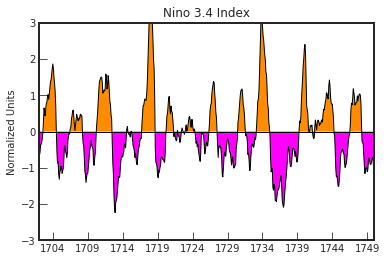

In [27]:
#Nino3.4 without 5 mon roll
fig, ax1 = plt.subplots()


sns.set_style('white')
sns.set_style('ticks',
              {'xtick.major.size':8, 'ytick.major.size':8,
               'xtick.direction': 'in', 'ytick.direction': 'in',
               'axes.linewidth':2 })
params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 3),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}



x = nino34_index_tmon_ctrl.time.values
y1 = nino34_index_tmon_ctrl.values  ###Check to see if I need to Multiply by -1 to get sign correct###

ax1.set_title('Nino 3.4 Index')
ax1.set_ylim(-3,3)
ax1.yaxis.set_ticks(np.arange(-3, 4, 1))
ax1.set_ylabel('Normalized Units')
ax1.set_xlim(nino34_index_tmon_ctrl.time.values[0],nino34_index_tmon_ctrl.time.values[len(nino34_index_tmon_ctrl.time)-1])
ax1.plot(x, y1, color='k',linewidth=1.0)
ax1.fill_between(x, 0, y1, where=y1 > 0, facecolor='darkorange')
ax1.fill_between(x, 0, y1, where=y1 < 0, facecolor='magenta')
ax1.axhline(y=0, linewidth=1.0, color='k')

plt.show()

#### Note, not using a smoothed by 5-month nino3.4 index
#### Save tmon, seasonals, ann, and rolls, and 2-7 band pass

In [28]:
#Finalize nino34 index and put into pandas dataframE
df_nino34_index_tmon_ctrl = pd.DataFrame(nino34_index_tmon_ctrl.values)
df_nino34_index_tmon_ctrl.columns = ['NINO34']
# df_nino34_index_tmon_ctrl

df_time_nino34_index_tmon_ctrl = pd.DataFrame(nino34_index_tmon_ctrl.coords['time'].values)
df_time_nino34_index_tmon_ctrl.columns = ['time']
# df_time_nino34_index_tmon_ctrl

nino34_index_tmon_ctrl = pd.concat([df_time_nino34_index_tmon_ctrl, df_nino34_index_tmon_ctrl], axis=1)

nino34_index_tmon_ctrl.to_pickle(PICKLE_PATH+'/ctrl_nino34_tmon.pkl')

nino34_index_tmon_ctrl.head(n=5)

#Note, I am not smoothing the time series by 3 months bc I end up looking at seasonal means which is essentially
#a smoothing of three months

,time,NINO34
0,1702-01-31,-0.646626
1,1702-02-28,-0.582984
2,1702-03-31,-0.371212
3,1702-04-30,-0.346450
4,1702-05-31,-0.296859


In [29]:
#Make time the index column so that we can use resample for seasonal means
nino34_index_tmon_ctrl.time = pd.to_datetime(nino34_index_tmon_ctrl.time)
nino34_index_tmon_ctrl.set_index('time', inplace=True)
nino34_index_tmon_ctrl

#DataFrame of nino34 Index as Seasonal Means, from 1979 MAM through 2017 SON
nino34_index_seas_mean_ctrl = nino34_index_tmon_ctrl[2:(len(nino34_index_tmon_ctrl['NINO34'])-1)].resample('3MS', closed='left'  ).mean()
nino34_index_seas_mean_ctrl

nino34_index_seas_mean_ctrl['Seas_Index'] = nino34_index_seas_mean_ctrl.index.astype(str).str[5:7]
nino34_index_seas_mean_ctrl
nino34_index_seas_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_nino34_seas.pkl')

nino34_index_seas_mean_ctrl.head(n=5)

,NINO34,Seas_Index
time,,
1702-03-01,-0.338174,03
1702-06-01,0.033646,06
1702-09-01,0.531159,09
1702-12-01,0.757976,12
1703-03-01,0.968345,03


In [30]:
#DataFrame of nino34 as annual Means, from 1979 Jan through 2017
nino34_index_ann_mean_ctrl = nino34_index_tmon_ctrl[:].resample('AS', closed='left'  ).mean()

nino34_index_ann_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_nino34_ann_mean.pkl')

nino34_index_ann_mean_ctrl.head(n=5)


,NINO34
time,
1702-01-01,0.010305
1703-01-01,1.231100
1704-01-01,0.051515
1705-01-01,-0.811354
1706-01-01,0.127312


In [31]:
#DataFrame of nino34 as 12 month rolling means (centered), from 1979-2017
nino34_index_12roll_ctrl = nino34_index_tmon_ctrl[:].rolling(12, min_periods=12, center=True).mean()

nino34_index_12roll_ctrl.to_pickle(PICKLE_PATH+'/ctrl_nino34_12roll_mean.pkl')

nino34_index_12roll_ctrl.head(n=10)


,NINO34
time,
1702-01-31,NaN
1702-02-28,NaN
1702-03-31,NaN
1702-04-30,NaN
1702-05-31,NaN
1702-06-30,NaN
1702-07-31,0.010305
1702-08-31,0.129432
1702-09-30,0.246152


In [32]:
#DataFrame of nino34 as 6 month rolling means (centered), from 1979-2017
nino34_index_6roll_ctrl = nino34_index_tmon_ctrl[:].rolling(6, min_periods=6, center=True).mean()

nino34_index_6roll_ctrl.to_pickle(PICKLE_PATH+'/ctrl_nino34_6roll_mean.pkl')

nino34_index_6roll_ctrl.head(n=10)

,NINO34
time,
1702-01-31,NaN
1702-02-28,NaN
1702-03-31,NaN
1702-04-30,-0.405036
1702-05-31,-0.298015
1702-06-30,-0.152264
1702-07-31,0.017944
1702-08-31,0.160916
1702-09-30,0.282402


In [37]:
#DataFrame of nino34 as 3 month rolling means (centered), from 1979-2017
nino34_index_3roll_ctrl = nino34_index_tmon_ctrl[:].rolling(3, min_periods=3, center=True).mean()

nino34_index_3roll_ctrl.to_pickle(PICKLE_PATH+'/ctrl_nino34_3roll_mean.pkl')

nino34_index_3roll_ctrl.tail(n=10)

,NINO34
time,
1749-03-31,-0.781922
1749-04-30,-0.811309
1749-05-31,-0.866912
1749-06-30,-0.893922
1749-07-31,-0.849562
1749-08-31,-0.786218
1749-09-30,-0.750449
1749-10-31,-0.850678
1749-11-30,-1.055737


**Gather the 2-7-yr band pass filter for the SOI**<br>

Evaluate findings from Gong et al., 2013 and Ding and Steig 2012, also see Mo, Yu, and Yu for more relationships between ENSO, SAM and PSA

In [34]:
# def filt_but_low(tab,cutoff,samp,btype='lowpass',N=2):
#    """Butterworth filter with
#       tab : array to be filtered (assume that first dimension is time
#       N : filter order (polynom)
#       cutoff : cutoff period in units of basic period (days, months years etc.)
#       samp : sampling rate in same units
#    """
#    # First, design the Butterworth filter
#    N  = 2
#    Wn = samp/cutoff
#    B, A = signal.butter(N, Wn,btype=btype, output='ba')
#    # Second: padding on left and right
#    L  = int(np.round(cutoff/samp))    # determine length of padding
#    M  = tab.shape[0]
#    pl = np.flipud(tab[1:L+1,...])  # padding on left
#    pr = np.flipud(tab[M-L-1:M-1,...])  # padding on right
#    tab_pad = np.zeros(tab.shape[1:])*np.ones((tab.shape[0]+2*L,1,1))
#    tab_pad = tab_pad.squeeze()
#    tab_pad[:L,...]=pl
#    tab_pad[L:M+L,...]=tab
#    tab_pad[M+L:M+2*L,...]=pr
#    # Third: apply the filter
#    tab_filt = signal.filtfilt(B,A, tab_pad,axis=0)
#    return tab_filt[L:tab_pad.shape[0]-L,...]

In [35]:
def filt_but_band(tab,cutoff_lo,cutoff_hi,samp,btype='bandpass',N=2):
   """Butterworth filter with
      tab : array to be filtered (assume that first dimension is time
      N : filter order (polynom)
      cutoff : cutoff period in units of basic period (days, months years etc.)
      samp : sampling rate in same units
   """
   # First, design the Butterworth filter
   N  = 2
   Wn_lo = samp/cutoff_lo
   Wn_hi = samp/cutoff_hi    
   B, A = signal.butter(N, (Wn_lo,Wn_hi), btype=btype, output='ba')
   # Second: padding on left and right
   L  = int(np.round(cutoff_lo/samp))    # determine length of padding
   M  = tab.shape[0]
   pl = np.flipud(tab[1:L+1,...])  # padding on left
   pr = np.flipud(tab[M-L-1:M-1,...])  # padding on right
   tab_pad = np.zeros(tab.shape[1:])*np.ones((tab.shape[0]+2*L,1,1))
   tab_pad = tab_pad.squeeze()
   tab_pad[:L,...]=pl
   tab_pad[L:M+L,...]=tab
   tab_pad[M+L:M+2*L,...]=pr
   # Third: apply the filter
   tab_filt = signal.filtfilt(B,A, tab_pad,axis=0)
   return tab_filt[L:tab_pad.shape[0]-L,...]

In [36]:
#Nino34 2 to 7 yr band pass filter
nino34_index_band_filt_ctrl = filt_but_band(nino34_index_tmon_ctrl.NINO34.values,84.,24.,1.,btype='bandpass',N=2)

#Finalize BANDPASS FILTERED SOI and put into pandas dataframE
df_nino34_index_band_filt_ctrl = pd.DataFrame(nino34_index_band_filt_ctrl)
df_nino34_index_band_filt_ctrl.columns = ['NINO34']
df_nino34_index_band_filt_ctrl

df_time_nino34_index_tmon_ctrl = pd.DataFrame(nino34_index_tmon_ctrl.index.values)
df_time_nino34_index_tmon_ctrl.columns = ['time']
df_time_nino34_index_tmon_ctrl

nino34_index_band_filt_ctrl = pd.concat([df_time_nino34_index_tmon_ctrl, df_nino34_index_band_filt_ctrl], axis=1)
nino34_index_band_filt_ctrl.set_index('time', inplace=True)

nino34_index_band_filt_ctrl.to_pickle(PICKLE_PATH+'/ctrl_nino34_band_filt.pkl')

nino34_index_band_filt_ctrl.head(n=5)


,NINO34
time,
1702-01-31,0.002719
1702-02-28,0.004163
1702-03-31,0.010608
1702-04-30,0.021827
1702-05-31,0.037445


**Calculate ENSO index (EP and CP) via EOFs and SST** <br>
Jeong (2017) A new method to classify ENSO events into eastern and central Pacific types
<br> <br>
The time series is calculated as follows:<br>
1a) Detrend Trop Pac SSTs (I added this step as I want to evaluate the dynamics, not the trend) <br>
1) Anomalies are calculated for each calender month with respect to time_low-time_high<br>
2) Calculate First two EOFs of the Tropical Pacific (20S-20N, 110E-70W) SST anoms<br>
3) Calculate the pattern correlation coefficient at each time step by finding the pearson correlation coef. of the vectorized (1D) values of the EOF1 and EOF2 maps (2D) and SST Anom maps (2D + time), these correlation coefficients are the Eastern and Central Pacific ENSO time series.<br>
4) The mean and standard deviation are adjusted to be 0 and 1, respectively, for the period 19790101-20171201, all calendar months combined. This allows for a normalized time series that can be compared to the way I calculated the SAM, PSA1, and PSA2 indices<br>
5) After smoothing by 5 months, these correlation coefficients are the Eastern and Central Pacific ENSO time series. I HAVE NOT SMOOTHED BY 5 MONTHS... NOT SURE IF I NEED TO IF I LOOK AT SEASONAL MEANS







In [7]:
#params to be set
time_lo     = '1702-01-31'
time_hi    = '1749-12-31' 

trop_pac_xhi = 290
trop_pac_xlo = 110
trop_pac_yhi = 20 
trop_pac_ylo = -20  

asl_xhi_slice = 298
asl_xlo_slice = 170
asl_yhi_slice = -59.6 #need to go a bit passed 60S to get a full grid point
asl_ylo_slice = -80

shem_xhi_slice = 362.5 #trying this, doesnt change ... still missing data from 357.5 to 360 
shem_xlo_slice = 0
shem_yhi_slice = -45
shem_ylo_slice = -90


In [8]:
#find tropical Pac ssts
sst_trop_pac_tmon_ctrl = sst_tmon_ctrl.sel(time=slice(time_lo, time_hi), lon=slice(trop_pac_xlo, trop_pac_xhi), lat=slice(trop_pac_ylo, trop_pac_yhi))
sst_trop_pac_tmon_ctrl
#sst_trop_pac_tmon_ctrl[0].plot()

<xarray.DataArray 'sst' (time: 576, lat: 22, lon: 73)>
array([[[28.10205 , 29.18637 , ..., 23.399078,       nan],
        [28.16391 , 28.810913, ..., 22.37085 ,       nan],
        ...,
        [22.510254, 22.503418, ..., 25.754944, 25.585205],
        [      nan, 22.069824, ..., 25.72995 , 25.77246 ]],

       [[28.54306 , 29.384491, ..., 23.876556,       nan],
        [28.215698, 28.79477 , ..., 22.996887,       nan],
        ...,
        [21.718628, 22.163086, ..., 25.846588, 25.43988 ],
        [      nan, 21.42096 , ..., 25.713867, 25.735352]],

       ...,

       [[24.37436 , 25.456696, ..., 23.031677,       nan],
        [25.20102 , 26.17569 , ..., 22.651306,       nan],
        ...,
        [25.52655 , 25.938263, ..., 27.479614, 27.07138 ],
        [      nan, 25.63919 , ..., 27.420776, 27.474976]],

       [[25.48526 , 27.10849 , ..., 22.697388,       nan],
        [26.129456, 27.505554, ..., 21.946594,       nan],
        ...,
        [23.089783, 23.681213, ..., 26.519165, 2

In [9]:
#Step 1a)
#Detrend Trop Pac SSTs; only can be done after filling land with 0, and use of scipy
#requires remapping back to xr dataArray and masking of the 0 points (Land)
#Returns the detrended ocean data with the land mask 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(sst_trop_pac_tmon_ctrl.fillna(0.), axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': sst_trop_pac_tmon_ctrl.coords['time'], 'lat': sst_trop_pac_tmon_ctrl.coords['lat'],'lon': sst_trop_pac_tmon_ctrl.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

sst_trop_pac_tmon_detrend_ctrl = aa2.where(aa2 != 0.00000, np.nan)
# print(10, sst_trop_pac_tmon_detrend_ctrl[0,25,11].values)
# print(11, sst_trop_pac_tmon_detrend_ctrl[0,25,33].values)
# print(12, np.count_nonzero(sst_trop_pac_tmon_detrend_ctrl[0,:,:]))
# print(13, np.count_nonzero(~np.isnan(sst_trop_pac_tmon_detrend_ctrl[0,:,:].values)))

#sst_trop_pac_tmon_detrend_ctrl[0,:,:].plot() #2D map

In [10]:
#Create SST Monthly Climatology from detrended data using data from time_lo to time_hi
sst_detrend_trop_pac_climatology_ctrl = sst_trop_pac_tmon_detrend_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
#sst_detrend_trop_pac_climatology_ctrl
# print(10, sst_detrend_trop_pac_climatology_ctrl[0,25,11].values)
# print(11, sst_detrend_trop_pac_climatology_ctrl[0,25,33].values)
# print(12, np.count_nonzero(sst_detrend_trop_pac_climatology_ctrl[0,:,:]))
# print(13, np.count_nonzero(~np.isnan(sst_detrend_trop_pac_climatology_ctrl[0,:,:].values)))

#sst_detrend_trop_pac_climatology_ctrl[:,90,24].plot()

In [11]:
#Step 1)
#Find Tropical SST Anoms using the climatology from time_lo to time_hi
sst_anoms_detrend_trop_pac_tmon_ctrl = sst_trop_pac_tmon_detrend_ctrl.groupby('time.month') - sst_detrend_trop_pac_climatology_ctrl
#sst_anoms_detrend_trop_pac_tmon_ctrl

# print(10, sst_anoms_detrend_trop_pac_tmon_ctrl[0,25,11].values)
# print(11, sst_anoms_detrend_trop_pac_tmon_ctrl[0,25,33].values)
# print(12, np.count_nonzero(sst_anoms_detrend_trop_pac_tmon_ctrl[0,:,:]))
# print(13, np.count_nonzero(~np.isnan(sst_anoms_detrend_trop_pac_tmon_ctrl[0,:,:].values)))

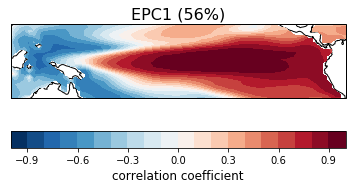

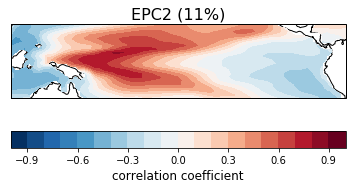

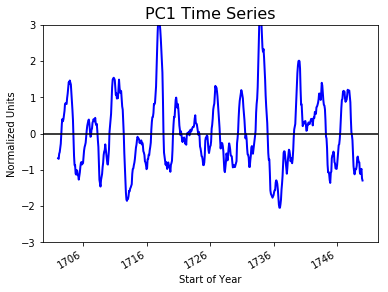

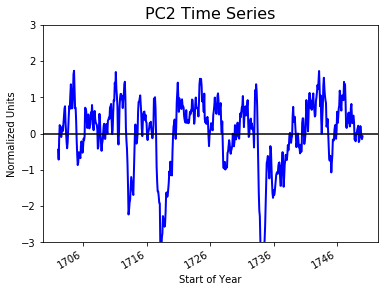

<xarray.DataArray 'variance_fractions' (mode: 2)>
array([0.55951 , 0.109271], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1
Attributes:
    long_name:  variance_fractions


In [12]:
"""
Compute and plot the First Two leading EOFs of Tropical Pacific SST anoms
Recall, sign is arbitrary, will adjust when comparing
Step 2)
"""

#current variable, needs to find and replace 8x
#sst_anoms_detrend_trop_pac_tmon_ctrl


# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst_anoms_detrend_trop_pac_tmon_ctrl.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_anoms_detrend_trop_pac_tmon_ctrl, weights=wgts)


# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input Tropical Pac SST anomalies at each grid point, and the
# leading PC time series itself.
eofs_sst_anoms_detrend_trop_pac_tmon_ctrl = solver.eofsAsCorrelation(neofs=2)
pcs_sst_anoms_detrend_trop_pac_tmon_ctrl = solver.pcs(npcs=2, pcscaling=1)


# Plot the leading EOF expressed as correlation with Tropical Pac SST Anoms
clevs = np.linspace(-1, 1, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
fill = eofs_sst_anoms_detrend_trop_pac_tmon_ctrl[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EPC1 (56%)', fontsize=16)

# Plot the leading 2nd EOF expressed as correlation with Tropical Pac SST Anoms
plt.figure()
clevs = np.linspace(-1, 1, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
fill = eofs_sst_anoms_detrend_trop_pac_tmon_ctrl[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EPC2 (11%)', fontsize=16)


# Plot the leading PC time series.
plt.figure()
pcs_sst_anoms_detrend_trop_pac_tmon_ctrl[:, 0].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)

# Plot the 2nd PC time series.
plt.figure()
pcs_sst_anoms_detrend_trop_pac_tmon_ctrl[:, 1].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC2 Time Series', fontsize=16)

plt.show()

variance_fractions = solver.varianceFraction(neigs=2)  #number of eigenvalues, ie, number of modes
print(variance_fractions)


# print(10, eofs_sst_anoms_detrend_trop_pac_tmon_ctrl[0][25,11].values)
# print(11, eofs_sst_anoms_detrend_trop_pac_tmon_ctrl[0][25,33].values)
# print(12, np.count_nonzero(eofs_sst_anoms_detrend_trop_pac_tmon_ctrl[0][:,:]))
# print(13, np.count_nonzero(~np.isnan(eofs_sst_anoms_detrend_trop_pac_tmon_ctrl[0][:,:].values)))

# print(14, eofs_sst_anoms_detrend_trop_pac_tmon_ctrl[0].coords['lon'].values)
# print(15, sst_anoms_detrend_trop_pac_tmon_ctrl.coords['lon'].values)


#print(pc1[:, 0].values)


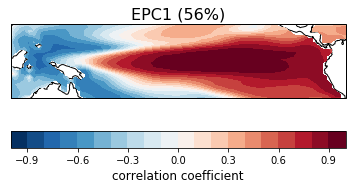

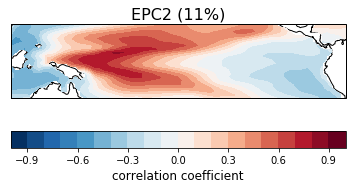

<xarray.DataArray 'variance_fractions' (mode: 2)>
array([0.55951 , 0.109271], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1
Attributes:
    long_name:  variance_fractions


In [13]:
#Plot EPC1 and ECP2 EOFs with correct sign
"""
Compute and plot the First Two leading EOFs of Tropical Pacific SST anoms
Recall, sign is arbitrary, will adjust when comparing
Step 2)
"""

#current variable, needs to find and replace 8x
#sst_anoms_detrend_trop_pac_tmon_ctrl


# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst_anoms_detrend_trop_pac_tmon_ctrl.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_anoms_detrend_trop_pac_tmon_ctrl, weights=wgts)


# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input Tropical Pac SST anomalies at each grid point, and the
# leading PC time series itself.
eofs_sst_anoms_detrend_trop_pac_tmon_ctrl = solver.eofsAsCorrelation(neofs=2)
pcs_sst_anoms_detrend_trop_pac_tmon_ctrl = solver.pcs(npcs=2, pcscaling=1)


# Plot the leading EOF expressed as correlation with Tropical Pac SST Anoms
clevs = np.linspace(-1, 1, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
fill = eofs_sst_anoms_detrend_trop_pac_tmon_ctrl[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EPC1 (56%)', fontsize=16)

# Plot the leading 2nd EOF expressed as correlation with Tropical Pac SST Anoms
plt.figure()
clevs = np.linspace(-1, 1, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
fill = eofs_sst_anoms_detrend_trop_pac_tmon_ctrl[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EPC2 (11%)', fontsize=16)


# # Plot the leading PC time series.
# plt.figure()
# pcs_sst_anoms_detrend_trop_pac_tmon_ctrl[:, 0].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC1 Time Series', fontsize=16)

# # Plot the 2nd PC time series.
# plt.figure()
# pcs_sst_anoms_detrend_trop_pac_tmon_ctrl[:, 1].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC2 Time Series', fontsize=16)

#plt.savefig(FIG_PATH+'/fig01_ctrl_epcs_eof_maps.png',bbox_inches='tight', pad_inches=0.01)

plt.show()

variance_fractions = solver.varianceFraction(neigs=2)  #number of eigenvalues, ie, number of modes
print(variance_fractions)




**Find Pattern correlation between EOF1 and EOF2 and the monthly tropical SST anomaly 2D maps. This is the EPC1 (Eastern Pacific ENSO Time Series) and EPC2 (Central Pacific ENSO Time Series). Match well with results from Joeng Fig 1, note the different time period**

To create a pattern correlation, it helps to vectorize XY coordinates into a 1D column in both the EOF maps and for every month of the Tropical Pac SST anomalies

In [14]:
#stack EOF1
eof1_stack_sst_anoms_detrend_trop_pac_tmon_ctrl = eofs_sst_anoms_detrend_trop_pac_tmon_ctrl[0].stack(xy=('lat', 'lon'))
print(eof1_stack_sst_anoms_detrend_trop_pac_tmon_ctrl.shape)
#drop nans for correlation
eof1_stack_sst_anoms_detrend_trop_pac_tmon_ctrl = eof1_stack_sst_anoms_detrend_trop_pac_tmon_ctrl[~np.isnan(eof1_stack_sst_anoms_detrend_trop_pac_tmon_ctrl)].values
#column length of stacked XY coordinate EOF1 values:
print(eof1_stack_sst_anoms_detrend_trop_pac_tmon_ctrl.shape)


(1606,)
(1460,)


In [15]:
#stack EOF2
eof2_stack_sst_anoms_detrend_trop_pac_tmon_ctrl = eofs_sst_anoms_detrend_trop_pac_tmon_ctrl[1].stack(xy=('lat', 'lon'))
print(eof2_stack_sst_anoms_detrend_trop_pac_tmon_ctrl.shape)
#drop nans for correlation
eof2_stack_sst_anoms_detrend_trop_pac_tmon_ctrl = eof2_stack_sst_anoms_detrend_trop_pac_tmon_ctrl[~np.isnan(eof2_stack_sst_anoms_detrend_trop_pac_tmon_ctrl)].values
#column length of stacked XY coordinate EOF2 values:
print(eof2_stack_sst_anoms_detrend_trop_pac_tmon_ctrl.shape)


(1606,)
(1460,)


In [16]:
#stack SST anoms
stack_of_sst_anoms_detrend_trop_pac_tmon_ctrl = sst_anoms_detrend_trop_pac_tmon_ctrl.stack(xy=('lat', 'lon')).values
print(stack_of_sst_anoms_detrend_trop_pac_tmon_ctrl.shape)
print(np.count_nonzero(~np.isnan(stack_of_sst_anoms_detrend_trop_pac_tmon_ctrl[0,:])))

#drop nans for correlation
stack_of_sst_anoms_detrend_trop_pac_tmon_ctrl = stack_of_sst_anoms_detrend_trop_pac_tmon_ctrl[~np.isnan(stack_of_sst_anoms_detrend_trop_pac_tmon_ctrl)]
print(stack_of_sst_anoms_detrend_trop_pac_tmon_ctrl.shape)

stack_of_sst_anoms_detrend_trop_pac_tmon_ctrl = np.reshape(stack_of_sst_anoms_detrend_trop_pac_tmon_ctrl, (len(pcs_sst_anoms_detrend_trop_pac_tmon_ctrl[:, 0]), len(eof1_stack_sst_anoms_detrend_trop_pac_tmon_ctrl)))
print(stack_of_sst_anoms_detrend_trop_pac_tmon_ctrl.shape)


(576, 1606)
1460
(840960,)
(576, 1460)


In [17]:
#Step 3)
#Find the pattern correlation btw EOF1 2D map and Tropical SST Anom 2D Maps 
#for each month


x = eof1_stack_sst_anoms_detrend_trop_pac_tmon_ctrl
y = stack_of_sst_anoms_detrend_trop_pac_tmon_ctrl
print(x.shape, y.shape)


#calculate the correlation of every row in a 2D array to a 1D array of the same length
#https://www.quora.com/How-do-I-calculate-the-correlation-of-every-row-in-a-2D-array-to-a-1D-array-of-the-same-length
#x is 1D, m
#y is 2D, nXm with second dimension equal in length to length of x, m


x_bar = np.mean(x)
x_intermediate = x - x_bar

y_bar = np.mean(y, axis=1) # this flattens y to be (n,) which is a 1D array. The problem is that y is n,m so numpy's broadcasting doesn't know which axis to treat as the one to broadcast over.
y_bar = y_bar[:, np.newaxis] # By adding this extra dimension, we're forcing numpy to treat the 0th axis as the one to broadcast over which makes the next step possible. y_bar is now n,1
y_intermediate = y - y_bar

numerators = y_intermediate.dot(x_intermediate) # or x_intermediate.dot(y_intermediate.T)

x_sq = np.sum(np.square(x_intermediate))

y_sqs = np.sum(np.square(y_intermediate), axis=1)

denominators = np.sqrt(x_sq * y_sqs) # scalar times vector

pearsons = (numerators/denominators) # numerators is shape (100,) and denominators is shape (100,)

eof1_and_sst_pattern_corr_coef_ctrl = pearsons
print(eof1_and_sst_pattern_corr_coef_ctrl.shape)

(1460,) (576, 1460)
(576,)


In [18]:
#Find the pattern correlation btw EOF2 2D map and Tropical SST Anom 2D Maps 
#for each month


x = eof2_stack_sst_anoms_detrend_trop_pac_tmon_ctrl
y = stack_of_sst_anoms_detrend_trop_pac_tmon_ctrl
print(x.shape, y.shape)


#calculate the correlation of every row in a 2D array to a 1D array of the same length
#https://www.quora.com/How-do-I-calculate-the-correlation-of-every-row-in-a-2D-array-to-a-1D-array-of-the-same-length
#x is 1D, m
#y is 2D, nXm with second dimension equal in length to length of x, m


x_bar = np.mean(x)
x_intermediate = x - x_bar

y_bar = np.mean(y, axis=1) # this flattens y to be (n,) which is a 1D array. The problem is that y is n,m so numpy's broadcasting doesn't know which axis to treat as the one to broadcast over.
y_bar = y_bar[:, np.newaxis] # By adding this extra dimension, we're forcing numpy to treat the 0th axis as the one to broadcast over which makes the next step possible. y_bar is now n,1
y_intermediate = y - y_bar

numerators = y_intermediate.dot(x_intermediate) # or x_intermediate.dot(y_intermediate.T)

x_sq = np.sum(np.square(x_intermediate))

y_sqs = np.sum(np.square(y_intermediate), axis=1)

denominators = np.sqrt(x_sq * y_sqs) # scalar times vector

pearsons = (numerators/denominators) # numerators is shape (100,) and denominators is shape (100,)

eof2_and_sst_pattern_corr_coef_ctrl = pearsons
print(eof2_and_sst_pattern_corr_coef_ctrl.shape)

(1460,) (576, 1460)
(576,)


In [19]:
#Step 4, normalize data to have mean of 0 and std of 1.
norm_eof1_and_sst_pattern_corr_coef_ctrl = (eof1_and_sst_pattern_corr_coef_ctrl - np.mean(eof1_and_sst_pattern_corr_coef_ctrl))/np.std(eof1_and_sst_pattern_corr_coef_ctrl)
print(np.std(eof1_and_sst_pattern_corr_coef_ctrl))
print(np.std(norm_eof1_and_sst_pattern_corr_coef_ctrl))

norm_eof2_and_sst_pattern_corr_coef_ctrl = (eof2_and_sst_pattern_corr_coef_ctrl - np.mean(eof2_and_sst_pattern_corr_coef_ctrl))/np.std(eof2_and_sst_pattern_corr_coef_ctrl)


0.5793275
1.0


In [20]:
#Finalize ENSO indices and put into pandas dataframE
#NOTE, EPC2 IS OPPOSITE SIGN TO ERA-INTERIM, SO NOT MULTIPLYING BY NEG 1
df_EPC1_ctrl = pd.DataFrame(norm_eof1_and_sst_pattern_corr_coef_ctrl)
df_EPC1_ctrl.columns = ['EPC1']
#df_EPC1_ctrl

df_EPC2_ctrl = pd.DataFrame(norm_eof2_and_sst_pattern_corr_coef_ctrl)
df_EPC2_ctrl.columns = ['EPC2']
#df_EPC2_ctrl

df_time_ctrl = pd.DataFrame(sst_anoms_detrend_trop_pac_tmon_ctrl.coords['time'].values)
df_time_ctrl.columns = ['time']
#df_time_ctrl

enso_indices_ctrl = pd.concat([df_time_ctrl, df_EPC1_ctrl, df_EPC2_ctrl], axis=1)

enso_indices_ctrl.to_pickle(PICKLE_PATH+'/ctrl_epcs_tmon.pkl')

enso_indices_ctrl.head(n=5)

#Note, I am not smoothing the time series by 5 months bc I end up looking at seasonal means which is essentially
#a smoothing of three months



,time,EPC1,EPC2
0,1702-01-31,-1.119504,-0.781847
1,1702-02-28,-1.078858,-1.246806
2,1702-03-31,-0.693790,-0.011268
3,1702-04-30,-0.622100,0.505197
4,1702-05-31,-0.764248,0.387627


In [21]:
#pd.read_pickle(PICKLE_PATH+'/ctrl_epcs_tmon.pkl')

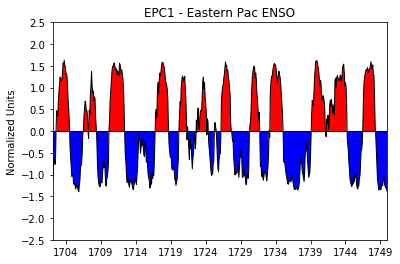

In [22]:
fig, ax1 = plt.subplots()


sns.set_style('white')
sns.set_style('ticks',
              {'xtick.major.size':8, 'ytick.major.size':8,
               'xtick.direction': 'in', 'ytick.direction': 'in',
               'axes.linewidth':2 })
params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 3),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}



x = enso_indices_ctrl.time.values
y1 = enso_indices_ctrl.EPC1.values  ###Check to see if I need to Multiply by -1 to get sign correct###

#ax1.set_xlabel('Day')
#ax1.set_ylabel('Mean SLP (hPa)')
ax1.set_title('EPC1 - Eastern Pac ENSO')
ax1.set_ylim(-2.5,2.5)
ax1.yaxis.set_ticks(np.arange(-2.5, 3, .5))
ax1.set_ylabel('Normalized Units')
ax1.set_xlim(enso_indices_ctrl.time.values[0],enso_indices_ctrl.time.values[len(enso_indices_ctrl.time)-1])
#ax1.xaxis.set_ticks(np.arange(enso_indices_ctrl.time.values[36], result.time.values[len(enso_indices_ctrl.time)-1],5))
ax1.plot(x, y1, color='k',linewidth=1.0)
ax1.fill_between(x, 0, y1, where=y1 > 0, facecolor='red')
ax1.fill_between(x, 0, y1, where=y1 < 0, facecolor='blue')
ax1.axhline(y=0, linewidth=1.0, color='k')
#ax1.axhline(y=0.79, linewidth=1.0) #Sig as defined in Joeng 2017
#ax1.axhline(y=-0.79, linewidth=1.0) #Sig as defined in Joeng 2017

plt.show()

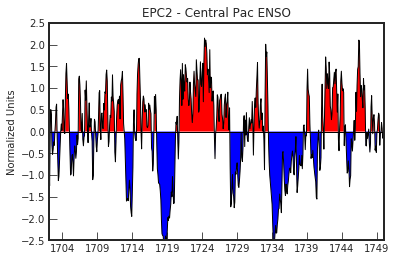

In [23]:
fig, ax1 = plt.subplots()


sns.set_style('white')
sns.set_style('ticks',
              {'xtick.major.size':8, 'ytick.major.size':8,
               'xtick.direction': 'in', 'ytick.direction': 'in',
               'axes.linewidth':2 })
params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 3),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}



x = enso_indices_ctrl.time.values
y1 = enso_indices_ctrl.EPC2.values 

#ax1.set_xlabel('Day')
#ax1.set_ylabel('Mean SLP (hPa)')
ax1.set_title('EPC2 - Central Pac ENSO')
ax1.set_ylim(-2.5,2.5)
ax1.yaxis.set_ticks(np.arange(-2.5, 3, .5))
ax1.set_ylabel('Normalized Units')
ax1.set_xlim(enso_indices_ctrl.time.values[0],enso_indices_ctrl.time.values[len(enso_indices_ctrl.time)-1])
#ax1.xaxis.set_ticks(np.arange(enso_indices_ctrl.time.values[36], enso_indices_ctrl.time.values[len(enso_indices_ctrl.time)-1],5))
ax1.plot(x, y1, color='k',linewidth=1.0)
ax1.fill_between(x, 0, y1, where=y1 > 0, facecolor='red')
ax1.fill_between(x, 0, y1, where=y1 < 0, facecolor='blue')
ax1.axhline(y=0, linewidth=1.0, color='k')
#ax1.axhline(y=0.79, linewidth=1.0) #Sig as defined in Joeng 2017
#ax1.axhline(y=-0.79, linewidth=1.0) #Sig as defined in Joeng 2017

plt.show()

**Calculate SAM and PSA1 and PSA2 indices via first 3 EOFs of Southern Hemi SLP Anoms** <br>
http://research.jisao.washington.edu/data/aao/slp/ -for SAM<br>
Also see Yu et al 2011 for definition of SAM (AAO) and PSA1 and PSA2
<br> <br>
The time series is calculated as follows:<br>
1a) Detrend the slp in the Southern Hemisphere region (South of 20S)<br>
1) SLP Anomalies are calculated for each calendar month with respect to the 00020101-00491231.  <br>
2) Each grid box is area weighted by the square root of the cosine of the central latitude.<br>
3) The covariance matrix of the area-weighted data is calculated for the grid boxes south of 20S, and the principal component (PC, timeseries ) calculated for that matrix. The first EOF is SAM, the second is PSA1 (Pacific-South American teleconnection, and third is PSA2 - see Yu et al 2011<br>
4) The mean and standard deviation are adjusted to be 0 and 1, respectively, for the period 00020101-00491231, all calendar months combined. This is a standard way to perform this calculation.<br>
**Not doing the rest:**<br>
4) The PC is correlated with global SLP anomalies, and that correlation map projected onto the data, including area weighting, to produce a time series for SAM for the entire record. (Not sure how he did this) <br>
5) The mean and standard deviation are adjusted to be 0 and 1, respectively, for the period 00020101-00491231, all calendar months combined. This is a standard way to perform this calculation.<br>

In [23]:
#params to be set
time_lo     = '1702-01-31'
time_hi    = '1749-12-31' 
# shem_xhi = 
# shem_xlo = 
shem_yhi = -20 #Had to reverse hi and lo lat values for ERA
shem_ylo = -90  #Had to reverse hi and lo lat values for ERA


In [24]:
slp_shem_tmon_ctrl = slp_tmon_ctrl.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))
#slp_shem_tmon_ctrl[0].plot()

In [25]:
#Step 1a)
#Detrend Southern Hem SLPs; use of scipy
#requires remapping back to xr dataArray 
#Returns the detrended slp data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(slp_shem_tmon_ctrl, axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': slp_shem_tmon_ctrl.coords['time'], 'lat': slp_shem_tmon_ctrl.coords['lat'],'lon': slp_shem_tmon_ctrl.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

slp_shem_tmon_detrend_ctrl = aa2

# slp_shem_tmon_detrend_ctrl[0,:,:].plot() #2D map

In [26]:
#Create SLP Monthly Climatology from detrended data using data from time_lo to time_hi
slp_detrend_shem_climatology_ctrl = slp_shem_tmon_detrend_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# slp_detrend_shem_climatology_ctrl

#slp_detrend_shem_climatology_ctrl[:,90,24].plot()

In [27]:
#Step 1)
#Find Southern Hemisphere SLP Anoms using the climatology from time_lo to time_hi
slp_anoms_shem_tmon_detrend_ctrl = slp_shem_tmon_detrend_ctrl.groupby('time.month') - slp_detrend_shem_climatology_ctrl
#slp_anoms_shem_tmon_detrend_ctrl

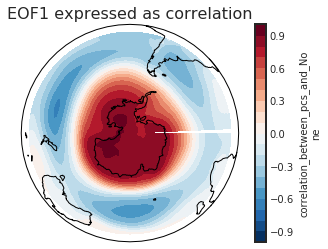

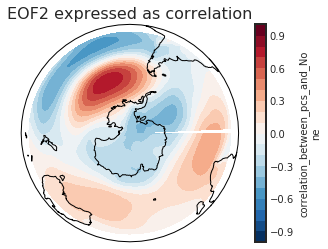

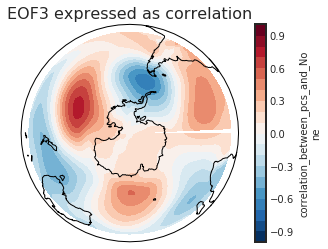

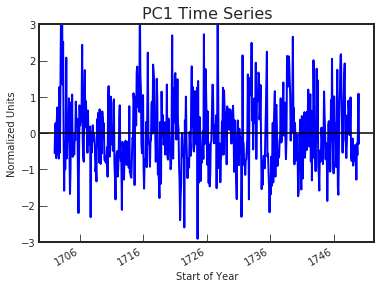

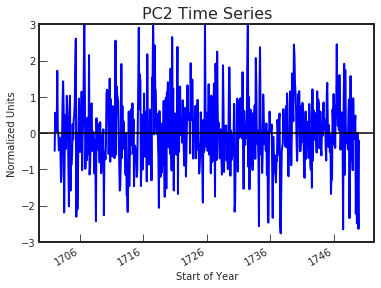

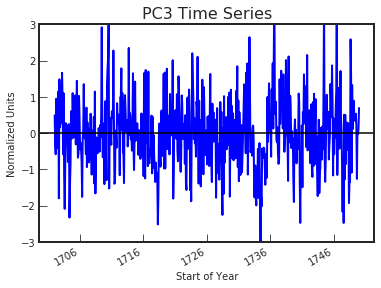

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.289937, 0.099565, 0.092364], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions


In [28]:
"""
Compute and plot the 3 leading EOF of detrended SLP anomalies south of 20S

Includes Step 2), 3)

From Marshall and Thompson 2016, look at Fig 3, from this and my work with the PSA1, PSA2, SAM, 
correlations with T2M, PSA2 needs to have sign changes in order to get proper correlation with T2M.
"""

#Step 2)
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(slp_anoms_shem_tmon_detrend_ctrl.sel(lat=slice(shem_ylo, shem_yhi)).coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(slp_anoms_shem_tmon_detrend_ctrl.sel(lat=slice(shem_ylo, shem_yhi)), weights=wgts)

#Step 3)
# Retrieve the First Three EOF, expressed as the correlation between the leading
# PC time series and the input SLP anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=3)
pc1 = solver.pcs(npcs=3, pcscaling=1)


# Plot the leading EOF expressed as correlation with SLP S of 20S
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('EOF1 expressed as correlation', fontsize=16)


# Plot the 2nd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('EOF2 expressed as correlation', fontsize=16)

# Plot the 3rd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[2].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('EOF3 expressed as correlation', fontsize=16)


# Plot the leading PC time series.
plt.figure()
pc1[:, 0].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)


# Plot the 2nd PC time series.
plt.figure()
pc1[:, 1].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC2 Time Series', fontsize=16)

# Plot the 2nd PC time series.
plt.figure()
pc1[:, 2].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC3 Time Series', fontsize=16)


plt.show()

variance_fractions = solver.varianceFraction(neigs=3)  #number of eigenvalues, ie, number of modes
print(variance_fractions)

#print(pc1[:, 0].values)

In [29]:
#Step 4, normalize to 0 mean and 1 STD (the eof method actually already did this, so not much change in the time series)
SAM_tmon_ctrl = pc1[:, 0]
norm_SAM_tmon_ctrl = (SAM_tmon_ctrl - SAM_tmon_ctrl.mean())/SAM_tmon_ctrl.std()
# print(norm_SAM_tmon_ctrl.mean(),norm_SAM_tmon_ctrl.std())

PSA1_tmon_ctrl = pc1[:, 1]
norm_PSA1_tmon_ctrl = (PSA1_tmon_ctrl - PSA1_tmon_ctrl.mean())/PSA1_tmon_ctrl.std()
# print(norm_PSA1_tmon_ctrl.mean(),norm_PSA1_tmon_ctrl.std())

PSA2_tmon_ctrl = pc1[:, 2]
norm_PSA2_tmon_ctrl = (PSA2_tmon_ctrl - PSA2_tmon_ctrl.mean())/PSA2_tmon_ctrl.std()
# print(norm_PSA2_tmon_ctrl.mean(),norm_PSA2_tmon_ctrl.std())


In [30]:
norm_SAM_tmon_ctrl

<xarray.DataArray 'pcs' (time: 576)>
array([-0.552523,  0.244968,  0.276915, ...,  0.137664,  1.088686, -0.288642])
Coordinates:
  * time     (time) datetime64[ns] 1702-01-31 1702-02-28 1702-03-31 ...
    mode     int64 0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 ...

In [31]:
#For copying to Excel: C:\Users\Paul\Desktop\Tabor\SAM_Trials_with_EOF_from_WASH_U_Definition.xlsx
series = norm_SAM_tmon_ctrl.to_series()

pd_series = pd.Series.to_frame(series)

# with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#     print(pd_series)

In [32]:
#SAM, PSA1, PSA2 indices as pandas dataframe
#NOTE, negative center over AA (eof1), positive center ASL (eof2), negative center AP (eof3)
#NOTE, SAM IS OPPOSITE SIGN TO CORRECTED ERA-INTERIM, SO CHANGING SIGN HERE

df_SAM_ctrl = pd.DataFrame(norm_SAM_tmon_ctrl.values*(-1))
df_SAM_ctrl.columns = ['SAM']
#df_SAM_ctrl

df_PSA1_ctrl = pd.DataFrame(norm_PSA1_tmon_ctrl.values)
df_PSA1_ctrl.columns = ['PSA1']
#df_PSA1_ctrl

df_PSA2_ctrl = pd.DataFrame(norm_PSA2_tmon_ctrl.values)
df_PSA2_ctrl.columns = ['PSA2']
#df_SAM_ctrl

df_time_ctrl = pd.DataFrame(norm_SAM_tmon_ctrl.coords['time'].values)
df_time_ctrl.columns = ['time']
#df_time_ctrl

SAM_PSAs_indices_ctrl = pd.concat([df_time_ctrl, df_SAM_ctrl, df_PSA1_ctrl, df_PSA2_ctrl], axis=1)

SAM_PSAs_indices_ctrl.to_pickle(PICKLE_PATH+'/ctrl_sam_psas_tmon.pkl')

SAM_PSAs_indices_ctrl.head(n=5)

,time,SAM,PSA1,PSA2
0,1702-01-31,0.552523,-0.488810,0.490068
1,1702-02-28,-0.244968,0.564329,-0.254708
2,1702-03-31,-0.276915,0.092654,-0.582532
3,1702-04-30,0.689017,0.053365,0.951142
4,1702-05-31,-0.319994,0.227353,0.709054


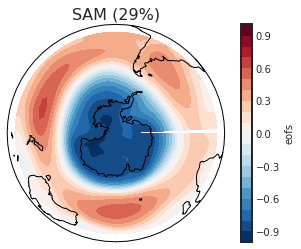

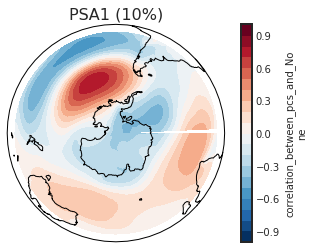

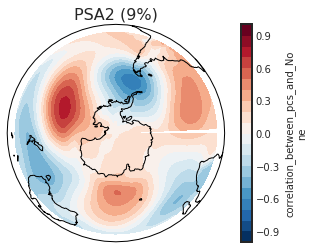

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.289937, 0.099565, 0.092364], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions


In [33]:
# PLOTTING SAM and PSA1-2 EOFs with correct sign
"""
Compute and plot the 3 leading EOF of detrended SLP anomalies south of 20S

Includes Step 2), 3)
"""

#Step 2)
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(slp_anoms_shem_tmon_detrend_ctrl.sel(lat=slice(shem_ylo, shem_yhi)).coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(slp_anoms_shem_tmon_detrend_ctrl.sel(lat=slice(shem_ylo, shem_yhi)), weights=wgts)

#Step 3)
# Retrieve the First Three EOF, expressed as the correlation between the leading
# PC time series and the input SLP anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofsAsCorrelation(neofs=3)
pc1 = solver.pcs(npcs=3, pcscaling=1)


# Plot the leading EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1_sign = eof1[0]*(-1)
eof1_sign.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('SAM (29%)', fontsize=16)


# Plot the 2nd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('PSA1 (10%)', fontsize=16)

# Plot the 3rd EOF expressed as correlation with SLP S of 20S
plt.figure()
clevs = np.linspace(-1, 1, 21)
proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
eof1[2].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                         transform=ccrs.PlateCarree(), add_colorbar=True)
ax.set_title('PSA2 (9%)', fontsize=16)


# # Plot the leading PC time series.
# plt.figure()
# pc1[:, 0].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC1 Time Series', fontsize=16)


# # Plot the 2nd PC time series.
# plt.figure()
# pc1[:, 1].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC2 Time Series', fontsize=16)

# # Plot the 2nd PC time series.
# plt.figure()
# pc1[:, 2].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Start of Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC3 Time Series', fontsize=16)

#plt.savefig(FIG_PATH+'/fig02_ctrl_sam_and_psas_eof_maps.png',bbox_inches='tight', pad_inches=0.01)

plt.show()

variance_fractions = solver.varianceFraction(neigs=3)  #number of eigenvalues, ie, number of modes
print(variance_fractions)

#print(pc1[:, 0].values)

**Now making regression and correlation of SLP anomalies onto and with SAM. Like figures from http://research.jisao.washington.edu/data/aao/slp/ **

**Regression for 2D domain:**

In [34]:
#Regression Coefficient
#Code by Brewster

# Stack lat, lon into single `xy` so we only have two dims instead of three.
slp_anoms_shem_tmon_detrend_stack_ctrl = slp_anoms_shem_tmon_detrend_ctrl.stack(xy=('lat', 'lon'))
print(slp_anoms_shem_tmon_detrend_stack_ctrl.shape)

n_time = len(slp_anoms_shem_tmon_detrend_ctrl.time)
ts = SAM_PSAs_indices_ctrl.SAM.values

# There are a couple ways to do the regression part. This is more of a bare metal linear algebra approach.
# Also see `scipy.stats.linregress` if you need something more higher 
# level/convenient. Should be faster than statsmodels.

# Build "coef matrix"
a = np.array([ts.squeeze(), np.ones(n_time)])
print(a.shape)

# I'd keep slp as the dependent variable
betas = np.linalg.lstsq(a.T, slp_anoms_shem_tmon_detrend_stack_ctrl.values)[0]

# This is what we want:
slope, intercept = betas

# Add our slope data to the stacked Dataset. Telling it that it's one dimension
#  is `xy` (i.e. our stacked latlon).
slp_anoms_shem_tmon_detrend_stack_ctrl['slope'] = (('xy'), slope)

 # Unstack `xy` back into lat, lon. Make sure girls are watching so someone can 
 # be really impressed with what you're doing.
sam_and_slp_pattern_regr_coef_ctrl = slp_anoms_shem_tmon_detrend_stack_ctrl.unstack('xy')[0]

# Plot for sanity check.
#sam_and_slp_pattern_regr_coef_ctrl[:,:].slope.plot()
#plt.show()  

# Values agree with the above point by point selection
# print(super_cool_dataset[0,110,160].slope)
# print(super_cool_dataset[0,87,116].slope)

(576, 5328)
(2, 576)


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [35]:
# #https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import AxesGrid

# def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
#     '''
#     Function to offset the "center" of a colormap. Useful for
#     data with a negative min and positive max and you want the
#     middle of the colormap's dynamic range to be at zero.

#     Input
#     -----
#       cmap : The matplotlib colormap to be altered
#       start : Offset from lowest point in the colormap's range.
#           Defaults to 0.0 (no lower offset). Should be between
#           0.0 and `midpoint`.
#       midpoint : The new center of the colormap. Defaults to 
#           0.5 (no shift). Should be between 0.0 and 1.0. In
#           general, this should be  1 - vmax / (vmax + abs(vmin))
#           For example if your data range from -15.0 to +5.0 and
#           you want the center of the colormap at 0.0, `midpoint`
#           should be set to  1 - 5/(5 + 15)) or 0.75
#       stop : Offset from highest point in the colormap's range.
#           Defaults to 1.0 (no upper offset). Should be between
#           `midpoint` and 1.0.
#     '''
#     cdict = {
#         'red': [],
#         'green': [],
#         'blue': [],
#         'alpha': []
#     }

#     # regular index to compute the colors

In [36]:
# Plot the leading EOF expressed as correlation with SLP S of 20S
# fig, ax = plt.subplots(figsize=(20, 10))



# clevs = np.linspace(-7, 2, 10)
# #clevels = [-7,-6,-5,-4,-3,-2,-1,0,1,2]

# #to create a non-monotonic colorbar that is still centered on zero
# #norm = colors.BoundaryNorm(boundaries=clevels, ncolors=256)

# proj = ccrs.Orthographic(central_longitude=270, central_latitude=-90)
# ax = plt.axes(projection=proj)
# ax.coastlines()
# ax.set_global()
# ppp = sam_and_slp_pattern_regr_coef_ctrl.slope
# ppp.plot.contourf(ax=ax, levels=clevs,  cmap=plt.cm.RdBu_r,
#                          transform=ccrs.PlateCarree(), add_colorbar=True, extend='both')
# ax.set_title('Regression of SLP Anoms onto SAM (hPa/std of index)', fontsize=16)

In [37]:
# #SLP anomaly correlations with the SAM. The SAM explains several percent of the variance in the tropics.
# #Agrees with figure from 

# x = SAM_PSAs_indices_ctrl.SAM.values
# y = slp_anoms_shem_tmon_detrend_stack_ctrl.T.values
# print(x.shape, y.shape)


# #calculate the correlation of every row in a 2D array to a 1D array of the same length
# #https://www.quora.com/How-do-I-calculate-the-correlation-of-every-row-in-a-2D-array-to-a-1D-array-of-the-same-length
# #x is 1D, m
# #y is 2D, nXm with second dimension equal in length to length of x, m


# x_bar = np.mean(x)
# x_intermediate = x - x_bar

# y_bar = np.mean(y, axis=1) # this flattens y to be (n,) which is a 1D array. The problem is that y is n,m so numpy's broadcasting doesn't know which axis to treat as the one to broadcast over.
# y_bar = y_bar[:, np.newaxis] # By adding this extra dimension, we're forcing numpy to treat the 0th axis as the one to broadcast over which makes the next step possible. y_bar is now n,1
# y_intermediate = y - y_bar

# numerators = y_intermediate.dot(x_intermediate) # or x_intermediate.dot(y_intermediate.T)

# x_sq = np.sum(np.square(x_intermediate))

# y_sqs = np.sum(np.square(y_intermediate), axis=1)

# denominators = np.sqrt(x_sq * y_sqs) # scalar times vector

# pearsons = (numerators/denominators) # numerators is shape (m,) and denominators is shape (m,)

# # Add our pearson corr coef data to the stacked Dataset. Telling it that it's one dimension
# #  is `xy` (i.e. our stacked latlon).
# slp_anoms_shem_tmon_detrend_stack_ctrl['pearsons'] = (('xy'), pearsons)

# # Unstack `xy` back into lat, lon. Make sure girls are watching so someone can 
# # be really impressed with what you're doing.
# sam_and_slp_pattern_corr_coef_ctrl = slp_anoms_shem_tmon_detrend_stack_ctrl.unstack('xy')[0]

# #plot, looks good compared to results online/published
# #sam_and_slp_pattern_corr_coef_ctrl[:,:].pearsons.plot()

In [38]:
# # Plot the leading EOF expressed as correlation with Tropical Pac SST Anoms
# fig, ax = plt.subplots(figsize=(20, 10))

# clevs = np.linspace(-1, 1, 21)
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
# fill = sam_and_slp_pattern_corr_coef_ctrl[:,:].pearsons.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
#                              add_colorbar=False, transform=ccrs.PlateCarree())
# ax.add_feature(cfeature.COASTLINE, edgecolor='k')
# cb = plt.colorbar(fill, orientation='horizontal')
# cb.set_label('correlation coefficient', fontsize=16)
# ax.set_title('SLP Anoms Correlation with SAM', fontsize=16)

**Gather the Seasonal Mean for each year for the EPC1, EPC2, SAM, PSA1, PSA2 indices**<br>
**Calculate correlations between these indices looking at the seasonal means**<br>
Evaluate findings from Gong et al., 2013 and Ding and Steig 2012, also see Mo, Yu, and Yu for more relationships between ENSO, SAM and PSA

In [39]:
#Make time the index column so that we can use resample for seasonal means
enso_indices_ctrl.time = pd.to_datetime(enso_indices_ctrl.time)
enso_indices_ctrl.set_index('time', inplace=True)
#enso_indices_ctrl

#DataFrame of ENSO Indices as Seasonal Means, from 0002 MAM through 0049 SON
enso_seas_mean_indices_ctrl = enso_indices_ctrl[2:(len(enso_indices_ctrl['EPC1'])-1)].resample('3MS', closed='left'  ).mean()
#enso_seas_mean_indices_ctrl

enso_seas_mean_indices_ctrl['Seas_Index'] = enso_seas_mean_indices_ctrl.index.astype(str).str[5:7]

enso_seas_mean_indices_ctrl.to_pickle(PICKLE_PATH+'/ctrl_epcs_seas.pkl')

enso_seas_mean_indices_ctrl.head(n=5)

,EPC1,EPC2,Seas_Index
time,,,
1702-03-01,-0.693379,0.293855,03
1702-06-01,-0.100282,-0.417128,06
1702-09-01,0.488538,-0.190907,09
1702-12-01,1.078052,0.464199,12
1703-03-01,1.177307,-0.648200,03


In [40]:
#Make time the index column so that we can use resample for seasonal means
SAM_PSAs_indices_ctrl.time = pd.to_datetime(SAM_PSAs_indices_ctrl.time)
SAM_PSAs_indices_ctrl.set_index('time', inplace=True)
#SAM_PSAs_indices_ctrl

#DataFrame of SAM and PSAs indices as Seasonal Means, from 0002 MAM through 0049 SON
SAM_PSAs_seas_mean_index_ctrl = SAM_PSAs_indices_ctrl[2:(len(SAM_PSAs_indices_ctrl['SAM'])-1)].resample('3MS', closed='left'  ).mean()
#SAM_PSAs_seas_mean_index_ctrl

#Add Seasonal index to use for groupby or sort
SAM_PSAs_seas_mean_index_ctrl['Seas_Index'] = SAM_PSAs_seas_mean_index_ctrl.index.astype(str).str[5:7]

SAM_PSAs_seas_mean_index_ctrl.to_pickle(PICKLE_PATH+'/ctrl_sam_psas_seas.pkl')

SAM_PSAs_seas_mean_index_ctrl.head(n=5)

,SAM,PSA1,PSA2,Seas_Index
time,,,,
1702-03-01,0.030703,0.124457,0.359221,03
1702-06-01,0.070400,0.590314,0.254409,06
1702-09-01,-0.012000,-0.283927,-0.049349,09
1702-12-01,-2.489342,-1.027369,0.587840,12
1703-03-01,-2.596963,0.682968,0.690788,03


**Gather the Annual Mean for the EPC1, EPC2, SAM, PSA1, PSA2 indices**<br>
**For Calculating correlations between these indices looking at the annual means**<br>
Evaluate findings from Gong et al., 2013 and Ding and Steig 2012, also see Mo, Yu, and Yu for more relationships between ENSO, SAM and PSA

In [41]:

#DataFrame of ENSO Indices as annual Means, from 0002 Jan through 0049 Dec
enso_ann_mean_indices_ctrl = enso_indices_ctrl[:].resample('AS', closed='left'  ).mean()

enso_ann_mean_indices_ctrl.to_pickle(PICKLE_PATH+'/ctrl_epcs_ann_mean.pkl')

enso_ann_mean_indices_ctrl.head(n=5)


,EPC1,EPC2
time,,
1702-01-01,-0.182636,-0.231019
1703-01-01,1.349264,-0.177312
1704-01-01,-0.006470,0.678632
1705-01-01,-1.261194,-0.657345
1706-01-01,0.018666,0.304639


In [42]:

#DataFrame of SAM and PSAs indices as annual Means, from 0002 Jan through 0049 Dec
SAM_PSAs_ann_mean_index_ctrl = SAM_PSAs_indices_ctrl[:].resample('AS', closed='left'  ).mean()

SAM_PSAs_ann_mean_index_ctrl.to_pickle(PICKLE_PATH+'/ctrl_sam_psas_ann_mean.pkl')

SAM_PSAs_ann_mean_index_ctrl.head(n=5)


,SAM,PSA1,PSA2
time,,,
1702-01-01,-0.076047,0.069676,0.189734
1703-01-01,-1.004979,-0.118165,0.058907
1704-01-01,0.148584,-0.366881,-0.330104
1705-01-01,0.209145,0.103991,0.277076
1706-01-01,-0.537889,0.336170,-0.265637


**Gather the 12-month running Mean for the EPC1, EPC2, SAM, PSA1, PSA2 indices**<br>

Evaluate findings from Gong et al., 2013 and Ding and Steig 2012, also see Mo, Yu, and Yu for more relationships between ENSO, SAM and PSA

In [43]:

#DataFrame of ENSO Indices as 12 month rolling means (centered), from 0002 Jan through 0049 Dec
enso_12roll_mean_indices_ctrl = enso_indices_ctrl[:].rolling(12, min_periods=12, center=True).mean()

enso_12roll_mean_indices_ctrl.to_pickle(PICKLE_PATH+'/ctrl_epcs_12roll_mean.pkl')

enso_12roll_mean_indices_ctrl.head(n=10)


,EPC1,EPC2
time,,
1702-01-31,NaN,NaN
1702-02-28,NaN,NaN
1702-03-31,NaN,NaN
1702-04-30,NaN,NaN
1702-05-31,NaN,NaN
1702-06-30,NaN,NaN
1702-07-31,-0.182636,-0.231019
1702-08-31,0.000354,-0.119002
1702-09-30,0.193232,0.037505


In [44]:

#DataFrame of SAM and PSAs indices as 12 month rolling means (centered), from 0002 Jan through 0049 Dec
SAM_PSAs_12roll_mean_index_ctrl = SAM_PSAs_indices_ctrl[:].rolling(12, min_periods=12, center=True).mean()

SAM_PSAs_12roll_mean_index_ctrl.to_pickle(PICKLE_PATH+'/ctrl_sam_psas_12roll_mean.pkl')

SAM_PSAs_12roll_mean_index_ctrl.head(n=10)


,SAM,PSA1,PSA2
time,,,
1702-01-31,NaN,NaN,NaN
1702-02-28,NaN,NaN,NaN
1702-03-31,NaN,NaN,NaN
1702-04-30,NaN,NaN,NaN
1702-05-31,NaN,NaN,NaN
1702-06-30,NaN,NaN,NaN
1702-07-31,-0.076047,0.069676,0.189734
1702-08-31,-0.401146,-0.002151,0.244025
1702-09-30,-0.600060,-0.149131,0.288030


**Gather the 6-month running Mean for the EPC1, EPC2, SAM, PSA1, PSA2 indices**<br>

Evaluate findings from Gong et al., 2013 and Ding and Steig 2012, also see Mo, Yu, and Yu for more relationships between ENSO, SAM and PSA

In [45]:

#DataFrame of ENSO Indices as 6 month rolling means (centered), from 0002 Jan through 0049 Dec
enso_6roll_mean_indices_ctrl = enso_indices_ctrl[:].rolling(6, min_periods=6, center=True).mean()

enso_6roll_mean_indices_ctrl.to_pickle(PICKLE_PATH+'/ctrl_epcs_6roll_mean.pkl')

enso_6roll_mean_indices_ctrl.head(n=5)


,EPC1,EPC2
time,,
1702-01-31,NaN,NaN
1702-02-28,NaN,NaN
1702-03-31,NaN,NaN
1702-04-30,-0.839374,-0.243739
1702-05-31,-0.655544,-0.200528


In [46]:

#DataFrame of SAM and PSAs indices as 6 month rolling means (centered), from 0002 Jan through 0049 Dec
SAM_PSAs_6roll_mean_index_ctrl = SAM_PSAs_indices_ctrl[:].rolling(6, min_periods=6, center=True).mean()

SAM_PSAs_6roll_mean_index_ctrl.to_pickle(PICKLE_PATH+'/ctrl_sam_psas_6roll_mean.pkl')

SAM_PSAs_6roll_mean_index_ctrl.head(n=5)


,SAM,PSA1,PSA2
time,,,
1702-01-31,NaN,NaN,NaN
1702-02-28,NaN,NaN,NaN
1702-03-31,NaN,NaN,NaN
1702-04-30,-0.051557,0.361948,0.151280
1702-05-31,-0.047439,0.454938,0.072648


**Gather the 3-month running Mean for the EPC1, EPC2, SAM, PSA1, PSA2 indices**<br>

Evaluate findings from Gong et al., 2013 and Ding and Steig 2012, also see Mo, Yu, and Yu for more relationships between ENSO, SAM and PSA

In [47]:

#DataFrame of ENSO Indices as 3 month rolling means (centered), from 0002 Jan through 0049 Dec
enso_3roll_mean_indices_ctrl = enso_indices_ctrl[:].rolling(3, min_periods=3, center=True).mean()

enso_3roll_mean_indices_ctrl.to_pickle(PICKLE_PATH+'/ctrl_epcs_3roll_mean.pkl')

enso_3roll_mean_indices_ctrl.head(n=5)


,EPC1,EPC2
time,,
1702-01-31,NaN,NaN
1702-02-28,-0.964051,-0.679971
1702-03-31,-0.798249,-0.250956
1702-04-30,-0.693379,0.293855
1702-05-31,-0.714698,0.192494


In [48]:

#DataFrame of SAM and PSAs indices as 3 month rolling means (centered), from 0002 Jan through 0049 Dec
SAM_PSAs_3roll_mean_index_ctrl = SAM_PSAs_indices_ctrl[:].rolling(3, min_periods=3, center=True).mean()

SAM_PSAs_3roll_mean_index_ctrl.to_pickle(PICKLE_PATH+'/ctrl_sam_psas_3roll_mean.pkl')

SAM_PSAs_3roll_mean_index_ctrl.head(n=5)


,SAM,PSA1,PSA2
time,,,
1702-01-31,NaN,NaN,NaN
1702-02-28,0.010213,0.056058,-0.115724
1702-03-31,0.055711,0.236783,0.037967
1702-04-30,0.030703,0.124457,0.359221
1702-05-31,-0.113328,0.667839,0.418284


**Gather the 2-7-yr band pass filter for the EPC1, EPC2, SAM, PSA1, PSA2 indices**<br>

Evaluate findings from Gong et al., 2013 and Ding and Steig 2012, also see Mo, Yu, and Yu for more relationships between ENSO, SAM and PSA

In [49]:
# def filt_but_low(tab,cutoff,samp,btype='lowpass',N=2):
#    """Butterworth filter with
#       tab : array to be filtered (assume that first dimension is time
#       N : filter order (polynom)
#       cutoff : cutoff period in units of basic period (days, months years etc.)
#       samp : sampling rate in same units
#    """
#    # First, design the Butterworth filter
#    N  = 2
#    Wn = samp/cutoff
#    B, A = signal.butter(N, Wn,btype=btype, output='ba')
#    # Second: padding on left and right
#    L  = int(np.round(cutoff/samp))    # determine length of padding
#    M  = tab.shape[0]
#    pl = np.flipud(tab[1:L+1,...])  # padding on left
#    pr = np.flipud(tab[M-L-1:M-1,...])  # padding on right
#    tab_pad = np.zeros(tab.shape[1:])*np.ones((tab.shape[0]+2*L,1,1))
#    tab_pad = tab_pad.squeeze()
#    tab_pad[:L,...]=pl
#    tab_pad[L:M+L,...]=tab
#    tab_pad[M+L:M+2*L,...]=pr
#    # Third: apply the filter
#    tab_filt = signal.filtfilt(B,A, tab_pad,axis=0)
#    return tab_filt[L:tab_pad.shape[0]-L,...]

In [50]:
def filt_but_band(tab,cutoff_lo,cutoff_hi,samp,btype='bandpass',N=2):
   """Butterworth filter with
      tab : array to be filtered (assume that first dimension is time
      N : filter order (polynom)
      cutoff : cutoff period in units of basic period (days, months years etc.)
      samp : sampling rate in same units
   """
   # First, design the Butterworth filter
   N  = 2
   Wn_lo = samp/cutoff_lo
   Wn_hi = samp/cutoff_hi    
   B, A = signal.butter(N, (Wn_lo,Wn_hi), btype=btype, output='ba')
   # Second: padding on left and right
   L  = int(np.round(cutoff_lo/samp))    # determine length of padding
   M  = tab.shape[0]
   pl = np.flipud(tab[1:L+1,...])  # padding on left
   pr = np.flipud(tab[M-L-1:M-1,...])  # padding on right
   tab_pad = np.zeros(tab.shape[1:])*np.ones((tab.shape[0]+2*L,1,1))
   tab_pad = tab_pad.squeeze()
   tab_pad[:L,...]=pl
   tab_pad[L:M+L,...]=tab
   tab_pad[M+L:M+2*L,...]=pr
   # Third: apply the filter
   tab_filt = signal.filtfilt(B,A, tab_pad,axis=0)
   return tab_filt[L:tab_pad.shape[0]-L,...]

In [51]:
#ENSO 2 to 7 yr band pass filter
epc1_band_filt_ctrl = filt_but_band(enso_indices_ctrl.EPC1.values,84.,24.,1.,btype='bandpass',N=2)
epc2_band_filt_ctrl = filt_but_band(enso_indices_ctrl.EPC2.values,84.,24.,1.,btype='bandpass',N=2)

#Finalize BANDPASS FILTERED ENSO indices and put into pandas dataframE
#NOTE, Sign taken care of earlier
df_EPC1_band_filt_ctrl = pd.DataFrame(epc1_band_filt_ctrl)
df_EPC1_band_filt_ctrl.columns = ['EPC1']
#df_EPC1_band_filt_ctrl

df_EPC2_band_filt_ctrl = pd.DataFrame(epc2_band_filt_ctrl)
df_EPC2_band_filt_ctrl.columns = ['EPC2']
#df_EPC2_band_filt_ctrl

# df_time_ctrl = pd.DataFrame(sst_anoms_detrend_trop_pac_tmon_ctrl.coords['time'].values)
# df_time_ctrl.columns = ['time']
# #df_time_ctrl

enso_indices_band_filt_ctrl = pd.concat([df_time_ctrl, df_EPC1_band_filt_ctrl, df_EPC2_band_filt_ctrl], axis=1)
enso_indices_band_filt_ctrl.set_index('time', inplace=True)

enso_indices_band_filt_ctrl.to_pickle(PICKLE_PATH+'/ctrl_epcs_band_filt.pkl')

enso_indices_band_filt_ctrl.head(n=5)


,EPC1,EPC2
time,,
1702-01-31,-0.023169,-0.238423
1702-02-28,-0.021066,-0.237990
1702-03-31,-0.012640,-0.235531
1702-04-30,0.001798,-0.231140
1702-05-31,0.021748,-0.224928


In [52]:
# #test EPCs bandpass filter
# plt.figure(figsize=(20,10))

# plt.subplot(2,1,1)
# plt.plot(enso_indices_ctrl.EPC1.values)
# plt.plot(enso_indices_band_filt_ctrl.EPC1.values)

# plt.subplot(2,1,2)
# plt.plot(enso_indices_ctrl.EPC2.values)
# plt.plot(enso_indices_band_filt_ctrl.EPC2.values)

# plt.show()

In [53]:
#SAM and PSAs 2 to 7 yr band pass filter
psa1_band_filt_ctrl = filt_but_band(SAM_PSAs_indices_ctrl.PSA1.values,84.,24.,1.,btype='bandpass',N=2)
psa2_band_filt_ctrl = filt_but_band(SAM_PSAs_indices_ctrl.PSA2.values,84.,24.,1.,btype='bandpass',N=2)
sam_band_filt_ctrl  = filt_but_band(SAM_PSAs_indices_ctrl.SAM.values,84.,24.,1.,btype='bandpass',N=2)

#Finalize BANDPASS FILTERED SAM and PSAs indices and put into pandas dataframE
#NOTE, Sign taken care of earlier
df_PSA1_band_filt_ctrl = pd.DataFrame(psa1_band_filt_ctrl)
df_PSA1_band_filt_ctrl.columns = ['PSA1']
#df_PSA1_band_filt_ctrl

df_PSA2_band_filt_ctrl = pd.DataFrame(psa2_band_filt_ctrl)
df_PSA2_band_filt_ctrl.columns = ['PSA2']
#df_PSA2_band_filt_ctrl

df_SAM_band_filt_ctrl = pd.DataFrame(sam_band_filt_ctrl)
df_SAM_band_filt_ctrl.columns = ['SAM']
#df_SAM_band_filt_ctrl

# df_time_ctrl = pd.DataFrame(sst_anoms_detrend_trop_pac_tmon_ctrl.coords['time'].values)
# df_time_ctrl.columns = ['time']
# #df_time_ctrl

SAM_PSAs_indices_band_filt_ctrl = pd.concat([df_time_ctrl, df_SAM_band_filt_ctrl, df_PSA1_band_filt_ctrl, df_PSA2_band_filt_ctrl], axis=1)
SAM_PSAs_indices_band_filt_ctrl.set_index('time', inplace=True)

SAM_PSAs_indices_band_filt_ctrl.to_pickle(PICKLE_PATH+'/ctrl_sam_psas_band_filt.pkl')

SAM_PSAs_indices_band_filt_ctrl.head(n=5)

,SAM,PSA1,PSA2
time,,,
1702-01-31,-0.184919,0.006663,0.322147
1702-02-28,-0.185232,0.006141,0.320516
1702-03-31,-0.186139,0.003626,0.316666
1702-04-30,-0.187539,-0.000833,0.310595
1702-05-31,-0.189261,-0.007151,0.302306


In [54]:
# #test SAM and PSAs bandpass filter
# plt.figure(figsize=(20,18))

# plt.subplot(3,1,1)
# plt.plot(SAM_PSAs_indices_ctrl.SAM.values)
# plt.plot(SAM_PSAs_indices_band_filt_ctrl.SAM.values)

# plt.subplot(3,1,2)
# plt.plot(SAM_PSAs_indices_ctrl.PSA1.values)
# plt.plot(SAM_PSAs_indices_band_filt_ctrl.PSA1.values)

# plt.subplot(3,1,3)
# plt.plot(SAM_PSAs_indices_ctrl.PSA2.values)
# plt.plot(SAM_PSAs_indices_band_filt_ctrl.PSA2.values)

# plt.show()

In [55]:
# #verifying that bandpass code works with 3d data
# slp_anoms_shem_tmon_detrend_ctrl
# slp_anoms_shem_tmon_detrend_ctrl[:,30,100].plot()

In [56]:
# #works with 3D data :)
# band_filt = filt_but_band(slp_anoms_shem_tmon_detrend_ctrl,84.,24.,1.,btype='bandpass',N=2)
# plt.figure(figsize=(20,10))
# plt.plot(slp_anoms_shem_tmon_detrend_ctrl[:,30,100].values)
# plt.plot(band_filt[:,30,100])
# plt.show()

### Detrending, removing climatology, and normalizing (in time) the d18O variable (for the psuedoWDC core, and the west and east psuedo core and also for WAIS PCs). This method allows for correlations with the detrended, anomalies, normalized indices

In [57]:
#params to be set
time_lo     = '1702-01-31'
time_hi    = '1749-12-31' 
# shem_xhi = 
# shem_xlo = 
shem_yhi = -20 #Had to reverse hi and lo lat values for ERA
shem_ylo = -90  #Had to reverse hi and lo lat values for ERA


In [58]:
d18O_shem_tmon_ctrl = d18O_tmon_ctrl.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))

#Detrend Southern Hem d18O; use of scipy
#has some missing values, need to fill those with zeros 
#requires remapping back to xr dataArray 
#Returns the detrended d18O data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(d18O_shem_tmon_ctrl.fillna(0.), axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': d18O_shem_tmon_ctrl.coords['time'], 'lat': d18O_shem_tmon_ctrl.coords['lat'],'lon': d18O_shem_tmon_ctrl.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

d18O_shem_tmon_detrend_ctrl = aa2.where(aa2 != 0.00000, np.nan)

#Create d18O Monthly Climatology from detrended data using data from time_lo to time_hi
d18O_detrend_shem_climatology_ctrl = d18O_shem_tmon_detrend_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# d18O_detrend_shem_climatology_ctrl

#Find Southern Hemisphere d18O Anoms using the climatology from time_lo to time_hi
d18O_anoms_shem_tmon_detrend_ctrl = d18O_shem_tmon_detrend_ctrl.groupby('time.month') - d18O_detrend_shem_climatology_ctrl

#Normalize Southern Hemisphere d18O Anoms (from detrended data)
d18O_anoms_shem_tmon_detrend_norm_ctrl = (d18O_anoms_shem_tmon_detrend_ctrl - d18O_anoms_shem_tmon_detrend_ctrl.mean(dim='time'))/d18O_anoms_shem_tmon_detrend_ctrl.std(dim='time')
# d18O_anoms_shem_tmon_detrend_norm_ctrl


In [59]:
# d18O_detrend_shem_climatology_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').plot()

In [60]:
# d18O_NOT_detrend_shem_climatology_ctrl = d18O_shem_tmon_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# psuedoWDC_d18O_NOT_detrend_shem_climatology_ctrl = pd.DataFrame(d18O_NOT_detrend_shem_climatology_ctrl.sel(lat=-78.63, lon=247.5, method='nearest').values,columns=['d18O'])
# psuedoWDC_d18O_NOT_detrend_shem_climatology_ctrl
# psuedoWDC_d18O_NOT_detrend_shem_climatology_ctrl.plot(title='iCESM d18O of Precip at WAIS WDC Location-Climatology')

In [61]:
#Location info for WDC Core... select a similar point in iCESM and run the correlation analyses
#     Site_Information
#     Site_Name: WDC06A
#     Location: Antarctica
#     Country: 
#     Northernmost_Latitude: -79.46
#     Southernmost_Latitude: -79.46
#     Easternmost_Longitude: -112.09 = 247.91E
#     Westernmost_Longitude: -112.09 = 247.91E
#     Elevation: 1806 m

#Selected Psuedo WDC core in model to be located at lat=-78.63, lon=247.5, method='nearest'
#Also picked a western psuedo core to be located at lat=-78.63, lon=225, method='nearest'
#Also picked a eastern psuedo core to be located at lat=-78.63, lon=270, method='nearest'

In [62]:
# print(d18O_tmon_ctrl.coords['lat'],d18O_tmon_ctrl.coords['lon'])

In [63]:
#Psuedo Core from the normalized detrended d18O anomalies
d18O_psuedoWDC_tmon_ctrl = d18O_anoms_shem_tmon_detrend_norm_ctrl.sel(lat=-78.63, lon=247.5, method='nearest')
# d18O_psuedoWDC_tmon_ctrl

In [64]:
#Psuedo WDC d18O core in iCESM put into pandas dataframe
df_d18O_psuedoWDC_tmon_ctrl = pd.DataFrame(d18O_psuedoWDC_tmon_ctrl.values)
df_d18O_psuedoWDC_tmon_ctrl.columns = ['d18O']

df_d18O_psuedoWDC_tmon_ctrl.set_index(d18O_psuedoWDC_tmon_ctrl['time'].values, inplace=True, drop=True)

df_d18O_psuedoWDC_tmon_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedoWDC_tmon.pkl')

df_d18O_psuedoWDC_tmon_ctrl.head(n=5)



,d18O
1702-01-31,-0.212773
1702-02-28,0.367206
1702-03-31,1.028515
1702-04-30,-1.121103
1702-05-31,-0.130780


In [65]:
# df_d18O_psuedoWDC_tmon_ctrl.d18O.plot.line(color='b')

In [66]:
#DataFrame of psuedo d18O wdc as Seasonal Means, from 0002 MAM through 0049 SON
#USING NORMALIZED DETRENDED d18O ANOMALY DATA
d18O_psuedoWDC_seas_ctrl = df_d18O_psuedoWDC_tmon_ctrl[2:(len(df_d18O_psuedoWDC_tmon_ctrl.index)-1)].resample('3MS', closed='left'  ).mean()

d18O_psuedoWDC_seas_ctrl['Seas_Index'] = d18O_psuedoWDC_seas_ctrl.index.astype(str).str[5:7]

d18O_psuedoWDC_seas_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedoWDC_seas.pkl')

d18O_psuedoWDC_seas_ctrl.head(n=5)



,d18O,Seas_Index
1702-03-01,-0.074456,03
1702-06-01,0.800583,06
1702-09-01,-1.069495,09
1702-12-01,0.286901,12
1703-03-01,-0.043612,03


In [67]:
#DataFrame of psuedo d18O wdc as annual Means, from 0002 Jan through 0049 Dec
#Use normalized detrended d18O anomaly data
d18O_psuedoWDC_ann_mean_ctrl = df_d18O_psuedoWDC_tmon_ctrl[:].resample('AS', closed='left'  ).mean()

d18O_psuedoWDC_ann_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedoWDC_ann_mean.pkl')

d18O_psuedoWDC_ann_mean_ctrl.head(n=5)


,d18O
1702-01-01,-0.025119
1703-01-01,-0.179444
1704-01-01,0.308515
1705-01-01,-0.213336
1706-01-01,-0.178289


In [68]:
#DataFrame of psuedo d18O wdc as 12 month rolling mean, from 0002 Jan through 0049 Dec
#Use normalized detrended d18O anomaly data
d18O_psuedoWDC_12roll_mean_ctrl = df_d18O_psuedoWDC_tmon_ctrl[:].rolling(12, min_periods=12, center=True).mean()

d18O_psuedoWDC_12roll_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedoWDC_12roll_mean.pkl')

d18O_psuedoWDC_12roll_mean_ctrl.head(n=10)


,d18O
1702-01-31,NaN
1702-02-28,NaN
1702-03-31,NaN
1702-04-30,NaN
1702-05-31,NaN
1702-06-30,NaN
1702-07-31,-0.025119
1702-08-31,0.041493
1702-09-30,-0.014117
1702-10-31,-0.188177


In [69]:
#DataFrame of psuedo d18O wdc as 6 month rolling mean, from 0002 Jan through 0049 Dec
#Use normalized detrended d18O anomaly data
d18O_psuedoWDC_6roll_mean_ctrl = df_d18O_psuedoWDC_tmon_ctrl[:].rolling(6, min_periods=6, center=True).mean()

d18O_psuedoWDC_6roll_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedoWDC_6roll_mean.pkl')

d18O_psuedoWDC_6roll_mean_ctrl.head(n=5)

,d18O
1702-01-31,NaN
1702-02-28,NaN
1702-03-31,NaN
1702-04-30,0.242333
1702-05-31,0.333168


In [70]:
#DataFrame of psuedo d18O wdc as 3 month rolling mean, from 0002 Jan through 0049 Dec
#Use normalized detrended d18O anomaly data
d18O_psuedoWDC_3roll_mean_ctrl = df_d18O_psuedoWDC_tmon_ctrl[:].rolling(3, min_periods=3, center=True).mean()

d18O_psuedoWDC_3roll_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedoWDC_3roll_mean.pkl')

d18O_psuedoWDC_3roll_mean_ctrl.head(n=5)

,d18O
1702-01-31,NaN
1702-02-28,0.394316
1702-03-31,0.091539
1702-04-30,-0.074456
1702-05-31,0.090350


In [71]:
#psuedo WDC core central 2 to 7 yr band pass filter
psuedoWDC_band_filt_ctrl = filt_but_band(df_d18O_psuedoWDC_tmon_ctrl.d18O.values,84.,24.,1.,btype='bandpass',N=2)

#Finalize BANDPASS FILTERED d18O psuedocore central and put into pandas dataframE
df_d18O_psuedoWDC_band_filt_ctrl = pd.DataFrame(psuedoWDC_band_filt_ctrl)
df_d18O_psuedoWDC_band_filt_ctrl.columns = ['d18O']
#df_d18O_psuedoWDC_band_filt_ctrl

# df_time_ctrl = pd.DataFrame(sst_anoms_detrend_trop_pac_tmon_ctrl.coords['time'].values)
# df_time_ctrl.columns = ['time']
# #df_time_ctrl

d18O_psuedoWDC_band_filt_ctrl = pd.concat([df_time_ctrl, df_d18O_psuedoWDC_band_filt_ctrl], axis=1)
d18O_psuedoWDC_band_filt_ctrl.set_index('time', inplace=True)

d18O_psuedoWDC_band_filt_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedoWDC_band_filt.pkl')

d18O_psuedoWDC_band_filt_ctrl.head(n=5)


,d18O
time,
1702-01-31,0.067179
1702-02-28,0.067772
1702-03-31,0.068201
1702-04-30,0.068490
1702-05-31,0.068674


In [72]:
# #test psuedoWDC central bandpass filter
# plt.figure(figsize=(12,10))

# plt.subplot(2,1,1)
# plt.plot(df_d18O_psuedoWDC_tmon_ctrl.d18O.values)
# plt.plot(d18O_psuedoWDC_band_filt_ctrl.d18O.values)

# plt.show()

In [73]:
#psuedowestcore from the normalized detrended d18O anomalies
d18O_psuedowestcore_tmon_ctrl = d18O_anoms_shem_tmon_detrend_norm_ctrl.sel(lat=-78.63, lon=225, method='nearest')
# d18O_psuedowestcore_tmon_ctrl

In [74]:
#psuedowestcore in iCESM put into pandas dataframe
df_d18O_psuedowestcore_tmon_ctrl = pd.DataFrame(d18O_psuedowestcore_tmon_ctrl.values)
df_d18O_psuedowestcore_tmon_ctrl.columns = ['d18O']

df_d18O_psuedowestcore_tmon_ctrl.set_index(d18O_psuedowestcore_tmon_ctrl['time'].values, inplace=True, drop=True)

df_d18O_psuedowestcore_tmon_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedowestcore_tmon.pkl')

df_d18O_psuedowestcore_tmon_ctrl.head(n=5)



,d18O
1702-01-31,0.850267
1702-02-28,0.193164
1702-03-31,0.179087
1702-04-30,-0.935863
1702-05-31,-1.503387


In [75]:
# df_d18O_psuedowestcore_tmon_ctrl.d18O.plot.line(color='b')

In [76]:
#DataFrame of psuedowestcore as Seasonal Means, from 0002 MAM through 0049 SON
#USING NORMALIZED DETRENDED d18O ANOMALY DATA
d18O_psuedowestcore_seas_ctrl = df_d18O_psuedowestcore_tmon_ctrl[2:(len(df_d18O_psuedowestcore_tmon_ctrl.index)-1)].resample('3MS', closed='left'  ).mean()


d18O_psuedowestcore_seas_ctrl['Seas_Index'] = d18O_psuedowestcore_seas_ctrl.index.astype(str).str[5:7]

d18O_psuedowestcore_seas_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedowestcore_seas.pkl')

d18O_psuedowestcore_seas_ctrl.head(n=5)

,d18O,Seas_Index
1702-03-01,-0.753388,03
1702-06-01,0.914655,06
1702-09-01,-1.222005,09
1702-12-01,0.477620,12
1703-03-01,1.170745,03


In [77]:
#DataFrame of psuedowestcore as annual Means, from 0002 Jan through 0049 Dec
#Use normalized detrended d18O anomaly data
d18O_psuedowestcore_ann_mean_ctrl = df_d18O_psuedowestcore_tmon_ctrl[:].resample('AS', closed='left'  ).mean()

d18O_psuedowestcore_ann_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedowestcore_ann_mean.pkl')

d18O_psuedowestcore_ann_mean_ctrl.head(n=5)


,d18O
1702-01-01,-0.096721
1703-01-01,0.415620
1704-01-01,-0.084907
1705-01-01,-0.149530
1706-01-01,0.475636


In [78]:
#DataFrame of psuedowestcore as 12 month rolling mean, from 0002 Jan through 0049 Dec
#Use normalized detrended d18O anomaly data
d18O_psuedowestcore_12roll_mean_ctrl = df_d18O_psuedowestcore_tmon_ctrl[:].rolling(12, min_periods=12, center=True).mean()

d18O_psuedowestcore_12roll_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedowestcore_12roll_mean.pkl')

d18O_psuedowestcore_12roll_mean_ctrl.head(n=10)


,d18O
1702-01-31,NaN
1702-02-28,NaN
1702-03-31,NaN
1702-04-30,NaN
1702-05-31,NaN
1702-06-30,NaN
1702-07-31,-0.096721
1702-08-31,-0.128393
1702-09-30,-0.145779
1702-10-31,-0.109413


In [79]:
#DataFrame of psuedowestcore as 6 month rolling mean, from 0002 Jan through 0049 Dec
#Use normalized detrended d18O anomaly data
d18O_psuedowestcore_6roll_mean_ctrl = df_d18O_psuedowestcore_tmon_ctrl[:].rolling(6, min_periods=6, center=True).mean()

d18O_psuedowestcore_6roll_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedowestcore_6roll_mean.pkl')

d18O_psuedowestcore_6roll_mean_ctrl.head(n=5)

,d18O
1702-01-31,NaN
1702-02-28,NaN
1702-03-31,NaN
1702-04-30,-0.087040
1702-05-31,-0.102543


In [80]:
#DataFrame of psuedowestcore as 3 month rolling mean, from 0002 Jan through 0049 Dec
#Use normalized detrended d18O anomaly data
d18O_psuedowestcore_3roll_mean_ctrl = df_d18O_psuedowestcore_tmon_ctrl[:].rolling(3, min_periods=3, center=True).mean()

d18O_psuedowestcore_3roll_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedowestcore_3roll_mean.pkl')

d18O_psuedowestcore_3roll_mean_ctrl.head(n=5)

,d18O
1702-01-31,NaN
1702-02-28,0.407506
1702-03-31,-0.187871
1702-04-30,-0.753388
1702-05-31,-0.581586


In [81]:
#psuedowestcore 2 to 7 yr band pass filter
psuedowestcore_band_filt_ctrl = filt_but_band(df_d18O_psuedowestcore_tmon_ctrl.d18O.values,84.,24.,1.,btype='bandpass',N=2)

#Finalize BANDPASS FILTERED d18O psuedowestcore and put into pandas dataframE
df_d18O_psuedowestcore_band_filt_ctrl = pd.DataFrame(psuedowestcore_band_filt_ctrl)
df_d18O_psuedowestcore_band_filt_ctrl.columns = ['d18O']
#df_d18O_psuedowestcore_band_filt_ctrl

# df_time_ctrl = pd.DataFrame(sst_anoms_detrend_trop_pac_tmon_ctrl.coords['time'].values)
# df_time_ctrl.columns = ['time']
# #df_time_ctrl

d18O_psuedowestcore_band_filt_ctrl = pd.concat([df_time_ctrl, df_d18O_psuedowestcore_band_filt_ctrl], axis=1)
d18O_psuedowestcore_band_filt_ctrl.set_index('time', inplace=True)

d18O_psuedowestcore_band_filt_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedowestcore_band_filt.pkl')

d18O_psuedowestcore_band_filt_ctrl.head(n=5)


,d18O
time,
1702-01-31,-0.238572
1702-02-28,-0.236556
1702-03-31,-0.233546
1702-04-30,-0.229534
1702-05-31,-0.224545


In [82]:
# #test psuedowestcore bandpass filter
# plt.figure(figsize=(12,10))

# plt.subplot(2,1,1)
# plt.plot(df_d18O_psuedowestcore_tmon_ctrl.d18O.values)
# plt.plot(d18O_psuedowestcore_band_filt_ctrl.d18O.values)

# plt.show()

In [83]:
#psuedoeastcore from the normalized detrended d18O anomalies
d18O_psuedoeastcore_tmon_ctrl = d18O_anoms_shem_tmon_detrend_norm_ctrl.sel(lat=-78.63, lon=270, method='nearest')
d18O_psuedoeastcore_tmon_ctrl

<xarray.DataArray (time: 576)>
array([ 0.091033,  0.239095,  0.778919, ...,  0.507518,  0.028061, -1.734831],
      dtype=float32)
Coordinates:
    lat      float64 -78.63
    lon      float64 270.0
  * time     (time) datetime64[ns] 1702-01-31 1702-02-28 1702-03-31 ...
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 ...

In [84]:
#psuedoeastcore in iCESM put into pandas dataframe
df_d18O_psuedoeastcore_tmon_ctrl = pd.DataFrame(d18O_psuedoeastcore_tmon_ctrl.values)
df_d18O_psuedoeastcore_tmon_ctrl.columns = ['d18O']

df_d18O_psuedoeastcore_tmon_ctrl.set_index(d18O_psuedoeastcore_tmon_ctrl['time'].values, inplace=True, drop=True)

df_d18O_psuedoeastcore_tmon_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedoeastcore_tmon.pkl')

df_d18O_psuedoeastcore_tmon_ctrl.head(n=5)



,d18O
1702-01-31,0.091033
1702-02-28,0.239095
1702-03-31,0.778919
1702-04-30,-0.965519
1702-05-31,0.598564


In [85]:
# df_d18O_psuedoeastcore_tmon_ctrl.d18O.plot.line(color='b')

In [86]:
#DataFrame of psuedoeastcore as Seasonal Means, from 0002 MAM through 0049 SON
#USING NORMALIZED DETRENDED d18O ANOMALY DATA
d18O_psuedoeastcore_seas_ctrl = df_d18O_psuedoeastcore_tmon_ctrl[2:(len(df_d18O_psuedoeastcore_tmon_ctrl.index)-1)].resample('3MS', closed='left'  ).mean()


d18O_psuedoeastcore_seas_ctrl['Seas_Index'] = d18O_psuedoeastcore_seas_ctrl.index.astype(str).str[5:7]

d18O_psuedoeastcore_seas_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedoeastcore_seas.pkl')

d18O_psuedoeastcore_seas_ctrl.head(n=5)

,d18O,Seas_Index
1702-03-01,0.137321,03
1702-06-01,0.665230,06
1702-09-01,-0.635913,09
1702-12-01,0.872450,12
1703-03-01,0.438358,03


In [87]:
#DataFrame of psuedoeastcore as annual Means, from 0002 Jan through 0049 Dec
#Use normalized detrended d18O anomaly data
d18O_psuedoeastcore_ann_mean_ctrl = df_d18O_psuedoeastcore_tmon_ctrl[:].resample('AS', closed='left'  ).mean()

d18O_psuedoeastcore_ann_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedoeastcore_ann_mean.pkl')

d18O_psuedoeastcore_ann_mean_ctrl.head(n=5)


,d18O
1702-01-01,0.169002
1703-01-01,0.368261
1704-01-01,0.446299
1705-01-01,-0.473919
1706-01-01,-0.039935


In [88]:
#DataFrame of psuedoeastcore as 12 month rolling mean, from 0002 Jan through 0049 Dec
#Use normalized detrended d18O anomaly data
d18O_psuedoeastcore_12roll_mean_ctrl = df_d18O_psuedoeastcore_tmon_ctrl[:].rolling(12, min_periods=12, center=True).mean()

d18O_psuedoeastcore_12roll_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedoeastcore_12roll_mean.pkl')

d18O_psuedoeastcore_12roll_mean_ctrl.head(n=10)


,d18O
1702-01-31,NaN
1702-02-28,NaN
1702-03-31,NaN
1702-04-30,NaN
1702-05-31,NaN
1702-06-30,NaN
1702-07-31,0.169002
1702-08-31,0.243164
1702-09-30,0.259772
1702-10-31,0.185194


In [89]:
#DataFrame of psuedoeastcore as 6 month rolling mean, from 0002 Jan through 0049 Dec
#Use normalized detrended d18O anomaly data
d18O_psuedoeastcore_6roll_mean_ctrl = df_d18O_psuedoeastcore_tmon_ctrl[:].rolling(6, min_periods=6, center=True).mean()

d18O_psuedoeastcore_6roll_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedoeastcore_6roll_mean.pkl')

d18O_psuedoeastcore_6roll_mean_ctrl.head(n=5)

,d18O
1702-01-31,NaN
1702-02-28,NaN
1702-03-31,NaN
1702-04-30,0.358142
1702-05-31,0.296910


In [90]:
#DataFrame of psuedoeastcore as 3 month rolling mean, from 0002 Jan through 0049 Dec
#Use normalized detrended d18O anomaly data
d18O_psuedoeastcore_3roll_mean_ctrl = df_d18O_psuedoeastcore_tmon_ctrl[:].rolling(3, min_periods=3, center=True).mean()

d18O_psuedoeastcore_3roll_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedoeastcore_3roll_mean.pkl')

d18O_psuedoeastcore_3roll_mean_ctrl.head(n=5)

,d18O
1702-01-31,NaN
1702-02-28,0.369682
1702-03-31,0.017498
1702-04-30,0.137321
1702-05-31,0.346602


In [91]:
#psuedoeastcore 2 to 7 yr band pass filter
psuedoeastcore_band_filt_ctrl = filt_but_band(df_d18O_psuedoeastcore_tmon_ctrl.d18O.values,84.,24.,1.,btype='bandpass',N=2)

#Finalize BANDPASS FILTERED d18O psuedoeastcore and put into pandas dataframE
df_d18O_psuedoeastcore_band_filt_ctrl = pd.DataFrame(psuedoeastcore_band_filt_ctrl)
df_d18O_psuedoeastcore_band_filt_ctrl.columns = ['d18O']
#df_d18O_psuedoeastcore_band_filt_ctrl

# df_time_ctrl = pd.DataFrame(sst_anoms_detrend_trop_pac_tmon_ctrl.coords['time'].values)
# df_time_ctrl.columns = ['time']
# #df_time_ctrl

d18O_psuedoeastcore_band_filt_ctrl = pd.concat([df_time_ctrl, df_d18O_psuedoeastcore_band_filt_ctrl], axis=1)
d18O_psuedoeastcore_band_filt_ctrl.set_index('time', inplace=True)

d18O_psuedoeastcore_band_filt_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_psuedoeastcore_band_filt.pkl')

d18O_psuedoeastcore_band_filt_ctrl.head(n=5)


,d18O
time,
1702-01-31,0.191152
1702-02-28,0.192582
1702-03-31,0.194923
1702-04-30,0.198140
1702-05-31,0.202170


In [92]:
# #test psuedoeastcore bandpass filter
# plt.figure(figsize=(12,10))

# plt.subplot(2,1,1)
# plt.plot(df_d18O_psuedoeastcore_tmon_ctrl.d18O.values)
# plt.plot(d18O_psuedoeastcore_band_filt_ctrl.d18O.values)

# plt.show()

## Make an indice from d18O over WAIS

In [93]:
#CHANGING SIGN FOR CTRL WAIS PC1 SO THAT IT MATCHES SIGN OF SAM

In [94]:
d18O_tmon_ctrl

<xarray.DataArray 'd18O' (time: 576, lat: 96, lon: 144)>
[7962624 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1702-01-31 1702-02-28 1702-03-31 ...
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 -78.63 ...
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...

In [95]:
#WAIS Location
wais_xhi = 305
wais_xlo = 175
wais_yhi = -60
wais_ylo = -84

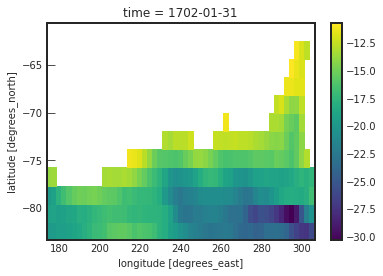

In [96]:
#Create xarray of d18O over the WAIS
d18O_wais_tmon_ctrl = d18O_tmon_ctrl.where(CTRL_DATA.data_vars['land_frac'][0,:,:] >= 0.10).sel(time=slice(time_lo, time_hi), lon=slice(wais_xlo, wais_xhi), lat=slice(wais_ylo, wais_yhi))
d18O_wais_tmon_ctrl[0].plot()


In [97]:
#Step 1a)
#Detrend WAIS d18O; only can be done after filling land with 0, and use of scipy
#requires remapping back to xr dataArray and masking of the 0 points (Ocean)
#Returns the detrended land data with the land mask 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(d18O_wais_tmon_ctrl.fillna(0.), axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': d18O_wais_tmon_ctrl.coords['time'], 'lat': d18O_wais_tmon_ctrl.coords['lat'],'lon': d18O_wais_tmon_ctrl.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

d18O_wais_tmon_detrend_ctrl = aa2.where(aa2 != 0.00000, np.nan)
# print(10, sst_trop_pac_tmon_detrend_ctrl[0,25,11].values)
# print(11, sst_trop_pac_tmon_detrend_ctrl[0,25,33].values)
# print(12, np.count_nonzero(sst_trop_pac_tmon_detrend_ctrl[0,:,:]))
# print(13, np.count_nonzero(~np.isnan(sst_trop_pac_tmon_detrend_ctrl[0,:,:].values)))

# d18O_wais_tmon_detrend_ctrl[0,:,:].plot() #2D map

In [98]:
#Create SST Monthly Climatology from detrended data using data from time_lo to time_hi
d18O_wais_tmon_detrend_climatology_ctrl = d18O_wais_tmon_detrend_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
#sst_detrend_trop_pac_climatology_ctrl
# print(10, sst_detrend_trop_pac_climatology_ctrl[0,25,11].values)
# print(11, sst_detrend_trop_pac_climatology_ctrl[0,25,33].values)
# print(12, np.count_nonzero(sst_detrend_trop_pac_climatology_ctrl[0,:,:]))
# print(13, np.count_nonzero(~np.isnan(sst_detrend_trop_pac_climatology_ctrl[0,:,:].values)))

#sst_detrend_trop_pac_climatology_ctrl[:,90,24].plot()

In [99]:
#Step 1)
#Find Tropical SST Anoms using the climatology from time_lo to time_hi
d18O_anoms_wais_tmon_detrend_ctrl = d18O_wais_tmon_detrend_ctrl.groupby('time.month') - d18O_wais_tmon_detrend_climatology_ctrl
#sst_anoms_detrend_trop_pac_tmon_ctrl

# print(10, sst_anoms_detrend_trop_pac_tmon_ctrl[0,25,11].values)
# print(11, sst_anoms_detrend_trop_pac_tmon_ctrl[0,25,33].values)
# print(12, np.count_nonzero(sst_anoms_detrend_trop_pac_tmon_ctrl[0,:,:]))
# print(13, np.count_nonzero(~np.isnan(sst_anoms_detrend_trop_pac_tmon_ctrl[0,:,:].values)))

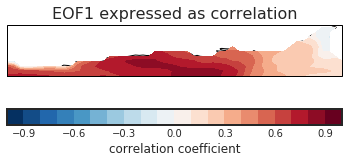

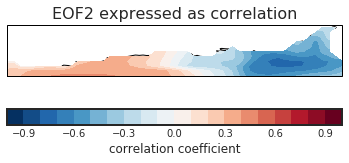

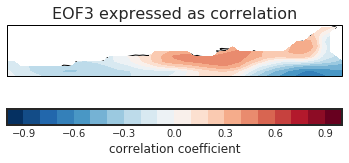

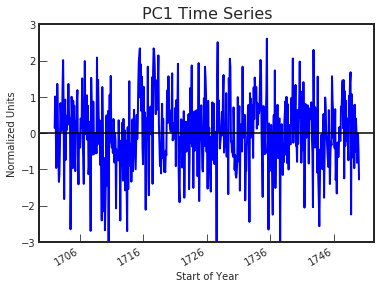

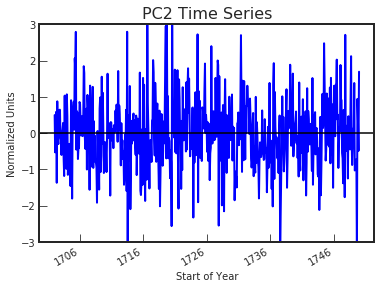

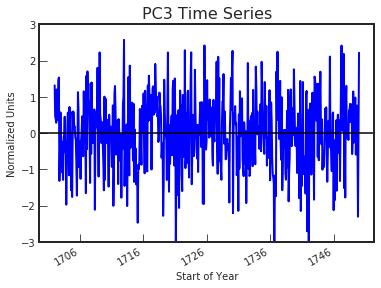

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.335888, 0.168716, 0.090686], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions


In [100]:
"""
Compute and plot the First Two leading EOFs of Tropical Pacific SST anoms
Recall, sign is arbitrary, will adjust when comparing
Step 2)
"""

#current variable, needs to find and replace 8x
#sst_anoms_detrend_trop_pac_tmon_ctrl


# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(d18O_anoms_wais_tmon_detrend_ctrl.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(d18O_anoms_wais_tmon_detrend_ctrl, weights=wgts)


# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input Tropical Pac SST anomalies at each grid point, and the
# leading PC time series itself.
eofs_d18O_anoms_wais_tmon_detrend_ctrl = solver.eofsAsCorrelation(neofs=3)
pcs_d18O_anoms_wais_tmon_detrend_ctrl = solver.pcs(npcs=3, pcscaling=1)


# Plot the leading EOF expressed as correlation with Tropical Pac SST Anoms
clevs = np.linspace(-1, 1, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
fill = eofs_d18O_anoms_wais_tmon_detrend_ctrl[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF1 expressed as correlation', fontsize=16)

# Plot the leading 2nd EOF expressed as correlation with Tropical Pac SST Anoms
plt.figure()
clevs = np.linspace(-1, 1, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
fill = eofs_d18O_anoms_wais_tmon_detrend_ctrl[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF2 expressed as correlation', fontsize=16)

# Plot the leading 3rd EOF expressed as correlation with Tropical Pac SST Anoms
plt.figure()
clevs = np.linspace(-1, 1, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
fill = eofs_d18O_anoms_wais_tmon_detrend_ctrl[2].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='w', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('EOF3 expressed as correlation', fontsize=16)



# Plot the leading PC time series.
plt.figure()
pcs_d18O_anoms_wais_tmon_detrend_ctrl[:, 0].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)

# Plot the 2nd PC time series.
plt.figure()
pcs_d18O_anoms_wais_tmon_detrend_ctrl[:, 1].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC2 Time Series', fontsize=16)

# Plot the 3rd PC time series.
plt.figure()
pcs_d18O_anoms_wais_tmon_detrend_ctrl[:, 2].plot(color='b', linewidth=2)
ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Start of Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC3 Time Series', fontsize=16)


plt.show()

variance_fractions = solver.varianceFraction(neigs=3)  #number of eigenvalues, ie, number of modes
print(variance_fractions)




/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/glade/wor

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.335888, 0.168716, 0.090686], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions


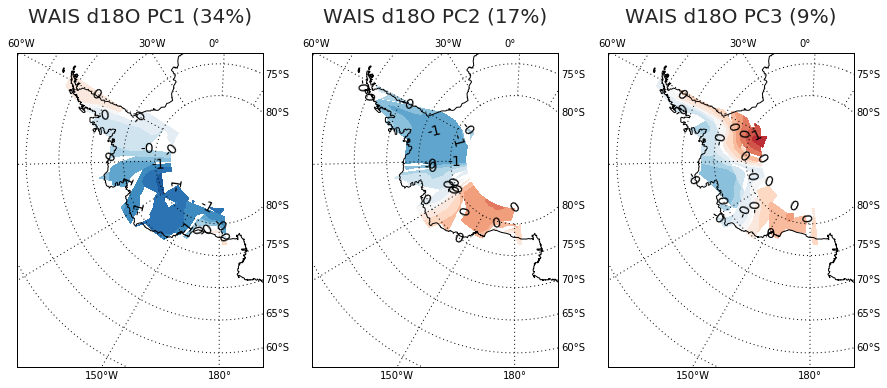

In [101]:
# setup Lambert Conformal basemap.
# Sign correction CTRL PC1 and PC3 IS multiplied by -1 to match SAM and PSA2 (need to keep checking if this is right)
lons, lats = np.meshgrid(CTRL_DATA.d18O.coords['lon'].sel(lon=slice(wais_xlo, wais_xhi)),CTRL_DATA.d18O.coords['lat'].sel(lat=slice(wais_ylo, wais_yhi)))

levels = np.arange(-1,1,.1)

fig = plt.figure(figsize=(15,7))

#EOF1
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 3, 1)
x, y = m(lons, lats)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
#m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
sign_chg1 = eofs_d18O_anoms_wais_tmon_detrend_ctrl[0]*(-1)
CS = m.contourf(x,y,sign_chg1,levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
#CS2 = m.contour(x,y,son_SLP_mask_tmon_era_data.mean(dim='month'),levels,colors='k')
plt.clabel(CS, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('WAIS d18O PC1 (34%)',y=1.08,fontsize=20)


#EOF2
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 3, 2)
x, y = m(lons, lats)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
#m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,eofs_d18O_anoms_wais_tmon_detrend_ctrl[1],levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
#CS2 = m.contour(x,y,son_SLP_mask_tmon_era_data.mean(dim='month'),levels,colors='k')
plt.clabel(CS, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('WAIS d18O PC2 (17%)',y=1.08,fontsize=20)

#EOF3
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 3, 3)
x, y = m(lons, lats)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
#m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
sign_chg3 = eofs_d18O_anoms_wais_tmon_detrend_ctrl[2]*(-1)
CS = m.contourf(x,y,sign_chg3,levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
#CS2 = m.contour(x,y,son_SLP_mask_tmon_era_data.mean(dim='month'),levels,colors='k')
plt.clabel(CS, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('WAIS d18O PC3 (9%)',y=1.08,fontsize=20)

#plt.savefig(FIG_PATH+'/fig03_ctrl_wais_eof_maps.png',bbox_inches='tight', pad_inches=0.01)

print(variance_fractions)

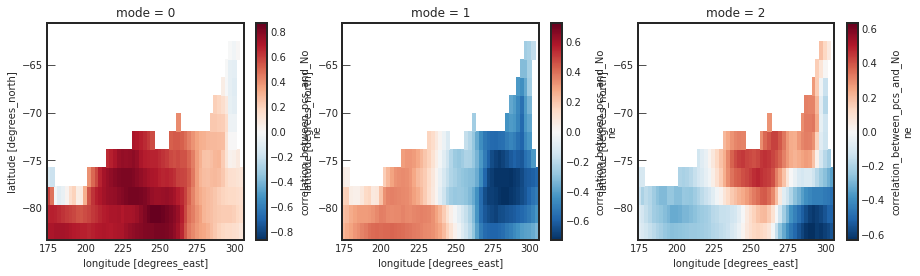

In [102]:
#sign is not correct, see above
fig = plt.figure(figsize=(15,4))
plt.subplot(1, 3, 1)
eofs_d18O_anoms_wais_tmon_detrend_ctrl[0].plot()
plt.subplot(1, 3, 2)
eofs_d18O_anoms_wais_tmon_detrend_ctrl[1].plot()
plt.subplot(1, 3, 3)
eofs_d18O_anoms_wais_tmon_detrend_ctrl[2].plot()

In [103]:
#Normalize the PC time series to have mean of 0 and std of 1.
pc1_norm_d18O_anoms_wais_tmon_detrend_ctrl = (pcs_d18O_anoms_wais_tmon_detrend_ctrl[:,0] - np.mean(pcs_d18O_anoms_wais_tmon_detrend_ctrl[:,0]))/np.std(pcs_d18O_anoms_wais_tmon_detrend_ctrl[:,0])

pc2_norm_d18O_anoms_wais_tmon_detrend_ctrl = (pcs_d18O_anoms_wais_tmon_detrend_ctrl[:,1] - np.mean(pcs_d18O_anoms_wais_tmon_detrend_ctrl[:,1]))/np.std(pcs_d18O_anoms_wais_tmon_detrend_ctrl[:,1])

pc3_norm_d18O_anoms_wais_tmon_detrend_ctrl = (pcs_d18O_anoms_wais_tmon_detrend_ctrl[:,2] - np.mean(pcs_d18O_anoms_wais_tmon_detrend_ctrl[:,2]))/np.std(pcs_d18O_anoms_wais_tmon_detrend_ctrl[:,2])


In [104]:
#Finalize WAIS d18O PC indices and put into pandas dataframE
#Sign for PC1 and PC3 ARE changed to agree with SAM,PSA1,PSA2 signs

df_d18O_wais_PC1_ctrl = pd.DataFrame(pc1_norm_d18O_anoms_wais_tmon_detrend_ctrl.values)*(-1)
df_d18O_wais_PC1_ctrl.columns = ['WAIS_d18O_PC1']
#df_d18O_wais_PC1_ctrl

df_d18O_wais_PC2_ctrl = pd.DataFrame(pc2_norm_d18O_anoms_wais_tmon_detrend_ctrl.values)
df_d18O_wais_PC2_ctrl.columns = ['WAIS_d18O_PC2']
#df_d18O_wais_PC2_ctrl

df_d18O_wais_PC3_ctrl = pd.DataFrame(pc3_norm_d18O_anoms_wais_tmon_detrend_ctrl.values)*(-1)
df_d18O_wais_PC3_ctrl.columns = ['WAIS_d18O_PC3']
#df_d18O_wais_PC3_ctrl

d18O_wais_pcs_ctrl = pd.concat([df_d18O_wais_PC1_ctrl, df_d18O_wais_PC2_ctrl, df_d18O_wais_PC3_ctrl], axis=1)

d18O_wais_pcs_ctrl.set_index(pc1_norm_d18O_anoms_wais_tmon_detrend_ctrl.coords['time'].values, inplace=True, drop=True)

d18O_wais_pcs_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_wais_pcs_tmon.pkl')

d18O_wais_pcs_ctrl.head(n=5)



,WAIS_d18O_PC1,WAIS_d18O_PC2,WAIS_d18O_PC3
1702-01-31,-0.147768,0.499419,-1.319070
1702-02-28,-1.012786,-0.529578,-0.469926
1702-03-31,-0.586636,-0.141958,-0.391213
1702-04-30,0.961874,0.588479,-0.287732
1702-05-31,0.802597,-1.369496,-1.206683


In [105]:
#DataFrame of WAIS d18O PC indices as Seasonal Means, from 0002 MAM through 0049 SON
#USING NORMALIZED DATA
d18O_wais_pcs_seas_ctrl = d18O_wais_pcs_ctrl[2:(len(d18O_wais_pcs_ctrl.index)-1)].resample('3MS', closed='left').mean()


d18O_wais_pcs_seas_ctrl['Seas_Index'] = d18O_wais_pcs_seas_ctrl.index.astype(str).str[5:7]

d18O_wais_pcs_seas_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_wais_pcs_seas.pkl')

d18O_wais_pcs_seas_ctrl.head(n=5)

,WAIS_d18O_PC1,WAIS_d18O_PC2,WAIS_d18O_PC3,Seas_Index
1702-03-01,0.392612,-0.307658,-0.628543,03
1702-06-01,-0.385665,0.155040,-0.909759,06
1702-09-01,0.943593,0.459673,0.098681,09
1702-12-01,-0.436075,-0.309227,-0.006659,12
1703-03-01,-1.154027,0.133339,1.076362,03


In [106]:
#DataFrame of WAIS d18O PC indices as annual Means, from 0002 Jan through 0049 Dec
#Use normalized data
d18O_wais_pcs_ann_mean_ctrl = d18O_wais_pcs_ctrl[:].resample('AS', closed='left'  ).mean()

d18O_wais_pcs_ann_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_wais_pcs_ann_mean.pkl')

d18O_wais_pcs_ann_mean_ctrl.head(n=5)


,WAIS_d18O_PC1,WAIS_d18O_PC2,WAIS_d18O_PC3
1702-01-01,0.071763,0.064181,-0.556891
1703-01-01,-0.337431,-0.211973,0.575486
1704-01-01,-0.098227,-0.425388,0.255803
1705-01-01,0.026043,0.638503,0.151227
1706-01-01,-0.230702,0.405352,0.183854


In [107]:
#DataFrame of WAIS d18O PC indices as 12 month rolling mean, from 0002 Jan through 0049 Dec
#Use normalized data
d18O_wais_pcs_12roll_mean_ctrl = d18O_wais_pcs_ctrl[:].rolling(12, min_periods=12, center=True).mean()

d18O_wais_pcs_12roll_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_wais_pcs_12roll_mean.pkl')

d18O_wais_pcs_12roll_mean_ctrl.head(n=10)


,WAIS_d18O_PC1,WAIS_d18O_PC2,WAIS_d18O_PC3
1702-01-31,NaN,NaN,NaN
1702-02-28,NaN,NaN,NaN
1702-03-31,NaN,NaN,NaN
1702-04-30,NaN,NaN,NaN
1702-05-31,NaN,NaN,NaN
1702-06-30,NaN,NaN,NaN
1702-07-31,0.071763,0.064181,-0.556891
1702-08-31,0.048579,0.005474,-0.418895
1702-09-30,0.128616,-0.000543,-0.361570
1702-10-31,0.163455,0.011541,-0.238918


In [108]:
#DataFrame of WAIS d18O PC indices as 6 month rolling mean, from 0002 Jan through 0049 Dec
#Use normalized data
d18O_wais_pcs_6roll_mean_ctrl = d18O_wais_pcs_ctrl[:].rolling(6, min_periods=6, center=True).mean()

d18O_wais_pcs_6roll_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_wais_pcs_6roll_mean.pkl')

d18O_wais_pcs_6roll_mean_ctrl.head(n=5)

,WAIS_d18O_PC1,WAIS_d18O_PC2,WAIS_d18O_PC3
1702-01-31,NaN,NaN,NaN
1702-02-28,NaN,NaN,NaN
1702-03-31,NaN,NaN,NaN
1702-04-30,-0.224016,-0.012366,-0.764409
1702-05-31,-0.258951,-0.114302,-0.603744


In [109]:
#DataFrame of WAIS d18O PC indices as 3 month rolling mean, from 0002 Jan through 0049 Dec
#Use normalized data
d18O_wais_pcs_3roll_mean_ctrl = d18O_wais_pcs_ctrl[:].rolling(3, min_periods=3, center=True).mean()

d18O_wais_pcs_3roll_mean_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_wais_pcs_3roll_mean.pkl')

d18O_wais_pcs_3roll_mean_ctrl.head(n=5)

,WAIS_d18O_PC1,WAIS_d18O_PC2,WAIS_d18O_PC3
1702-01-31,NaN,NaN,NaN
1702-02-28,-0.582396,-0.057372,-0.726736
1702-03-31,-0.212516,-0.027686,-0.382957
1702-04-30,0.392612,-0.307658,-0.628543
1702-05-31,0.134365,0.032640,-0.802081


In [110]:
#WAIS d18O PCs 2 to 7 yr band pass filter
wais_pc1_band_filt_ctrl = filt_but_band(d18O_wais_pcs_ctrl.WAIS_d18O_PC1.values,84.,24.,1.,btype='bandpass',N=2)
wais_pc2_band_filt_ctrl = filt_but_band(d18O_wais_pcs_ctrl.WAIS_d18O_PC2.values,84.,24.,1.,btype='bandpass',N=2)
wais_pc3_band_filt_ctrl = filt_but_band(d18O_wais_pcs_ctrl.WAIS_d18O_PC3.values,84.,24.,1.,btype='bandpass',N=2)

#Finalize BANDPASS FILTERED WAIS PCs indices and put into pandas dataframE
df_wais_pc1_band_filt_ctrl = pd.DataFrame(wais_pc1_band_filt_ctrl)
df_wais_pc1_band_filt_ctrl.columns = ['WAIS_d18O_PC1']
#df_wais_pc1_band_filt_ctrl

df_wais_pc2_band_filt_ctrl = pd.DataFrame(wais_pc2_band_filt_ctrl)
df_wais_pc2_band_filt_ctrl.columns = ['WAIS_d18O_PC2']
#df_wais_pc2_band_filt_ctrl

df_wais_pc3_band_filt_ctrl = pd.DataFrame(wais_pc3_band_filt_ctrl)
df_wais_pc3_band_filt_ctrl.columns = ['WAIS_d18O_PC3']
#df_wais_pc3_band_filt_ctrl

# df_time_ctrl = pd.DataFrame(sst_anoms_detrend_trop_pac_tmon_ctrl.coords['time'].values)
# df_time_ctrl.columns = ['time']
# #df_time_ctrl

d18O_wais_pcs_band_filt_ctrl = pd.concat([df_time_ctrl, df_wais_pc1_band_filt_ctrl, df_wais_pc2_band_filt_ctrl, df_wais_pc3_band_filt_ctrl], axis=1)
d18O_wais_pcs_band_filt_ctrl.set_index('time', inplace=True)

d18O_wais_pcs_band_filt_ctrl.to_pickle(PICKLE_PATH+'/ctrl_d18O_wais_pcs_band_filt.pkl')

d18O_wais_pcs_band_filt_ctrl.head(n=5)

,WAIS_d18O_PC1,WAIS_d18O_PC2,WAIS_d18O_PC3
time,,,
1702-01-31,0.152058,-0.310725,-0.493736
1702-02-28,0.149429,-0.311663,-0.490185
1702-03-31,0.145805,-0.313917,-0.481078
1702-04-30,0.141151,-0.317446,-0.466540
1702-05-31,0.135435,-0.322184,-0.446768


In [111]:
# #test WAIS d18O PCs bandpass filter
# plt.figure(figsize=(20,18))

# plt.subplot(3,1,1)
# plt.plot(d18O_wais_pcs_ctrl.WAIS_d18O_PC1.values)
# plt.plot(d18O_wais_pcs_band_filt_ctrl.WAIS_d18O_PC1.values)

# plt.subplot(3,1,2)
# plt.plot(d18O_wais_pcs_ctrl.WAIS_d18O_PC2.values)
# plt.plot(d18O_wais_pcs_band_filt_ctrl.WAIS_d18O_PC2.values)

# plt.subplot(3,1,3)
# plt.plot(d18O_wais_pcs_ctrl.WAIS_d18O_PC3.values)
# plt.plot(d18O_wais_pcs_band_filt_ctrl.WAIS_d18O_PC3.values)

# plt.show()

## Create indices of Relative Central Pressure Values, Longitude, and Latitude. With each index derived from detrended data with monthly climatological mean removed and normalized wrt mean and std <br>
## UPDATED 19Nov2018 - The ASL Location and Values are determined using SLP data that is already in seasonal, rolling, annual form; such that it is not just a simple averaging of the monthly data

In [112]:
asl_xhi_slice = 298
asl_xlo_slice = 170
asl_yhi_slice = -59.6 #need to go a bit passed 60S to get a full grid point
asl_ylo_slice = -80

In [113]:
#SLP land values are masked Still a dask array
SLP_abs_tmon_ctrl = slp_tmon_ctrl.sel(lon=slice(shem_xlo_slice, shem_xhi_slice), lat=slice(shem_ylo_slice, shem_yhi_slice)).where(CTRL_DATA.data_vars['land_frac'][0,:,:] < 0.999)
#making the chunksize 1 seems to speed up the finding of mins code below
SLP_abs_tmon_ctrl = SLP_abs_tmon_ctrl.chunk({'time':1})

SLP_abs_tmon_ctrl

<xarray.DataArray (time: 576, lat: 24, lon: 144)>
dask.array<shape=(576, 24, 144), dtype=float32, chunksize=(1, 24, 144)>
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 -78.63 ...
  * time     (time) datetime64[ns] 1702-01-31 1702-02-28 1702-03-31 ...
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...

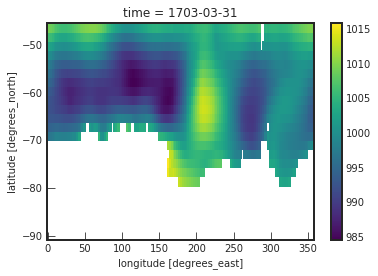

In [114]:
SLP_abs_tmon_ctrl[14,:,:].plot()

In [115]:
lat_vals = CTRL_DATA.coords['lat']
lat_vals = lat_vals.sel(lat=slice(shem_ylo_slice, shem_yhi_slice)).values
lat_vals

array([-90.        , -88.10526316, -86.21052632, -84.31578947,
       -82.42105263, -80.52631579, -78.63157895, -76.73684211,
       -74.84210526, -72.94736842, -71.05263158, -69.15789474,
       -67.26315789, -65.36842105, -63.47368421, -61.57894737,
       -59.68421053, -57.78947368, -55.89473684, -54.        ,
       -52.10526316, -50.21052632, -48.31578947, -46.42105263])

In [116]:
rad = round(4.0*np.arctan(1.0)/180.0,5)  #equals pi/180, rounding to conserve space
wlat = np.cos(lat_vals*rad)  #cos of lat
wlat

array([2.96326791e-04, 3.33532977e-02, 6.63738109e-02, 9.93217728e-02,
       1.32161169e-01, 1.64856103e-01, 1.97370837e-01, 2.29669831e-01,
       2.61717779e-01, 2.93479650e-01, 3.24920727e-01, 3.56006642e-01,
       3.86703415e-01, 4.16977493e-01, 4.46795785e-01, 4.76125696e-01,
       5.04935168e-01, 5.33192708e-01, 5.60867430e-01, 5.87929083e-01,
       6.14348087e-01, 6.40095563e-01, 6.65143369e-01, 6.89464124e-01])

In [117]:
ones_3d = np.ones(slp_tmon_ctrl.sel(lat=slice(shem_ylo_slice, shem_yhi_slice)).shape)
wlat_3d = ones_3d * wlat[np.newaxis, :, np.newaxis]
wlat_3d.shape

(576, 24, 144)

To weight, take zonal mean (brackets) of the product of the variable for the region (170E-298E) and the weight (cosine of lat), then sum across the latidinal band (80S-60S).  Divide this number by zonal mean (brackets) of the weights for the region (170E-298E) and sum latidinally (80S-60S)<br>


$$
\frac {\displaystyle\sum_{j=low}^{hi} \langle \cos(\lambda_j) *  VAR \rangle}{\displaystyle\sum_{j=low}^{hi} \langle \cos(\lambda_j) \rangle}
$$

In [118]:
numerator = SLP_abs_tmon_ctrl * wlat_3d
numerator_region = numerator.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).mean(dim='lon').sum(dim='lat')
#print (numerator_region.values, numerator_region.shape)

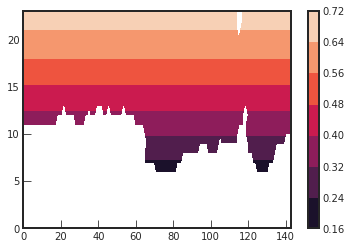

In [119]:
#turn the lat-weights into dask array for use in slicing next
da_wlat_3d = numerator / slp_tmon_ctrl
plt.contourf(da_wlat_3d[0])
plt.colorbar()
plt.show()

In [120]:
denominator_region = da_wlat_3d.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).mean(dim='lon').sum(dim='lat')
#denominator_region.values

In [121]:
ASL_sectormean_tmon_ctrl = (numerator_region/denominator_region)
#ASL_sectormean_tmon_ctrl.values

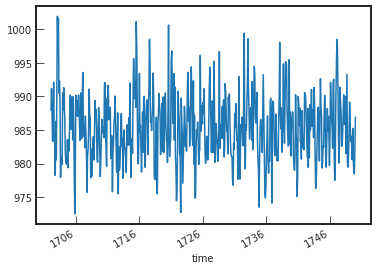

In [122]:
ASL_sectormean_tmon_ctrl.plot()
# ASL_sectormean_tmon_ctrl.shape

In [123]:
#time series for the Abs CP Min vs Abs SLP sector mean and below that the Rel CP Min timeseries

In [124]:
#Abs CP Min
ASL_sectormin_tmon_ctrl = SLP_abs_tmon_ctrl.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat'])
#ASL_sectormin_tmon_ctrl.plot()
#ASL_sectormin_tmon_ctrl.shape

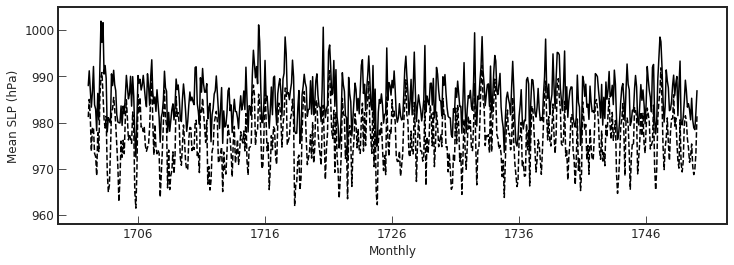

In [125]:
#Based on Hosking et al 2013, Fig. 2a
#mean slp of ASL sector (solid) and actual abs CP (dash)

x = CTRL_DATA.coords['time'].values
y_asl_sector_mean_ctrl = ASL_sectormean_tmon_ctrl.values
y_asl_abs_cp_ctrl = ASL_sectormin_tmon_ctrl.values

sns.set_style('white')
sns.set_style('ticks',
              {'xtick.major.size':8, 'ytick.major.size':8,
               'xtick.direction': 'in', 'ytick.direction': 'in',
               'axes.linewidth':2 })
params = {'legend.fontsize': 'large',
          'figure.figsize': (12, 4),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)


fig, ax1 = plt.subplots()

ax1.set_xlabel('Monthly')
ax1.set_ylabel('Mean SLP (hPa)')
#ax1.set_xlim(132,253)
#ax1.xaxis.set(ticks=np.arange(132, 253, 12),
#             ticklabels=('0013','0014','0015','0016','0017','0018','0019','0020','0021','0022','0023'))
ax1.set_ylim(958,1005)
ax1.yaxis.set_ticks(np.arange(960, 1010, 10))
ax1.plot(x, y_asl_sector_mean_ctrl, color='k',linewidth=1.5)
ax1.plot(x, y_asl_abs_cp_ctrl, color='k',ls='--',linewidth=1.5)

plt.show()

In [126]:
#correlation of ABSL actual CP and area-averaged MSLP in ASL region 0013-0023
#need to detrend these time series before comparing to one-another and to SAM index nino3.4 see page 4
fff = pearsonr(ASL_sectormean_tmon_ctrl.values,ASL_sectormin_tmon_ctrl.values)
print(fff)

(0.8884369420417638, 2.8394805788774357e-196)


In [127]:
#Every month relative CP data for climatology time series

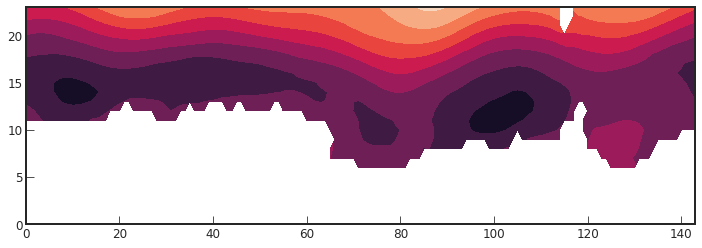

In [128]:
#RELATIVE SLP wrt ASL MEAN for each month
ASL_sector_relative_tmon_ctrl = SLP_abs_tmon_ctrl - ASL_sectormean_tmon_ctrl
ASL_sector_relative_tmon_ctrl.shape
plt.contourf(ASL_sector_relative_tmon_ctrl[0])

In [129]:
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

def detect_local_minima(arr):
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_minima = local_min ^ eroded_background
    return np.where(detected_minima)

In [130]:
monthly_Rel_CP_location_lists = []
for t in np.arange(0,len(slp_tmon_ctrl.coords['time']),1): 
    current = []
    monthly_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = ASL_sector_relative_tmon_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(ASL_sector_relative_tmon_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == ASL_sector_relative_tmon_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        #print('In NW Region', t, t%12)
        #print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(ASL_sector_relative_tmon_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = ASL_sector_relative_tmon_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            #print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            #print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                #print(uuu)
                #print(uuu.values)
                #print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #print(uuu)
                #print(uuu.values)
                #print(all_loc_mins)

            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                #print(all_loc_mins[idx[0]][idx[0]].coords['lon'].values)
                #print(all_loc_mins[idx[0]][idx[0]].coords['lat'].values)
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #print(uuu)
                #print(uuu.values)
                #print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
##print(monthly_Rel_CP_location_lists)


#         #print('In NW Region', t, t%12)
#         #print(min_rel_cp)
#                     #print('Empty list of arrays for t=', t)
#             #print(yy)
#             #print(idx)
#             #print(uuu)
#             #print(uuu.values)
#             #print(all_loc_mins)

In [131]:
len(monthly_Rel_CP_location_lists)

576

In [132]:
# monthly_Rel_CP_location_lists #now just one for each time step

In [133]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack

monthly_Rel_CP_location_lists_vals = []
for t in np.arange(0,len(slp_tmon_ctrl.coords['time']),1): 
   current = []
   monthly_Rel_CP_location_lists_vals.append(current)
   pp = monthly_Rel_CP_location_lists[t][0].values
   current.append(pp)
#print(monthly_Rel_CP_location_lists_vals)

# monthly_Rel_CP_location_lists_times = []
# for t in np.arange(0,len(slp_tmon_ctrl.coords['time']),1): 
#    current = []
#    monthly_Rel_CP_location_lists_times.append(current)
#    pp = monthly_Rel_CP_location_lists[t][0].coords['time'].values
#    current.append(pp)
# #print(monthly_Rel_CP_location_lists_times)

monthly_Rel_CP_location_lists_lats = []
for t in np.arange(0,len(slp_tmon_ctrl.coords['time']),1): 
   current = []
   monthly_Rel_CP_location_lists_lats.append(current)
   pp = monthly_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
#print(monthly_Rel_CP_location_lists_lats)

monthly_Rel_CP_location_lists_lons = []
for t in np.arange(0,len(slp_tmon_ctrl.coords['time']),1): 
   current = []
   monthly_Rel_CP_location_lists_lons.append(current)
   pp = monthly_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
#print(monthly_Rel_CP_location_lists_lons)

monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_ctrl = np.column_stack((monthly_Rel_CP_location_lists_vals, monthly_Rel_CP_location_lists_lats, monthly_Rel_CP_location_lists_lons))
monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_ctrl.shape

(576, 3)

In [134]:
pd.to_datetime(slp_tmon_ctrl.coords['time'].values)

DatetimeIndex(['1702-01-31', '1702-02-28', '1702-03-31', '1702-04-30',
               '1702-05-31', '1702-06-30', '1702-07-31', '1702-08-31',
               '1702-09-30', '1702-10-31',
               ...
               '1749-03-31', '1749-04-30', '1749-05-31', '1749-06-30',
               '1749-07-31', '1749-08-31', '1749-09-30', '1749-10-31',
               '1749-11-30', '1749-12-31'],
              dtype='datetime64[ns]', length=576, freq=None)

In [135]:
#Putting the Relative CP location information into a Pandas Dataframe
monthly_Rel_CP_location_info_ctrl_df = pd.DataFrame({
                    'time'         : pd.to_datetime(slp_tmon_ctrl.coords['time'].values),
                    'month_indice' : np.tile(np.arange(0,12,1), int(len(slp_tmon_ctrl.coords['time'])/12)),
                    'vals'         : monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_ctrl[:,0],
                    'lats'         : monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_ctrl[:,1],
                    'lons'         : monthly_Rel_CP_location_lists_ASL_Relative_CP_Location_info_ctrl[:,2],
                   })
# monthly_Rel_CP_location_info_ctrl_df

#Make time the index column so that we can use resample for seasonal means
monthly_Rel_CP_location_info_ctrl_df.time = pd.to_datetime(slp_tmon_ctrl.coords['time'].values)
monthly_Rel_CP_location_info_ctrl_df.set_index('time', inplace=True)
monthly_Rel_CP_location_info_ctrl_df.head(n=5)



,month_indice,vals,lats,lons
time,,,,
1702-01-31,0,-6.801193,-69.157895,250.0
1702-02-28,1,-3.436552,-69.157895,280.0
1702-03-31,2,-5.959794,-71.052632,200.0
1702-04-30,3,-9.515633,-71.052632,227.5
1702-05-31,4,-7.787764,-69.157895,257.5


# NEW - START

### Absolute Seasonal data and means:

In [136]:
SLP_abs_tmon_ctrl

<xarray.DataArray (time: 576, lat: 24, lon: 144)>
dask.array<shape=(576, 24, 144), dtype=float32, chunksize=(1, 24, 144)>
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 -78.63 ...
  * time     (time) datetime64[ns] 1702-01-31 1702-02-28 1702-03-31 ...
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...

In [137]:
#Seasonal Mean
#Seasonal Mean of Field Variable, just an example here to make sure my method below is correct
slp_abs_seas_ctrl = SLP_abs_tmon_ctrl[2:(len(SLP_abs_tmon_ctrl['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(axis=0)
slp_abs_seas_ctrl

<xarray.DataArray (time: 191, lat: 24, lon: 144)>
dask.array<shape=(191, 24, 144), dtype=float32, chunksize=(1, 24, 144)>
Coordinates:
  * time     (time) datetime64[ns] 1702-03-01 1702-06-01 1702-09-01 ...
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 -78.63 ...
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'time' (time: 47)>
array(['1702-12-01T00:00:00.000000000', '1703-12-01T00:00:00.000000000',
       '1704-12-01T00:00:00.000000000', '1705-12-01T00:00:00.000000000',
       '1706-12-01T00:00:00.000000000', '1707-12-01T00:00:00.000000000',
       '1708-12-01T00:00:00.000000000', '1709-12-01T00:00:00.000000000',
       '1710-12-01T00:00:00.000000000', '1711-12-01T00:00:00.000000000',
       '1712-12-01T00:00:00.000000000', '1713-12-01T00:00:00.000000000',
       '1714-12-01T00:00:00.000000000', '1715-12-01T00:00:00.000000000',
       '1716-12-01T00:00:00.000000000', '1717-12-01T00:00:00.000000000',
       '1718-12-01T00:00:00.000000000', '1719-12-01T00:00:00.000000000',
       '1720-12-01T00:00:00.000000000', '1721-12-01T00:00:00.000000000',
       '1722-12-01T00:00:00.000000000', '1723-12-01T00:00:00.000000000',
       '1724-12-01T00:00:00.000000000', '1725-12-01T00:00:00.000000000',
       '1726-12-01T00:00:00.000000000', '1727-12-01T00:00:00.000000000',
       '1728-1

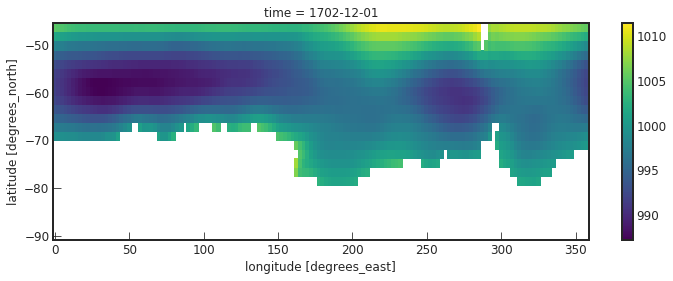

In [138]:
#Seperating out those seasonal means of the field variable
def is_djf(month):
    return (month == 12)

def is_mam(month):
    return (month == 3)

def is_jja(month):
    return (month == 6)

def is_son(month):
    return (month == 9)

djf_slp_abs_seas_ctrl = slp_abs_seas_ctrl.sel(time=is_djf(slp_abs_seas_ctrl['time.month']))
mam_slp_abs_seas_ctrl = slp_abs_seas_ctrl.sel(time=is_mam(slp_abs_seas_ctrl['time.month']))
jja_slp_abs_seas_ctrl = slp_abs_seas_ctrl.sel(time=is_jja(slp_abs_seas_ctrl['time.month']))
son_slp_abs_seas_ctrl = slp_abs_seas_ctrl.sel(time=is_son(slp_abs_seas_ctrl['time.month']))

#note, the first djf is dated for the first year because the 3-month mean is labeled by the first month
#Do not include the last value (0049) for DJF, as it only contains D
djf_slp_abs_seas_ctrl[0].plot()
print(djf_slp_abs_seas_ctrl.time)

#In case I need to add NaNs in djf, something like this may work:
# #need to add back in at time=0 a row of nans for djf, else it has 47 instead of 48 points
# nan_slice_for_djf = djfmean_T2M_tmon_ctrl_data[0:1,:,:]
# nan_slice_for_djf = nan_slice_for_djf.where(nan_slice_for_djf == 99999.)
# djfmean_T2M_tmon_ctrl_data = xr.concat([nan_slice_for_djf, djfmean_T2M_tmon_ctrl_data], dim='time')
# #djfmean_T2M_tmon_ctrl_data

<xarray.DataArray 'getitem-1c05b0ac822e7f39d9db628f7e2bf715' (time: 576, lat: 24, lon: 144)>
dask.array<shape=(576, 24, 144), dtype=float32, chunksize=(576, 24, 144)>
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 -78.63 ...
  * time     (time) datetime64[ns] 1702-01-31 1702-02-28 1702-03-31 ...
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...


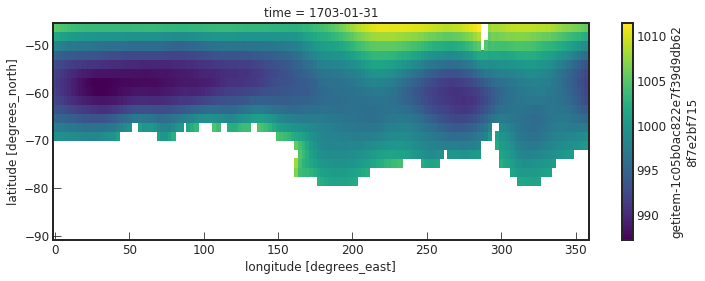

In [139]:
#Field variable with 3,6,12 roll and annual mean
SLP_abs_tmon_ctrl = SLP_abs_tmon_ctrl.chunk({'time':576})

slp_abs_roll3_mean_ctrl = SLP_abs_tmon_ctrl.rolling(time=3, min_periods=3, center=True).mean(axis=0)
print(slp_abs_roll3_mean_ctrl)
slp_abs_roll3_mean_ctrl[12].plot()

slp_abs_roll6_mean_ctrl = SLP_abs_tmon_ctrl.rolling(time=6, min_periods=6, center=True).mean(axis=0)
#slp_abs_roll6_mean_ctrl

slp_abs_roll12_mean_ctrl = SLP_abs_tmon_ctrl.rolling(time=12, min_periods=12, center=True).mean(axis=0)
#slp_abs_roll12_mean_ctrl

slp_abs_ann_mean_ctrl = SLP_abs_tmon_ctrl.resample(time='AS').mean(axis=0)
# slp_abs_ann_mean_ctrl

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packag

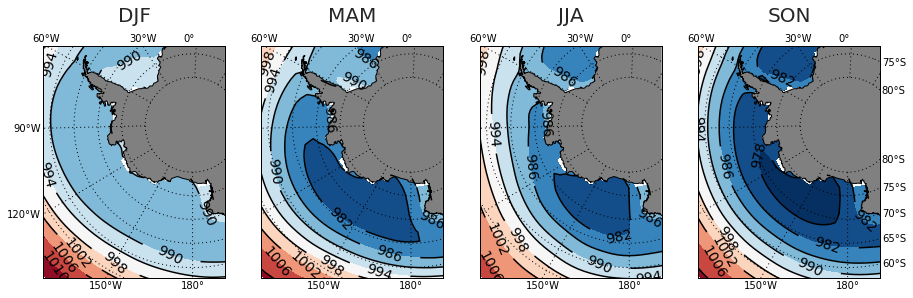

In [140]:
# setup Lambert Conformal basemap.
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)

lon, lat = np.meshgrid(CTRL_DATA.coords['lon'].sel(lon=slice(shem_xlo_slice, shem_xhi_slice)).values,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo_slice, shem_yhi_slice)).values)

levels = np.arange(978,1018,4)

fig = plt.figure(figsize=(15,7))

#DJF
plt.subplot(1, 4, 1)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[True,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,djf_slp_abs_seas_ctrl.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,djf_slp_abs_seas_ctrl.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('DJF',y=1.08,fontsize=20)


#MAM
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 2)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,mam_slp_abs_seas_ctrl.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,mam_slp_abs_seas_ctrl.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('MAM',y=1.08,fontsize=20)


#JJA
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 3)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,jja_slp_abs_seas_ctrl.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,jja_slp_abs_seas_ctrl.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('JJA',y=1.08,fontsize=20)


#SON
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 4)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,son_slp_abs_seas_ctrl.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,son_slp_abs_seas_ctrl.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('SON',y=1.08,fontsize=20)

# plt.savefig(FIG_PATH+'/ctrl_fig1.png',bbox_inches='tight', pad_inches=0.01)

plt.show()

### Hosking et al 2013 definition relative SLP.  I need to subtract off the seasonal mean for each year from the seasonal mean abs CP.

In [141]:
ASL_sectormean_tmon_ctrl.time

<xarray.DataArray 'time' (time: 576)>
array(['1702-01-31T00:00:00.000000000', '1702-02-28T00:00:00.000000000',
       '1702-03-31T00:00:00.000000000', ..., '1749-10-31T00:00:00.000000000',
       '1749-11-30T00:00:00.000000000', '1749-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1702-01-31 1702-02-28 1702-03-31 ...

In [142]:
#Seasonal Mean
#Seasonal Mean of Sectormean, just an example here to make sure my method below is correct
ASL_sectormean_seas_ctrl = ASL_sectormean_tmon_ctrl[2:(len(ASL_sectormean_tmon_ctrl['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(axis=0)
print(ASL_sectormean_seas_ctrl[0].values) #MAM for 0002 
print(ASL_sectormean_seas_ctrl[0])
ASL_sectormean_seas_ctrl

985.6538924601895
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1702-03-01


<xarray.DataArray (time: 191)>
dask.array<shape=(191,), dtype=float64, chunksize=(1,)>
Coordinates:
  * time     (time) datetime64[ns] 1702-03-01 1702-06-01 1702-09-01 ...

In [143]:
#Seasonal Mean continue
djf_ASL_sectormean_seas_ctrl = ASL_sectormean_seas_ctrl.sel(time=is_djf(ASL_sectormean_seas_ctrl['time.month']))
mam_ASL_sectormean_seas_ctrl = ASL_sectormean_seas_ctrl.sel(time=is_mam(ASL_sectormean_seas_ctrl['time.month']))
jja_ASL_sectormean_seas_ctrl = ASL_sectormean_seas_ctrl.sel(time=is_jja(ASL_sectormean_seas_ctrl['time.month']))
son_ASL_sectormean_seas_ctrl = ASL_sectormean_seas_ctrl.sel(time=is_son(ASL_sectormean_seas_ctrl['time.month']))

print(mam_ASL_sectormean_seas_ctrl[0].values)
print(mam_ASL_sectormean_seas_ctrl[0])

#Rolling means and annual mean
ASL_sectormean_tmon_ctrl = ASL_sectormean_tmon_ctrl.chunk({'time':576})

ASL_sectormean_roll3_mean_ctrl = ASL_sectormean_tmon_ctrl.rolling(time=3, min_periods=3, center=True).mean(axis=0)
print(ASL_sectormean_roll3_mean_ctrl[3].values)
print(ASL_sectormean_roll3_mean_ctrl[3])

ASL_sectormean_roll6_mean_ctrl = ASL_sectormean_tmon_ctrl.rolling(time=6, min_periods=6, center=True).mean(axis=0)

ASL_sectormean_roll12_mean_ctrl = ASL_sectormean_tmon_ctrl.rolling(time=12, min_periods=12, center=True).mean(axis=0)

ASL_sectormean_ann_mean_ctrl = ASL_sectormean_tmon_ctrl.resample(time='AS').mean(axis=0)



985.6538924601895
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1702-03-01
985.6538924601896
<xarray.DataArray 'getitem-aac67d13664035b0c15f9c341d04dba9' ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1702-04-30


In [144]:
#calculating relative slp in the ASL sector
djf_slp_rel_cp_asl_seas_ctrl = (djf_slp_abs_seas_ctrl.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - djf_ASL_sectormean_seas_ctrl )
mam_slp_rel_cp_asl_seas_ctrl = (mam_slp_abs_seas_ctrl.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - mam_ASL_sectormean_seas_ctrl )
jja_slp_rel_cp_asl_seas_ctrl = (jja_slp_abs_seas_ctrl.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - jja_ASL_sectormean_seas_ctrl )
son_slp_rel_cp_asl_seas_ctrl = (son_slp_abs_seas_ctrl.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - son_ASL_sectormean_seas_ctrl )
roll3_slp_rel_cp_asl_ctrl = (slp_abs_roll3_mean_ctrl.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - ASL_sectormean_roll3_mean_ctrl )
roll6_slp_rel_cp_asl_ctrl = (slp_abs_roll6_mean_ctrl.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - ASL_sectormean_roll6_mean_ctrl )
roll12_slp_rel_cp_asl_ctrl = (slp_abs_roll12_mean_ctrl.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - ASL_sectormean_roll12_mean_ctrl )
ann_mean_slp_rel_cp_asl_ctrl = (slp_abs_ann_mean_ctrl.sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))
                                - ASL_sectormean_ann_mean_ctrl )


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packag

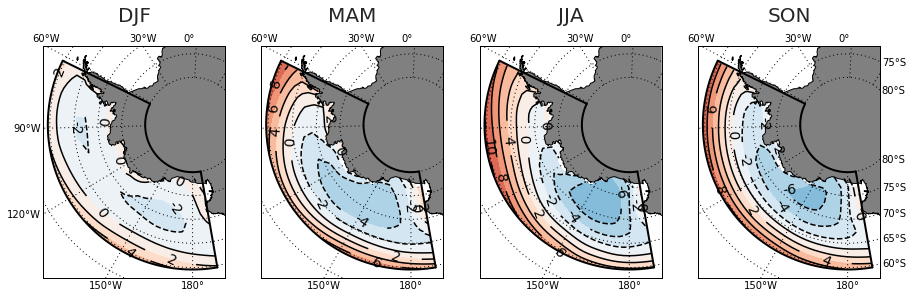

In [145]:
# setup Lambert Conformal basemap.
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)

lon, lat = np.meshgrid(CTRL_DATA.coords['lon'].sel(lon=slice(asl_xlo_slice, asl_xhi_slice)).values,CTRL_DATA.coords['lat'].sel(lat=slice(asl_ylo_slice, asl_yhi_slice)).values)

levels = np.arange(-16,18,2)

fig = plt.figure(figsize=(15,7))

plt.subplot(1, 4, 1)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[True,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,djf_slp_rel_cp_asl_seas_ctrl.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,djf_slp_rel_cp_asl_seas_ctrl.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('DJF',y=1.08,fontsize=20)

#Add ASL Box
lat_line = np.linspace(-59.6,-59.6,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2) 

lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-190,-190,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-62,-62,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)


#MAM
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 2)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,mam_slp_rel_cp_asl_seas_ctrl.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,mam_slp_rel_cp_asl_seas_ctrl.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('MAM',y=1.08,fontsize=20)

#Add ASL Box
lat_line = np.linspace(-59.6,-59.6,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2) 

lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-190,-190,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-62,-62,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)


#JJA
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 3)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,jja_slp_rel_cp_asl_seas_ctrl.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,jja_slp_rel_cp_asl_seas_ctrl.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('JJA',y=1.08,fontsize=20)

#Add ASL Box
lat_line = np.linspace(-59.6,-59.6,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2) 

lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-190,-190,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-62,-62,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)


#SON
m = Basemap(llcrnrlon=-135,llcrnrlat=-46,urcrnrlon=20,urcrnrlat=-72,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
plt.subplot(1, 4, 4)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gray')
# draw parallels and meridians.
# label parallels on right 
# meridians on top, bottom and left
parallels = np.arange(-80,-51,5.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,False,False],dashes=[1, 3])
meridians = np.arange(-180.,31,30.)
m.drawmeridians(meridians,labels=[False,False,True,True],dashes=[1, 3])
#meridians2 = np.arange(-0,61.,30.) #Tried to get the 0 line to be the 180 line extended... not working
#m.drawmeridians(meridians2,labels=[False,False,True,False])
CS = m.contourf(x,y,son_slp_rel_cp_asl_seas_ctrl.mean(dim='time'),levels,cmap=plt.cm.get_cmap('RdBu_r'),extend='both')
CS2 = m.contour(x,y,son_slp_rel_cp_asl_seas_ctrl.mean(dim='time'),levels,colors='k')
plt.clabel(CS2, fmt='%2.0f', inline=True, inline_spacing=20, colors='k', fontsize=14)
plt.title('SON',y=1.08,fontsize=20)

#Add ASL Box
lat_line = np.linspace(-59.6,-59.6,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2) 

lat_line = np.linspace(-80,-80,100) 
lon_line = np.linspace(-190,-62,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-190,-190,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

lat_line = np.linspace(-80,-59.6,2) 
lon_line = np.linspace(-62,-62,2)
x, y = m(lon_line, lat_line)
m.plot(x, y, 'k-', linewidth=2)

# plt.savefig(FIG_PATH+'/ctrl_fig2.png',bbox_inches='tight', pad_inches=0.01)



plt.show()

### Finding the ASL CP for each time period

In [146]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [147]:
djfmean_Rel_CP_location_lists = []
for t in np.arange(0,len(djf_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
    current = []
    djfmean_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = djf_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(djf_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == djf_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        print('In NW Region', t)
        print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(djf_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = djf_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)


            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
print(djfmean_Rel_CP_location_lists)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

In NW Region 24
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
    time     datetime64[ns] 1726-12-01
  * lat      (lat) float64 -63.47
  * lon      (lon) float64 170.0
[-3.1474739  -3.17359695  0.47984543 -3.36756668 -3.66431961 -2.95655593]
[4 3 1]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1726-12-01
    lat      float64 -69.16
    lon      float64 182.5
-3.36756667628822
<xarray.DataArray (lat: 6, lon: 6)>
dask.array<shape=(6, 6), dtype=float64, chunksize=(6, 6)>
Coordinates:
    time     datetime64[ns] 1726-12-01
  * lat      (lat) float64 -74.84 -72.95 -72.95 -69.16 -63.47 -63.47
  * lon      (lon) float64 200.0 192.5 255.0 182.5 170.0 287.5


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In NW Region 28
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
    time     datetime64[ns] 1730-12-01
  * lat      (lat) float64 -65.37
  * lon      (lon) float64 182.5
[-3.60197117 -1.52781346 -1.06388524 -3.87968113]
[3 0 1]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1730-12-01
    lat      float64 -72.95
    lon      float64 192.5

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)



-3.601971173546076
<xarray.DataArray (lat: 4, lon: 4)>
dask.array<shape=(4, 4), dtype=float64, chunksize=(4, 4)>
Coordinates:
    time     datetime64[ns] 1730-12-01
  * lat      (lat) float64 -72.95 -69.16 -69.16 -65.37
  * lon      (lon) float64 192.5 250.0 277.5 182.5


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

In NW Region 35
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
    time     datetime64[ns] 1737-12-01
  * lat      (lat) float64 -63.47
  * lon      (lon) float64 170.0
[-0.53726182 -3.99697862 -4.84646592]
[2 1 0]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1737-12-01
    lat      float64 -67.26
    lon      float64 272.5
-3.996978620135451
<xarray.DataArray (lat: 3, lon: 3)>
dask.array<shape=(3, 3), dtype=float64, chunksize=(3, 3)>
Coordinates:
    time     datetime64[ns] 1737-12-01
  * lat      (lat) float64 -74.84 -67.26 -63.47
  * lon      (lon) float64 210.0 272.5 170.0
In NW Region 36
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
    time     datetime64[ns] 1738-12-01
  * lat      (lat) float64 -63.47
  * lon      (lon) float64 170.0


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[-0.33032157 -0.12902762 -1.57232596 -4.87231375 -2.025512   -1.98998954
 -4.23834159]
[3 6 4]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1738-12-01
    lat      float64 -61.58
    lon      float64 290.0
-4.238341586416027
<xarray.DataArray (lat: 7, lon: 7)>
dask.array<shape=(7, 7), dtype=float64, chunksize=(7, 7)>
Coordinates:
    time     datetime64[ns] 1738-12-01
  * lat      (lat) float64 -72.95 -71.05 -71.05 -63.47 -63.47 -63.47 -61.58
  * lon      (lon) float64 255.0 260.0 280.0 170.0 192.5 200.0 290.0


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In NW Region 39
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
    time     datetime64[ns] 1741-12-01
  * lat      (lat) float64 -67.26
  * lon      (lon) float64 185.0
[-5.99471074 -2.77144413]
[0 1]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1741-12-01
    lat      float64 -61.58
    lon      float64 295.0
-2.7714441336697746
<xarray.DataArray (lat: 2, lon: 2)>
dask.array<shape=(2, 2), dtype=float64, chunksize=(2, 2)>
Coordinates:
    time     datetime64[ns] 1741-12-01
  * lat      (lat) float64 -67.26 -61.58
  * lon      (lon) float64 185.0 295.0


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[[<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1702-12-01
    lat      float64 -61.58
    lon      float64 275.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1703-12-01
    lat      float64 -71.05
    lon      float64 225.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1704-12-01
    lat      float64 -71.05
    lon      float64 202.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1705-12-01
    lat      float64 -67.26
    lon      float64 200.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1706-12-01
    lat      float64 -65.37
    lon      float64 255.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
   

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [148]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack
#DJF
djfmean_Rel_CP_vals = []
for t in np.arange(0,len(djf_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
   current = []
   djfmean_Rel_CP_vals.append(current)
   pp = djfmean_Rel_CP_location_lists[t][0].values
   current.append(pp)
merged_list = []
for l in djfmean_Rel_CP_vals:
    merged_list += l
djfmean_Rel_CP_vals = np.asarray(merged_list)
#print(djfmean_Rel_CP_vals)


djfmean_Rel_CP_times = []
for t in np.arange(0,len(djf_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
   current = []
   djfmean_Rel_CP_times.append(current)
   pp = djfmean_Rel_CP_location_lists[t][0].coords['time'].values
   current.append(pp)
merged_list = []
for l in djfmean_Rel_CP_times:
    merged_list += l
djfmean_Rel_CP_times = np.asarray(merged_list)
#print(djfmean_Rel_CP_times)


djfmean_Rel_CP_lats = []
for t in np.arange(0,len(djf_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
   current = []
   djfmean_Rel_CP_lats.append(current)
   pp = djfmean_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
merged_list = []
for l in djfmean_Rel_CP_lats:
    merged_list += l
djfmean_Rel_CP_lats = np.asarray(merged_list)
#print(djfmean_Rel_CP_lats)


djfmean_Rel_CP_lons = []
for t in np.arange(0,len(djf_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
   current = []
   djfmean_Rel_CP_lons.append(current)
   pp = djfmean_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
merged_list = []
for l in djfmean_Rel_CP_lons:
    merged_list += l
djfmean_Rel_CP_lons = np.asarray(merged_list)
#print(djfmean_Rel_CP_lons)

d = {'time': djfmean_Rel_CP_times, 'vals': djfmean_Rel_CP_vals, 'lats': djfmean_Rel_CP_lats, 'lons': djfmean_Rel_CP_lons, 'sectormean': djf_ASL_sectormean_seas_ctrl.values, 'indice': np.arange(0, len(djf_ASL_sectormean_seas_ctrl.values),1)}
djfmean_ASL_Relative_CP_Location_info_ctrl = pd.DataFrame(data=d)
djfmean_ASL_Relative_CP_Location_info_ctrl.set_index('time', inplace=True)
djfmean_ASL_Relative_CP_Location_info_ctrl

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,vals,lats,lons,sectormean,indice
time,,,,,
1702-12-01,-6.471706,-61.578947,275.0,997.017543,0
1703-12-01,-3.683806,-71.052632,225.0,989.161650,1
1704-12-01,-4.925030,-71.052632,202.5,987.805401,2
1705-12-01,-2.574692,-67.263158,200.0,989.335861,3
1706-12-01,-2.590115,-65.368421,255.0,989.988980,4
1707-12-01,-2.980575,-65.368421,247.5,987.824264,5
1708-12-01,-3.568203,-67.263158,255.0,988.214504,6
1709-12-01,-6.087433,-65.368421,270.0,985.037445,7
1710-12-01,-5.455660,-67.263158,277.5,988.850497,8


In [149]:
mammean_Rel_CP_location_lists = []
for t in np.arange(0,len(mam_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
    current = []
    mammean_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = mam_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(mam_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == mam_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        print('In NW Region', t)
        print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(mam_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = mam_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)


            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
print(mammean_Rel_CP_location_lists)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In NW Region 1
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
    time     datetime64[ns] 1703-03-01
  * lat      (lat) float64 -63.47
  * lon      (lon) float64 170.0
[-6.73550854 -1.99826489 -9.317906  ]
[2 0 1]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1703-03-01
    lat      float64 -71.05
    lon      float64 187.5
-6.735508540089995
<xarray.DataArray (lat: 3, lon: 3)>
dask.array<shape=(3, 3), dtype=float64, chunksize=(3, 3)>
Coordinates:
    time     datetime64[ns] 1703-03-01
  * lat      (lat) float64 -71.05 -65.37 -63.47
  * lon      (lon) float64 187.5 280.0 170.0


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

In NW Region 9
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
    time     datetime64[ns] 1711-03-01
  * lat      (lat) float64 -65.37
  * lon      (lon) float64 170.0
[-3.63647218 -4.98699708 -5.66155762]
[2 1 0]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1711-03-01
    lat      float64 -69.16
    lon      float64 255.0


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-4.986997077993351
<xarray.DataArray (lat: 3, lon: 3)>
dask.array<shape=(3, 3), dtype=float64, chunksize=(3, 3)>
Coordinates:
    time     datetime64[ns] 1711-03-01
  * lat      (lat) float64 -72.95 -69.16 -65.37
  * lon      (lon) float64 212.5 255.0 170.0


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

[[<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1702-03-01
    lat      float64 -69.16
    lon      float64 225.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1703-03-01
    lat      float64 -71.05
    lon      float64 187.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1704-03-01
    lat      float64 -69.16
    lon      float64 227.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1705-03-01
    lat      float64 -72.95
    lon      float64 195.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1706-03-01
    lat      float64 -67.26
    lon      float64 202.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
   

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [150]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack
#MAM
mammean_Rel_CP_vals = []
for t in np.arange(0,len(mam_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
   current = []
   mammean_Rel_CP_vals.append(current)
   pp = mammean_Rel_CP_location_lists[t][0].values
   current.append(pp)
merged_list = []
for l in mammean_Rel_CP_vals:
    merged_list += l
mammean_Rel_CP_vals = np.asarray(merged_list)
#print(mammean_Rel_CP_vals)


mammean_Rel_CP_times = []
for t in np.arange(0,len(mam_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
   current = []
   mammean_Rel_CP_times.append(current)
   pp = mammean_Rel_CP_location_lists[t][0].coords['time'].values
   current.append(pp)
merged_list = []
for l in mammean_Rel_CP_times:
    merged_list += l
mammean_Rel_CP_times = np.asarray(merged_list)
#print(mammean_Rel_CP_times)


mammean_Rel_CP_lats = []
for t in np.arange(0,len(mam_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
   current = []
   mammean_Rel_CP_lats.append(current)
   pp = mammean_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
merged_list = []
for l in mammean_Rel_CP_lats:
    merged_list += l
mammean_Rel_CP_lats = np.asarray(merged_list)
#print(mammean_Rel_CP_lats)


mammean_Rel_CP_lons = []
for t in np.arange(0,len(mam_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
   current = []
   mammean_Rel_CP_lons.append(current)
   pp = mammean_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
merged_list = []
for l in mammean_Rel_CP_lons:
    merged_list += l
mammean_Rel_CP_lons = np.asarray(merged_list)
#print(mammean_Rel_CP_lons)

d = {'time': mammean_Rel_CP_times, 'vals': mammean_Rel_CP_vals, 'lats': mammean_Rel_CP_lats, 'lons': mammean_Rel_CP_lons, 'sectormean': mam_ASL_sectormean_seas_ctrl.values, 'indice': np.arange(0, len(mam_ASL_sectormean_seas_ctrl.values),1)}
mammean_ASL_Relative_CP_Location_info_ctrl = pd.DataFrame(data=d)
mammean_ASL_Relative_CP_Location_info_ctrl.set_index('time', inplace=True)
mammean_ASL_Relative_CP_Location_info_ctrl

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,vals,lats,lons,sectormean,indice
time,,,,,
1702-03-01,-5.611107,-69.157895,225.0,985.653892,0
1703-03-01,-6.735509,-71.052632,187.5,994.792698,1
1704-03-01,-7.142487,-69.157895,227.5,982.892304,2
1705-03-01,-9.454240,-72.947368,195.0,987.094194,3
1706-03-01,-7.458429,-67.263158,202.5,988.429132,4
1707-03-01,-6.438498,-71.052632,212.5,984.004904,5
1708-03-01,-7.604608,-71.052632,222.5,982.290948,6
1709-03-01,-6.234713,-71.052632,225.0,982.137789,7
1710-03-01,-7.374333,-72.947368,200.0,984.616032,8


In [151]:
jjamean_Rel_CP_location_lists = []
for t in np.arange(0,len(jja_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
    current = []
    jjamean_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = jja_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(jja_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == jja_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        print('In NW Region', t)
        print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(jja_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = jja_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)


            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
print(jjamean_Rel_CP_location_lists)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

In NW Region 37
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
    time     datetime64[ns] 1739-06-01
  * lat      (lat) float64 -67.26
  * lon      (lon) float64 187.5
[ 0.26529329 -8.44417937  0.26578157 -1.4450949  -8.88076384]
[4 1 3]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1739-06-01
    lat      float64 -71.05
    lon      float64 197.5
-8.444179371143377
<xarray.DataArray (lat: 5, lon: 5)>
dask.array<shape=(5, 5), dtype=float64, chunksize=(5, 5)>
Coordinates:
    time     datetime64[ns] 1739-06-01
  * lat      (lat) float64 -72.95 -71.05 -71.05 -71.05 -67.26
  * lon      (lon) float64 255.0 197.5 260.0 277.5 187.5


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

[[<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1702-06-01
    lat      float64 -74.84
    lon      float64 200.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1703-06-01
    lat      float64 -71.05
    lon      float64 202.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1704-06-01
    lat      float64 -74.84
    lon      float64 202.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1705-06-01
    lat      float64 -71.05
    lon      float64 207.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1706-06-01
    lat      float64 -74.84
    lon      float64 207.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
   

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [152]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack
#JJA
jjamean_Rel_CP_vals = []
for t in np.arange(0,len(jja_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
   current = []
   jjamean_Rel_CP_vals.append(current)
   pp = jjamean_Rel_CP_location_lists[t][0].values
   current.append(pp)
merged_list = []
for l in jjamean_Rel_CP_vals:
    merged_list += l
jjamean_Rel_CP_vals = np.asarray(merged_list)
#print(jjamean_Rel_CP_vals)


jjamean_Rel_CP_times = []
for t in np.arange(0,len(jja_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
   current = []
   jjamean_Rel_CP_times.append(current)
   pp = jjamean_Rel_CP_location_lists[t][0].coords['time'].values
   current.append(pp)
merged_list = []
for l in jjamean_Rel_CP_times:
    merged_list += l
jjamean_Rel_CP_times = np.asarray(merged_list)
#print(jjamean_Rel_CP_times)


jjamean_Rel_CP_lats = []
for t in np.arange(0,len(jja_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
   current = []
   jjamean_Rel_CP_lats.append(current)
   pp = jjamean_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
merged_list = []
for l in jjamean_Rel_CP_lats:
    merged_list += l
jjamean_Rel_CP_lats = np.asarray(merged_list)
#print(jjamean_Rel_CP_lats)


jjamean_Rel_CP_lons = []
for t in np.arange(0,len(jja_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
   current = []
   jjamean_Rel_CP_lons.append(current)
   pp = jjamean_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
merged_list = []
for l in jjamean_Rel_CP_lons:
    merged_list += l
jjamean_Rel_CP_lons = np.asarray(merged_list)
#print(jjamean_Rel_CP_lons)

d = {'time': jjamean_Rel_CP_times, 'vals': jjamean_Rel_CP_vals, 'lats': jjamean_Rel_CP_lats, 'lons': jjamean_Rel_CP_lons, 'sectormean': jja_ASL_sectormean_seas_ctrl.values, 'indice': np.arange(0, len(jja_ASL_sectormean_seas_ctrl.values),1)}
jjamean_ASL_Relative_CP_Location_info_ctrl = pd.DataFrame(data=d)
jjamean_ASL_Relative_CP_Location_info_ctrl.set_index('time', inplace=True)
jjamean_ASL_Relative_CP_Location_info_ctrl

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,vals,lats,lons,sectormean,indice
time,,,,,
1702-06-01,-7.940259,-74.842105,200.0,986.279920,0
1703-06-01,-8.630580,-71.052632,202.5,982.854518,1
1704-06-01,-9.642975,-74.842105,202.5,981.152252,2
1705-06-01,-5.082672,-71.052632,207.5,986.365143,3
1706-06-01,-9.114033,-74.842105,207.5,985.393024,4
1707-06-01,-8.219098,-74.842105,212.5,984.042280,5
1708-06-01,-11.181215,-72.947368,210.0,980.415895,6
1709-06-01,-5.305183,-71.052632,207.5,986.364936,7
1710-06-01,-7.190069,-74.842105,210.0,989.334295,8


In [153]:
sonmean_Rel_CP_location_lists = []
for t in np.arange(0,len(son_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
    current = []
    sonmean_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = son_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(son_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == son_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        print('In NW Region', t)
        print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(son_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = son_slp_rel_cp_asl_seas_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)


            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
print(sonmean_Rel_CP_location_lists)

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

In NW Region 31
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
    time     datetime64[ns] 1733-09-01
  * lat      (lat) float64 -65.37
  * lon      (lon) float64 170.0


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[-2.10126951 -3.17896726 -4.42261961 -5.04926756]
[3 2 1]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1733-09-01
    lat      float64 -67.26
    lon      float64 220.0
-4.422619606457715
<xarray.DataArray (lat: 4, lon: 4)>
dask.array<shape=(4, 4), dtype=float64, chunksize=(4, 4)>
Coordinates:
    time     datetime64[ns] 1733-09-01
  * lat      (lat) float64 -71.05 -69.16 -67.26 -65.37
  * lon      (lon) float64 280.0 185.0 220.0 170.0


/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/pgoddard/anaconda3/envs/geo_scipy

[[<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1702-09-01
    lat      float64 -71.05
    lon      float64 242.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1703-09-01
    lat      float64 -71.05
    lon      float64 205.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1704-09-01
    lat      float64 -72.95
    lon      float64 205.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1705-09-01
    lat      float64 -71.05
    lon      float64 237.5], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    time     datetime64[ns] 1706-09-01
    lat      float64 -72.95
    lon      float64 195.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
   

In [154]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack
#SON
sonmean_Rel_CP_vals = []
for t in np.arange(0,len(son_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
   current = []
   sonmean_Rel_CP_vals.append(current)
   pp = sonmean_Rel_CP_location_lists[t][0].values
   current.append(pp)
merged_list = []
for l in sonmean_Rel_CP_vals:
    merged_list += l
sonmean_Rel_CP_vals = np.asarray(merged_list)
#print(sonmean_Rel_CP_vals)


sonmean_Rel_CP_times = []
for t in np.arange(0,len(son_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
   current = []
   sonmean_Rel_CP_times.append(current)
   pp = sonmean_Rel_CP_location_lists[t][0].coords['time'].values
   current.append(pp)
merged_list = []
for l in sonmean_Rel_CP_times:
    merged_list += l
sonmean_Rel_CP_times = np.asarray(merged_list)
#print(sonmean_Rel_CP_times)


sonmean_Rel_CP_lats = []
for t in np.arange(0,len(son_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
   current = []
   sonmean_Rel_CP_lats.append(current)
   pp = sonmean_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
merged_list = []
for l in sonmean_Rel_CP_lats:
    merged_list += l
sonmean_Rel_CP_lats = np.asarray(merged_list)
#print(sonmean_Rel_CP_lats)


sonmean_Rel_CP_lons = []
for t in np.arange(0,len(son_slp_rel_cp_asl_seas_ctrl.coords['time']),1): 
   current = []
   sonmean_Rel_CP_lons.append(current)
   pp = sonmean_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
merged_list = []
for l in sonmean_Rel_CP_lons:
    merged_list += l
sonmean_Rel_CP_lons = np.asarray(merged_list)
#print(sonmean_Rel_CP_lons)

d = {'time': sonmean_Rel_CP_times, 'vals': sonmean_Rel_CP_vals, 'lats': sonmean_Rel_CP_lats, 'lons': sonmean_Rel_CP_lons, 'sectormean': son_ASL_sectormean_seas_ctrl.values, 'indice': np.arange(0, len(son_ASL_sectormean_seas_ctrl.values),1)}
sonmean_ASL_Relative_CP_Location_info_ctrl = pd.DataFrame(data=d)
sonmean_ASL_Relative_CP_Location_info_ctrl.set_index('time', inplace=True)
sonmean_ASL_Relative_CP_Location_info_ctrl

/glade/work/pgoddard/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,vals,lats,lons,sectormean,indice
time,,,,,
1702-09-01,-6.265020,-71.052632,242.5,981.699773,0
1703-09-01,-5.784484,-71.052632,205.0,983.651489,1
1704-09-01,-6.365697,-72.947368,205.0,981.605505,2
1705-09-01,-10.071573,-71.052632,237.5,976.727640,3
1706-09-01,-10.069848,-72.947368,195.0,987.393091,4
1707-09-01,-8.778312,-71.052632,230.0,979.668449,5
1708-09-01,-9.897995,-71.052632,215.0,982.762070,6
1709-09-01,-8.055589,-71.052632,222.5,980.209336,7
1710-09-01,-6.566482,-72.947368,255.0,983.898696,8


#### Rolls take a long time to find mins, so run when i have time

In [155]:
roll3_Rel_CP_location_lists = []
#for roll3, crop off the nans and beginning and end
for t in np.arange(1,len(roll3_slp_rel_cp_asl_ctrl.coords['time'])-1,1): 
    current = []
    roll3_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = roll3_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(roll3_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == roll3_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    print(min_rel_cp.values)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        print('In NW Region', t)
        print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(roll3_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = roll3_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)


            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
print(roll3_Rel_CP_location_lists)

[[-2.50363106]]
[[-4.69943977]]
[[-5.61098475]]
[[-6.07123404]]
[[-7.26847041]]
[[-7.94019807]]
[[-8.33747208]]
[[-7.26209616]]
[[-6.26495884]]
[[-5.57777952]]
[[-4.59023598]]
[[-6.47170595]]
[[-8.87336857]]
[[-7.70361541]]
In NW Region 14
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
  * lat      (lat) float64 -61.58
    time     datetime64[ns] 1703-03-31
  * lon      (lon) float64 170.0
[-1.09021209 -5.04870818 -7.70361541]
[2 1 0]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -63.47
    time     datetime64[ns] 1703-03-31
    lon      float64 275.0
-5.048708180854646
<xarray.DataArray (lat: 3, lon: 3)>
dask.array<shape=(3, 3), dtype=float64, chunksize=(3, 3)>
Coordinates:
  * lat      (lat) float64 -72.95 -63.47 -61.58
    time     datetime64[ns] 1703-03-31
  * lon      (lon) float64 202.5 275.0 170.0
[[-9.317906]]
In NW Region 15
<xarray.DataArray (lat: 1, lon: 1)

[[-6.41837114]]
[[-8.96206924]]
[[-7.86094106]]
[[-7.07970183]]
[[-6.55658117]]
[[-8.4715388]]
[[-8.24672821]]
[[-6.39847516]]
[[-5.74590977]]
[[-5.45544328]]
[[-5.42143424]]
[[-6.840918]]
[[-8.33675722]]
[[-9.77527069]]
[[-9.59816323]]
[[-7.36990978]]
[[-6.67113068]]
[[-7.87250914]]
[[-4.73657937]]
[[-3.62052858]]
[[-5.18710238]]
[[-6.64439036]]
[[-6.2584658]]
[[-7.5487555]]
[[-6.89425111]]
[[-7.22998786]]
[[-5.51668508]]
[[-7.47967912]]
[[-7.53486942]]
[[-8.04416128]]
[[-6.64284868]]
[[-5.74631658]]
[[-4.27901708]]
[[-5.82982162]]
[[-8.05905908]]
[[-9.38726006]]
[[-7.49506183]]
[[-5.74820946]]
[[-6.17794932]]
[[-6.73543978]]
[[-10.57355876]]
[[-10.1594536 -10.1594536]]
[[-6.17151327]]
[[-4.69305811]]
[[-4.07971584]]
[[-4.47743624]]
[[-5.30172888]]
[[-8.03609471]]
[[-8.61868556]]
[[-8.85408202]]
[[-10.47886912]]
[[-9.10716151]]
[[-7.94747191]]
[[-5.81247739]]
[[-2.87963588]]
In NW Region 298
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>


[[-8.21859122]]
[[-6.10559636]]
[[-8.21363975]]
[[-8.49054675]]
[[-7.79107088]]
[[-5.17913179]]
[[-4.49435145]]
[[-4.84664903]]
In NW Region 432
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
  * lat      (lat) float64 -63.47
    time     datetime64[ns] 1738-01-31
  * lon      (lon) float64 170.0
[-0.53744493 -3.9964293  -4.84664903]
[2 1 0]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -67.26
    time     datetime64[ns] 1738-01-31
    lon      float64 272.5
-3.996429303728519
<xarray.DataArray (lat: 3, lon: 3)>
dask.array<shape=(3, 3), dtype=float64, chunksize=(3, 3)>
Coordinates:
  * lat      (lat) float64 -74.84 -67.26 -63.47
    time     datetime64[ns] 1738-01-31
  * lon      (lon) float64 210.0 272.5 170.0
[[-6.02252346]]
In NW Region 433
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
  * lat      (lat) 

[[-5.1217204]]
[[-6.34228955]]
[[-5.77501085]]
[[-6.31732529]]
[[-7.39696657]]
[[-6.20819254]]
[[-7.39966482]]
[[-9.36264309]]
[[-7.96567801]]
[[-7.07681216]]
[[-5.41878529]]
[[-3.93385487]]
[[-4.20188379]]
[[-3.86297932]]
In NW Region 541
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
  * lat      (lat) float64 -63.47
    time     datetime64[ns] 1747-02-28
  * lon      (lon) float64 175.0
[-3.24182454 -3.86297932 -2.12073079]
[1 0 2]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -71.05
    time     datetime64[ns] 1747-02-28
    lon      float64 205.0
-3.2418245370701015
<xarray.DataArray (lat: 3, lon: 3)>
dask.array<shape=(3, 3), dtype=float64, chunksize=(3, 3)>
Coordinates:
  * lat      (lat) float64 -71.05 -63.47 -61.58
    time     datetime64[ns] 1747-02-28
  * lon      (lon) float64 205.0 175.0 277.5
[[-6.13894774]]
[[-8.51092026]]
[[-8.66728688]]
[[-8.90439292]]

In [156]:
roll3_Rel_CP_location_lists[0][0]

<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -67.26
    time     datetime64[ns] 1702-02-28
    lon      float64 280.0

In [157]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack
#3roll
roll3_Rel_CP_vals = []
#for roll3, crop off the nans and beginning and end
for t in np.arange(0,len(roll3_slp_rel_cp_asl_ctrl.coords['time'])-2,1): 
   current = []
   roll3_Rel_CP_vals.append(current)
   pp = roll3_Rel_CP_location_lists[t][0].values
   current.append(pp)
merged_list = []
for l in roll3_Rel_CP_vals:
    merged_list += l
roll3_Rel_CP_vals = np.asarray(merged_list)
#print(roll3_Rel_CP_vals)


roll3_Rel_CP_times = []
#for roll3, crop off the nans and beginning and end
for t in np.arange(0,len(roll3_slp_rel_cp_asl_ctrl.coords['time'])-2,1): 
   current = []
   roll3_Rel_CP_times.append(current)
   pp = roll3_Rel_CP_location_lists[t][0].coords['time'].values
   current.append(pp)
merged_list = []
for l in roll3_Rel_CP_times:
    merged_list += l
roll3_Rel_CP_times = np.asarray(merged_list)
#print(roll3_Rel_CP_times)


roll3_Rel_CP_lats = []
#for roll3, crop off the nans and beginning and end
for t in np.arange(0,len(roll3_slp_rel_cp_asl_ctrl.coords['time'])-2,1): 
   current = []
   roll3_Rel_CP_lats.append(current)
   pp = roll3_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
merged_list = []
for l in roll3_Rel_CP_lats:
    merged_list += l
roll3_Rel_CP_lats = np.asarray(merged_list)
#print(roll3_Rel_CP_lats)


roll3_Rel_CP_lons = []
#for roll3, crop off the nans and beginning and end
for t in np.arange(0,len(roll3_slp_rel_cp_asl_ctrl.coords['time'])-2,1): 
   current = []
   roll3_Rel_CP_lons.append(current)
   pp = roll3_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
merged_list = []
for l in roll3_Rel_CP_lons:
    merged_list += l
roll3_Rel_CP_lons = np.asarray(merged_list)
#print(roll3_Rel_CP_lons)

# d = {'time': roll3_Rel_CP_times, 'vals': roll3_Rel_CP_vals, 'lats': roll3_Rel_CP_lats, 'lons': roll3_Rel_CP_lons, 'sectormean': ASL_sectormean_roll3_mean_ctrl[1:-1].values, 'indice': np.arange(0, len(ASL_sectormean_roll3_mean_ctrl[1:-1].values),1)}
# roll3_ASL_Relative_CP_Location_info_ctrl = pd.DataFrame(data=d)
# roll3_ASL_Relative_CP_Location_info_ctrl.set_index('time', inplace=True)
# roll3_ASL_Relative_CP_Location_info_ctrl

In [167]:
d = {'time': roll3_Rel_CP_times, 'vals': roll3_Rel_CP_vals, 'lats': roll3_Rel_CP_lats, 'lons': roll3_Rel_CP_lons, 'sectormean': ASL_sectormean_roll3_mean_ctrl[1:-1].values, 'indice': np.arange(0, len(ASL_sectormean_roll3_mean_ctrl[1:-1].values),1)}
roll3_ASL_Relative_CP_Location_info_ctrl = pd.DataFrame(data=d)
roll3_ASL_Relative_CP_Location_info_ctrl.set_index('time', inplace=True)
roll3_ASL_Relative_CP_Location_info_ctrl.to_pickle(PICKLE_PATH+'/ctrl_ASL_CP_raw_info_3roll_mean.pkl')
roll3_ASL_Relative_CP_Location_info_ctrl

,vals,lats,lons,sectormean,indice
time,,,,,
1702-02-28,-2.503631,-67.263158,280.0,988.689544,0
1702-03-31,-4.699440,-71.052632,212.5,987.140358,1
1702-04-30,-5.610985,-69.157895,225.0,985.653892,2
1702-05-31,-6.071234,-74.842105,205.0,987.381903,3
1702-06-30,-7.268470,-74.842105,202.5,987.551551,4
1702-07-31,-7.940198,-74.842105,200.0,986.279920,5
1702-08-31,-8.337472,-71.052632,227.5,981.658761,6
1702-09-30,-7.262096,-71.052632,232.5,982.478893,7
1702-10-31,-6.264959,-71.052632,242.5,981.699773,8


In [168]:
roll6_Rel_CP_location_lists = []
#for roll6, crop off the nans and beginning and end
for t in np.arange(3,len(roll6_slp_rel_cp_asl_ctrl.coords['time'])-2,1): 
    current = []
    roll6_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = roll6_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(roll6_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == roll6_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    print(min_rel_cp.values)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        print('In NW Region', t)
        print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(roll6_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = roll6_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)


            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
print(roll6_Rel_CP_location_lists)

[[-3.98225677]]
[[-5.56006593]]
[[-5.90172056]]
[[-6.87677738]]
[[-6.36300057]]
[[-6.37558871]]
[[-4.8364405]]
[[-4.27855255]]
[[-3.42463733]]
[[-6.03737214]]
[[-4.79374576]]
[[-5.41610724]]
In NW Region 14
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)>
Coordinates:
  * lat      (lat) float64 -61.58
    time     datetime64[ns] 1703-03-31
  * lon      (lon) float64 170.0
[-5.41610724 -3.76162726]
[0 1]
<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -61.58
    time     datetime64[ns] 1703-03-31
    lon      float64 280.0
-3.761627263420678
<xarray.DataArray (lat: 2, lon: 2)>
dask.array<shape=(2, 2), dtype=float64, chunksize=(2, 2)>
Coordinates:
  * lat      (lat) float64 -61.58 -61.58
    time     datetime64[ns] 1703-03-31
  * lon      (lon) float64 170.0 280.0
[[-5.28813478]]
In NW Region 15
<xarray.DataArray (lat: 1, lon: 1)>
dask.array<shape=(1, 1), dtype=float64, chunksize=(1, 1)

[[-7.54038177]]
[[-6.41737802]]
[[-6.65605705]]
[[-6.65382012 -6.65382012]]
[[-5.77830187]]
[[-5.94642902]]
[[-6.83933755]]
[[-7.51149944]]
[[-8.06573202]]
[[-7.7198191]]
[[-7.70507324]]
[[-6.74232471]]
[[-5.02147578]]
[[-4.96437211]]
[[-4.34822617]]
[[-4.73134791]]
[[-4.71269055]]
[[-6.23716111]]
[[-6.17267157]]
[[-6.48964919]]
[[-6.46970149]]
[[-6.79096902]]
[[-6.75748967]]
[[-6.40798666]]
[[-6.09837328]]
[[-6.10256809]]
[[-5.82028059]]
[[-6.05542695]]
[[-5.67020492]]
[[-6.36524306]]
[[-6.62533235]]
[[-6.21222802]]
[[-6.28168916]]
[[-5.4235699]]
[[-6.56951448]]
[[-7.56024199]]
[[-6.20292721]]
[[-7.52869417]]
[[-5.54301612]]
[[-3.96857876]]
[[-4.39796722]]
[[-5.03935059]]
[[-6.3322711]]
[[-7.0231264]]
[[-8.88184105]]
[[-8.6033105]]
[[-8.22563658]]
[[-6.7750983]]
[[-4.87349513]]
[[-4.20122342]]
[[-4.27425665]]
[[-3.53952958]]
[[-3.70734976]]
[[-4.80956091]]
[[-7.02652855]]
[[-7.08265164]]
[[-7.99651518]]
[[-8.3781719]]
[[-9.14173269]]
[[-9.30439867]]
[[-8.40011354]]
[[-7.63061326]]
[[-

[[-4.36113885]]
[[-4.78303777]]
[[-5.52129765]]
[[-7.42871379]]
[[-7.23558886]]
[[-8.58607547]]
[[-7.82950909]]
[[-7.1079731]]
[[-6.64647565]]
[[-4.41057622]]
[[-4.05761783]]
[[-3.35394694]]
[[-3.61868427]]
[[-5.22478207]]
[[-6.52082244]]
[[-9.36804984]]
[[-9.79178371]]
[[-9.62097114]]
[[-10.20833001]]
[[-8.27836947]]
[[-7.18046652]]
[[-5.1037314]]
[[-5.31512685]]
[[-4.97590787]]
[[-4.73594165]]
[[-4.62360188]]
[[-5.64198629]]
[[-6.51578278]]
[[-7.10393422]]
[[-7.97745293]]
[[-7.6270749]]
[[-7.36533309]]
[[-6.76634119]]
[[<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -71.05
    time     datetime64[ns] 1702-04-30
    lon      float64 195.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -72.95
    time     datetime64[ns] 1702-05-31
    lon      float64 205.0], [<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -7

In [169]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack
#6roll
roll6_Rel_CP_vals = []
#for roll6, crop off the nans and beginning and end
for t in np.arange(0,len(roll6_slp_rel_cp_asl_ctrl.coords['time'])-5,1): 
   current = []
   roll6_Rel_CP_vals.append(current)
   pp = roll6_Rel_CP_location_lists[t][0].values
   current.append(pp)
merged_list = []
for l in roll6_Rel_CP_vals:
    merged_list += l
roll6_Rel_CP_vals = np.asarray(merged_list)
#print(roll6_Rel_CP_vals)


roll6_Rel_CP_times = []
#for roll6, crop off the nans and beginning and end
for t in np.arange(0,len(roll6_slp_rel_cp_asl_ctrl.coords['time'])-5,1): 
   current = []
   roll6_Rel_CP_times.append(current)
   pp = roll6_Rel_CP_location_lists[t][0].coords['time'].values
   current.append(pp)
merged_list = []
for l in roll6_Rel_CP_times:
    merged_list += l
roll6_Rel_CP_times = np.asarray(merged_list)
#print(roll6_Rel_CP_times)


roll6_Rel_CP_lats = []
#for roll6, crop off the nans and beginning and end
for t in np.arange(0,len(roll6_slp_rel_cp_asl_ctrl.coords['time'])-5,1): 
   current = []
   roll6_Rel_CP_lats.append(current)
   pp = roll6_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
merged_list = []
for l in roll6_Rel_CP_lats:
    merged_list += l
roll6_Rel_CP_lats = np.asarray(merged_list)
#print(roll6_Rel_CP_lats)


roll6_Rel_CP_lons = []
#for roll6, crop off the nans and beginning and end
for t in np.arange(0,len(roll6_slp_rel_cp_asl_ctrl.coords['time'])-5,1): 
   current = []
   roll6_Rel_CP_lons.append(current)
   pp = roll6_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
merged_list = []
for l in roll6_Rel_CP_lons:
    merged_list += l
roll6_Rel_CP_lons = np.asarray(merged_list)
#print(roll6_Rel_CP_lons)

# d = {'time': roll6_Rel_CP_times, 'vals': roll6_Rel_CP_vals, 'lats': roll6_Rel_CP_lats, 'lons': roll6_Rel_CP_lons, 'sectormean': ASL_sectormean_roll6_mean_ctrl[3:-2].values, 'indice': np.arange(0, len(ASL_sectormean_roll6_mean_ctrl[3:-2].values),1)}
# roll6_ASL_Relative_CP_Location_info_ctrl = pd.DataFrame(data=d)
# roll6_ASL_Relative_CP_Location_info_ctrl.set_index('time', inplace=True)
# roll6_ASL_Relative_CP_Location_info_ctrl

IndexError: too many indices

In [175]:
d = {'time': roll6_Rel_CP_times, 'vals': roll6_Rel_CP_vals, 'lats': roll6_Rel_CP_lats, 'lons': roll6_Rel_CP_lons, 'sectormean': ASL_sectormean_roll6_mean_ctrl[3:-2].values, 'indice': np.arange(0, len(ASL_sectormean_roll6_mean_ctrl[3:-2].values),1)}
roll6_ASL_Relative_CP_Location_info_ctrl = pd.DataFrame(data=d)
roll6_ASL_Relative_CP_Location_info_ctrl.set_index('time', inplace=True)
roll6_ASL_Relative_CP_Location_info_ctrl

,vals,lats,lons,sectormean,indice
time,,,,,
1702-04-30,-3.982257,-71.052632,195.0,988.035724,0
1702-05-31,-5.560066,-72.947368,205.0,987.345955,1
1702-06-30,-5.901721,-72.947368,205.0,985.966906,2
1702-07-31,-6.876777,-74.842105,210.0,984.520332,3
1702-08-31,-6.363001,-74.842105,210.0,985.015222,4
1702-09-30,-6.375589,-74.842105,207.5,983.989847,5
1702-10-31,-4.836440,-71.052632,217.5,983.943557,6
1702-11-30,-4.278553,-67.263158,275.0,986.955799,7
1702-12-31,-3.424637,-67.263158,267.5,989.358658,8


In [176]:
roll12_Rel_CP_location_lists = []
#for roll12, crop off the nans and beginning and end
for t in np.arange(6,len(roll12_slp_rel_cp_asl_ctrl.coords['time'])-5,1): 
    current = []
    roll12_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = roll12_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(roll12_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == roll12_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    print(min_rel_cp.values)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        print('In NW Region', t)
        print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(roll12_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = roll12_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)


            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
print(roll12_Rel_CP_location_lists)

[[-4.18458667]]
[[-3.7749611]]
[[-3.59246971]]
[[-3.78831255]]
[[-3.26495764]]
[[-3.80350179]]
[[-3.64703495]]
[[-3.36610104]]
[[-4.04084024]]
[[-4.60390247]]
[[-4.68470035]]
[[-4.63289507]]
[[-4.65171534]]
[[-5.22483799]]
[[-5.64249349]]
[[-6.29337088]]
[[-5.80260878]]
[[-5.65878888]]
[[-6.24063997]]
[[-6.84849763]]
[[-5.77088111]]
[[-5.11189174]]
[[-5.36072044]]
[[-5.79802034]]
[[-5.86739677]]
[[-6.04942795]]
[[-6.19284494]]
[[-6.44712066]]
[[-6.85461436]]
[[-7.31008994]]
[[-6.31123322]]
[[-5.76756723]]
[[-6.09481906]]
[[-6.37078908]]
[[-6.41779858]]
[[-6.69938864]]
[[-6.44539341]]
[[-6.24467708]]
[[-6.14151288]]
[[-6.26072083]]
[[-6.27234986]]
[[-5.67226876]]
[[-5.83984757]]
[[-6.35488654]]
[[-6.47074304]]
[[-6.5812205]]
[[-6.95840648]]
[[-6.46248401]]
[[-6.31065667]]
[[-6.37442401]]
[[-6.15493842]]
[[-6.40919972]]
[[-5.88535106]]
[[-6.19774628]]
[[-6.65269242]]
[[-6.35137226]]
[[-5.86421043]]
[[-5.17161876]]
[[-5.2822296]]
[[-5.54120438]]
[[-5.70331781]]
[[-5.36756647]]
[[-5.679652

[[-5.06354699]]
[[-5.06472267]]
[[-5.05619723]]
[[-5.59780535]]
[[-5.33534572]]
[[-5.22068792]]
[[-5.37641842]]
[[-5.23019854]]
[[-5.3357557]]
[[-5.59043743]]
[[-6.25488461]]
[[-5.83724615]]
[[-5.89262273]]
[[-5.76859886]]
[[-5.65533067]]
[[-5.83226502]]
[[-5.84684564]]
[[-5.61649312]]
[[-5.80958832]]
[[-5.60993658]]
[[-6.10415711]]
[[-5.92513932]]
[[-5.9326775]]
[[-6.09553759]]
[[-5.87439947]]
[[-5.8277221]]
[[-5.77197044]]
[[-5.62939143]]
[[-5.89451072]]
[[-5.69168701]]
[[-6.10146669]]
[[-6.53726232]]
[[-6.88937406]]
[[-6.88106063]]
[[-6.39639459]]
[[-6.8452088]]
[[-6.68977767]]
[[-6.73061884]]
[[-6.97276806]]
[[-7.1711921]]
[[-7.27704668]]
[[-7.42996054]]
[[-6.42004085]]
[[-6.37814535]]
[[-5.72882447]]
[[-6.17150563]]
[[-6.3133198]]
[[-6.09279367]]
[[-5.9856479]]
[[-6.19723625]]
[[<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    lat      float64 -72.95
    time     datetime64[ns] 1702-07-31
    lon      float64 207.5], [<xarray.DataArray ()>
d

In [177]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack
#12roll
roll12_Rel_CP_vals = []
#for roll12, crop off the nans and beginning and end
for t in np.arange(0,len(roll12_slp_rel_cp_asl_ctrl.coords['time'])-11,1): 
   current = []
   roll12_Rel_CP_vals.append(current)
   pp = roll12_Rel_CP_location_lists[t][0].values
   current.append(pp)
merged_list = []
for l in roll12_Rel_CP_vals:
    merged_list += l
roll12_Rel_CP_vals = np.asarray(merged_list)
#print(roll12_Rel_CP_vals)


roll12_Rel_CP_times = []
#for roll12, crop off the nans and beginning and end
for t in np.arange(0,len(roll12_slp_rel_cp_asl_ctrl.coords['time'])-11,1): 
   current = []
   roll12_Rel_CP_times.append(current)
   pp = roll12_Rel_CP_location_lists[t][0].coords['time'].values
   current.append(pp)
merged_list = []
for l in roll12_Rel_CP_times:
    merged_list += l
roll12_Rel_CP_times = np.asarray(merged_list)
#print(roll12_Rel_CP_times)


roll12_Rel_CP_lats = []
#for roll12, crop off the nans and beginning and end
for t in np.arange(0,len(roll12_slp_rel_cp_asl_ctrl.coords['time'])-11,1): 
   current = []
   roll12_Rel_CP_lats.append(current)
   pp = roll12_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
merged_list = []
for l in roll12_Rel_CP_lats:
    merged_list += l
roll12_Rel_CP_lats = np.asarray(merged_list)
#print(roll12_Rel_CP_lats)


roll12_Rel_CP_lons = []
#for roll12, crop off the nans and beginning and end
for t in np.arange(0,len(roll12_slp_rel_cp_asl_ctrl.coords['time'])-11,1): 
   current = []
   roll12_Rel_CP_lons.append(current)
   pp = roll12_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
merged_list = []
for l in roll12_Rel_CP_lons:
    merged_list += l
roll12_Rel_CP_lons = np.asarray(merged_list)
#print(roll12_Rel_CP_lons)

d = {'time': roll12_Rel_CP_times, 'vals': roll12_Rel_CP_vals, 'lats': roll12_Rel_CP_lats, 'lons': roll12_Rel_CP_lons, 'sectormean': ASL_sectormean_roll12_mean_ctrl[6:-5].values, 'indice': np.arange(0, len(ASL_sectormean_roll12_mean_ctrl[6:-5].values),1)}
roll12_ASL_Relative_CP_Location_info_ctrl = pd.DataFrame(data=d)
roll12_ASL_Relative_CP_Location_info_ctrl.set_index('time', inplace=True)
roll12_ASL_Relative_CP_Location_info_ctrl

,vals,lats,lons,sectormean,indice
time,,,,,
1702-07-31,-4.184587,-72.947368,207.5,985.989640,0
1702-08-31,-3.774961,-72.947368,207.5,987.150877,1
1702-09-30,-3.592470,-71.052632,212.5,987.662782,2
1702-10-31,-3.788313,-69.157895,275.0,988.884138,3
1702-11-30,-3.264958,-67.263158,275.0,989.479984,4
1702-12-31,-3.803502,-72.947368,200.0,989.947484,5
1703-01-31,-3.647035,-72.947368,205.0,989.734681,6
1703-02-28,-3.366101,-67.263158,275.0,989.245923,7
1703-03-31,-4.040840,-72.947368,202.5,989.091133,8


In [ ]:
ann_mean_slp_rel_cp_asl_ctrl
ASL_sectormean_ann_mean_ctrl

In [ ]:
ann_mean_Rel_CP_location_lists = []
for t in np.arange(0,len(ann_mean_slp_rel_cp_asl_ctrl.coords['time']),1): 
    current = []
    ann_mean_Rel_CP_location_lists.append(current)
    #Find The Minimum Relative CP in the ASL Domain
    min_rel_cp = ann_mean_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).where(ann_mean_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)) == ann_mean_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)).min(dim=['lon','lat']), drop=True)
    #However, if the Min Rel CP is in the NW domain, follow this routine that
    #finds all local mins in the ASL domain, then selects the lowest of these mins
    #that is not in the NW region. Final result is an xarray with the value and coordinates
    #Else (ie, Min Rel CP from above) keep the original Min Rel CP
    if min_rel_cp[0][0].coords['lon'].values < 191 and min_rel_cp[0][0].coords['lon'].values > 167 and min_rel_cp[0][0].coords['lat'].values > -68 and min_rel_cp[0][0].coords['lat'].values < -57:
        print('In NW Region', t)
        print(min_rel_cp)
        #Find all local mins for this time, output is indices
        all_loc_mins = detect_local_minima(ann_mean_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice)))
        #take the indices and find the actual values of time, lat, lon 
        all_loc_mins = ann_mean_slp_rel_cp_asl_ctrl[t,:,:].sel(lon=slice(asl_xlo_slice, asl_xhi_slice), lat=slice(asl_ylo_slice, asl_yhi_slice))[all_loc_mins]
        #It is possible that no local mins are found, if so print a warning and Ill adjust code
        if all_loc_mins.size == 0:
            print('Empty list of arrays for t=', t)
        #Else, run through the loc mins found at this time step and select the lowest that is not in NW
        else:
            loc_min_val_list = []
            for z in np.arange(0,len(all_loc_mins),1):
                    current2 = []
                    loc_min_val_list.append(current2)
                    pp = all_loc_mins[z][z].values
                    pp = np.asscalar(pp)
                    current2.append(pp)      
            yy = np.hstack(loc_min_val_list)
            print(yy)
            idx = np.argsort(yy)[:3] #select the three lowest local mins
            print(idx)
            #Then, depending on the length of the local mins found, find the lowest not in the NW region
            if len(idx) == 1:
                uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)

            elif len(idx) == 2:
                #if both loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second loc min is in NW region, select first loc min (which must not be in NW region bc thats covered above)          
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie neither are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)


            elif len(idx) == 3:   
                #if all three loc mins are in NW region, go ahead and chose the lowest
                if all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]
                #if the second and third min is in NW region, select first loc min (which must not be in NW bc thats convered above)    
                elif all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[0]][idx[0]]   
                #if the first and third loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[2]][idx[2]].coords['lon'].values < 191 and all_loc_mins[idx[2]][idx[2]].coords['lon'].values > 167 and all_loc_mins[idx[2]][idx[2]].coords['lat'].values > -68 and  all_loc_mins[idx[2]][idx[2]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #if the first and second loc min is in NW region, select the third loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 \
                and all_loc_mins[idx[1]][idx[1]].coords['lon'].values < 191 and all_loc_mins[idx[1]][idx[1]].coords['lon'].values > 167 and all_loc_mins[idx[1]][idx[1]].coords['lat'].values > -68 and  all_loc_mins[idx[1]][idx[1]].coords['lat'].values < -57 :
                    uuu = all_loc_mins[idx[2]][idx[2]]        
                #if the first loc min is in NW region, select the second loc min (which must not be in NW region bc thats covered above)    
                elif all_loc_mins[idx[0]][idx[0]].coords['lon'].values < 191 and all_loc_mins[idx[0]][idx[0]].coords['lon'].values > 167 and all_loc_mins[idx[0]][idx[0]].coords['lat'].values > -68 and  all_loc_mins[idx[0]][idx[0]].coords['lat'].values < -57 :  
                    uuu = all_loc_mins[idx[1]][idx[1]]
                #else (ie none are in NW region) use the first loc min    
                else:
                    uuu = all_loc_mins[idx[0]][idx[0]]
                print(uuu)
                print(uuu.values)
                print(all_loc_mins)
                    
            min_rel_cp = uuu
     
        
    else:
        min_rel_cp = min_rel_cp[0][0]
        
    current.append(min_rel_cp)
print(ann_mean_Rel_CP_location_lists)

In [ ]:
#Restructure the list of dataarrays to lists of vals, times, lats, and lons. Then columnstack
#Annual Mean
ann_mean_Rel_CP_vals = []
for t in np.arange(0,len(ann_mean_slp_rel_cp_asl_ctrl.coords['time']),1): 
   current = []
   ann_mean_Rel_CP_vals.append(current)
   pp = ann_mean_Rel_CP_location_lists[t][0].values
   current.append(pp)
merged_list = []
for l in ann_mean_Rel_CP_vals:
    merged_list += l
ann_mean_Rel_CP_vals = np.asarray(merged_list)
#print(ann_mean_Rel_CP_vals)


ann_mean_Rel_CP_times = []
for t in np.arange(0,len(ann_mean_slp_rel_cp_asl_ctrl.coords['time']),1): 
   current = []
   ann_mean_Rel_CP_times.append(current)
   pp = ann_mean_Rel_CP_location_lists[t][0].coords['time'].values
   current.append(pp)
merged_list = []
for l in ann_mean_Rel_CP_times:
    merged_list += l
ann_mean_Rel_CP_times = np.asarray(merged_list)
#print(ann_mean_Rel_CP_times)


ann_mean_Rel_CP_lats = []
for t in np.arange(0,len(ann_mean_slp_rel_cp_asl_ctrl.coords['time']),1): 
   current = []
   ann_mean_Rel_CP_lats.append(current)
   pp = ann_mean_Rel_CP_location_lists[t][0].coords['lat'].values
   current.append(pp)
merged_list = []
for l in ann_mean_Rel_CP_lats:
    merged_list += l
ann_mean_Rel_CP_lats = np.asarray(merged_list)
#print(ann_mean_Rel_CP_lats)


ann_mean_Rel_CP_lons = []
for t in np.arange(0,len(ann_mean_slp_rel_cp_asl_ctrl.coords['time']),1): 
   current = []
   ann_mean_Rel_CP_lons.append(current)
   pp = ann_mean_Rel_CP_location_lists[t][0].coords['lon'].values
   current.append(pp)
merged_list = []
for l in ann_mean_Rel_CP_lons:
    merged_list += l
ann_mean_Rel_CP_lons = np.asarray(merged_list)
#print(ann_mean_Rel_CP_lons)

d = {'time': ann_mean_Rel_CP_times, 'vals': ann_mean_Rel_CP_vals, 'lats': ann_mean_Rel_CP_lats, 'lons': ann_mean_Rel_CP_lons, 'sectormean': ASL_sectormean_ann_mean_ctrl.values, 'indice': np.arange(0, len(ASL_sectormean_ann_mean_ctrl.values),1)}
ann_mean_ASL_Relative_CP_Location_info_ctrl = pd.DataFrame(data=d)
ann_mean_ASL_Relative_CP_Location_info_ctrl.set_index('time', inplace=True)
ann_mean_ASL_Relative_CP_Location_info_ctrl

In [178]:
#Save all this Raw information into pickles
djfmean_ASL_Relative_CP_Location_info_ctrl.to_pickle(PICKLE_PATH+'/ctrl_ASL_CP_raw_info_djf_mean.pkl')
mammean_ASL_Relative_CP_Location_info_ctrl.to_pickle(PICKLE_PATH+'/ctrl_ASL_CP_raw_info_mam_mean.pkl')
jjamean_ASL_Relative_CP_Location_info_ctrl.to_pickle(PICKLE_PATH+'/ctrl_ASL_CP_raw_info_jja_mean.pkl')
sonmean_ASL_Relative_CP_Location_info_ctrl.to_pickle(PICKLE_PATH+'/ctrl_ASL_CP_raw_info_son_mean.pkl')
roll3_ASL_Relative_CP_Location_info_ctrl.to_pickle(PICKLE_PATH+'/ctrl_ASL_CP_raw_info_3roll_mean.pkl')
roll6_ASL_Relative_CP_Location_info_ctrl.to_pickle(PICKLE_PATH+'/ctrl_ASL_CP_raw_info_6roll_mean.pkl')
roll12_ASL_Relative_CP_Location_info_ctrl.to_pickle(PICKLE_PATH+'/ctrl_ASL_CP_raw_info_12roll_mean.pkl')
ann_mean_ASL_Relative_CP_Location_info_ctrl.to_pickle(PICKLE_PATH+'/ctrl_ASL_CP_raw_info_ann_mean.pkl')

#Remove climatology (would just be mean for seasons) and/or normalize... do that in the analyses notebooks

NameError: name 'ann_mean_ASL_Relative_CP_Location_info_ctrl' is not defined

In [179]:
roll3_ASL_Relative_CP_Location_info_ctrl.to_pickle(PICKLE_PATH+'/ctrl_ASL_CP_raw_info_3roll_mean.pkl')
roll6_ASL_Relative_CP_Location_info_ctrl.to_pickle(PICKLE_PATH+'/ctrl_ASL_CP_raw_info_6roll_mean.pkl')
roll12_ASL_Relative_CP_Location_info_ctrl.to_pickle(PICKLE_PATH+'/ctrl_ASL_CP_raw_info_12roll_mean.pkl')

In [ ]:
a